# Será que um professor fica por 2 anos em uma escola?



In [5]:
%matplotlib inline
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
import urllib.request
import os
from glob import glob
from pathlib import Path
import seaborn as sns
from unicodedata import normalize
from tqdm import tqdm
from scipy import stats

In [2]:
CSV_PATH = '../../csv/educacao/'
ARQ_PATH = CSV_PATH + 'dsc/'


## 01. Obtencao dos dados brutos

In [3]:
url_inep = lambda arq,ano: f'http://download.inep.gov.br/microdados/{arq}_{ano}.zip'
baixa_inep = lambda arq, anos: map(lambda ano: urllib.request.urlretrieve(url_inep(arq,ano), CSV_PATH + f'{arq}_{ano}.zip'), anos)
anos_pesquisa = ['2011','2013','2015','2017']
#download dos dados do censo
#list(baixa_inep('micro_censo_escolar',anos_pesquisa))
#Rodei uma vez e comentei para nao sobrescrever 5.3Gb por engano
!ls {CSV_PATH}


2015  edn_df   micro_censo_escolar_2011.zip  micro_censo_escolar_2015.zip
dsc   lclz_df  micro_censo_escolar_2013.zip  micro_censo_escolar_2017.zip


In [4]:

#descompacta arquivos por regiao
def dsc_arq(r):
    if 'DOCENTE' in r or 'ESCOLAS' in r or 'TURMA' in r:
        if r.endswith('rar'):
            !unrar -id x {r}
        elif r.endswith('zip'):
            !unzip -o -q {r} -d {os.getcwd()}
def dst_csv_docente(ano,arq):
    return ano + '/' + arq.split('/')[-1]

def extrai_arq(arq):
    dst_ano = lambda arq_zip: ARQ_PATH + arq_zip[-8:-4]
    TMP_PATH = '/'.join(arq.split('/')[:-1]) + '/TMP/'
    !rm -rf {TMP_PATH}
    !mkdir {TMP_PATH}
    !unzip -o -q {arq} -d {TMP_PATH} 
    list(map(os.remove,glob('*.CSV')))    
    list(map(dsc_arq,glob(f'{TMP_PATH}*/DADOS/*')))
    os.mkdir(dst_ano(arq))
    #a descompactacao e feita no diretorio atual portanto eh necessario mover
    list(map(lambda c: os.rename(c,dst_csv_docente(dst_ano(arq),c)), glob('*.CSV')))
    #achar o dicionario de dados
    for x in glob(f'{TMP_PATH}*/ANEXOS/ANEXO I*/*.xls*'):
        if 'anexo i -' in x.lower() or 'dicionario de dados' in x.lower():
            dst_dic = Path(dst_ano(arq) +'/dic_dados.' + x.split('.')[-1])
            os.rename(Path(x),dst_dic)
            
    
    !rm -rf {TMP_PATH}

            
#!rm -rf {ARQ_PATH}
#!mkdir {ARQ_PATH}
#list(map(extrai_arq,glob(f'{CSV_PATH}*.zip')));

## Com todos os arquivos em maos vamos iniciar os trabalhos

### Vamos explorar os dados antes de definir qual será a target

In [7]:
def carrega_arquivo_docentes(arq,cols=None):
    #index_docentes =['FK_COD_DOCENTE','PK_COD_TURMA','PK_COD_ENTIDADE']
    return pd.read_csv(arq,encoding='latin1',low_memory=False,sep='|',usecols=cols)

#reduz o tamanho para economizar memoria
def ajusta_colunas_int_docentes(df, vai_printar_cols = True):
    ls_tips = [np.int8,np.int16,np.int32,np.int64,np.float64]
    
    for c in df.columns:
        try:
            m = int(df[c].max())
            for t in ls_tips:
                if m < np.iinfo(t).max:
                    df[c] = df[c].astype(t)
                    break;
        except:
            print('Coluna com erro ', c)
        if vai_printar_cols:
            print(f'{c}: {df[c].dtype}')
    return df
    

## Vamos ver os dados demográficos dos docentes da rede pública?

### Vamos comecar com o Centro Oeste que  é o menor arquivo

In [6]:
def monta_df_docente(arq):
    df = carrega_arquivo_docentes(arq)
    df = df.fillna(-1)
    return ajusta_colunas_int_docentes(df)



In [7]:

def monta_df_professores(df):
    col_chave = list(df.columns)[1]
    a = df.groupby(col_chave)
    dfa = pd.DataFrame(index=df[col_chave].unique())
    for i,c in tqdm(enumerate(df.columns)):
        if i in range(2,87):
            dfa[c] = a[c].max() 
    cols_mun = [c for c in dfa.columns if c in ['CO_MUNICIPIO_NASC','FK_COD_MUNICIPIO_DEND']][0]

    dfa['IN_CIDADE_NATAL'] = dfa[cols_mun] == dfa[cols_mun]
    dfa.IN_CIDADE_NATAL = dfa.IN_CIDADE_NATAL.astype(np.int8)
    pref_col_sit_curso = ''
    for c in dfa.columns:
        if 'TP_SITUACAO_CURSO_' in c:
            pref_col_sit_curso ='TP_SITUACAO_CURSO'
            break
        elif 'ID_SITUACAO_CURSO_' in c:
            pref_col_sit_curso ='ID_SITUACAO_CURSO'
            break
    
    dfa['NUM_TTL_GRAD'] = (df[f'{pref_col_sit_curso}_1'] == 1).astype(np.int8) + (dfa[f'{pref_col_sit_curso}_2'] == 1).astype(np.int8) + (dfa[f'{pref_col_sit_curso}_3'] == 1).astype(np.int8)
    dfa['NUM_QTD_ESCOLAS'] = df.groupby(col_chave)['PK_COD_ENTIDADE'].nunique().fillna(0)
    dfa['NUM_QTD_TURMAS'] = df.groupby(col_chave)['PK_COD_ENTIDADE'].count().fillna(0)

    dfa = ajusta_colunas_int_docentes(dfa,vai_printar_cols=False)
    dfa['IN_LECIONA_PUBLICA'] = (df.groupby(col_chave)['ID_DEPENDENCIA_ADM'].min() < 4).fillna(False).astype(np.int8)
    dfa['IN_LECIONA_PRIVADA'] = (df.groupby(col_chave)['ID_DEPENDENCIA_ADM'].max() == 4).fillna(False).astype(np.int8)
    return dfa


In [ ]:

def analisa_inicio(dfa):
    re_id_hist = re.compile('(^ID_[A-Z]).+(\D$)')
    cols_hist = [c for c in dfa.columns if re_id_hist.match(c) or c.startswith('NUM') or c.startswith('IN') or c in ['TP_NACIONALIDADE','TP_COR_RACA']]
    for c  in cols_hist:
        display(c)
        s = dfa[c]
        if s.nunique() > 10:
            display(s.describe())
        else:
            display(s.value_counts())
        s.hist()
        plt.show();
    display(dfa['TP_SEXO'].value_counts())
    dfa['TP_SEXO'].value_counts().plot.bar();
    plt.show()

#df11 = monta_df_docente(f'{ARQ_PATH}/2011/DOCENTES_CO.CSV')
dfa11 = monta_df_professores(df11.loc[df11.ID_TIPO_DOCENTE == 1])
print(f'O Centro Oeste possuia em 2011 {dfa11.shape[0]} professores.')
analisa_inicio(dfa11)
#df17 = monta_df_docente(f'{ARQ_PATH}2017/DOCENTES_CO.CSV')
#dfa17 = monta_df_professores(df17)
#print(f'O Centro Oeste possuia em 2017 {dfa17.shape[0]} professores.')

### Vamos ver se houve diferença entre 2011 e 2017
#### Para isso temos que fazer um de/para nos campos

Utilizei 2017 como base pois tem a informacao se o campos esta disponivel em outros anos.

In [8]:

def importa_campos(arq):
    re_letras = re.compile('\W')
    ajusta_texto = lambda t: re_letras.sub('',normalize('NFKD', str(t).lower()).encode('ASCII', 'ignore').decode('ASCII'))
    d = pd.read_csv(arq,sep='|',index_col='VARIAVEL').dropna()
    d.DESCRICAO = d.DESCRICAO.astype(str)
    d['DESCRICAO'] = d.DESCRICAO.apply(ajusta_texto)
    return d

ano_ref = '2017'
campos_docentes = {}
for a in anos_pesquisa:
    campos_docentes[a] = importa_campos(f'{ARQ_PATH}{a}/dic_dados_docentes.csv')


Tipos de campos:

* Não havia em algum dos anos esolhidos: serao deletados.
* Com o mesmo nome: OK
* Com nome diferente: descricao igual
* Com nome e descricao diferente: nome proximo (preferencialmente a partir do primeiro _ ).


In [9]:
def campos_ref(dref,anos):
    duso = dref.loc[dref[f'IN_{anos_pesquisa[0][2:]}']=='s']
    for a in anos[1:]:
        duso = duso.loc[duso[f'IN_{a[2:]}'] == 's']
    return duso

campos_docentes[ano_ref]['NM_ANT_VAR'] = campos_docentes[ano_ref].merge(campos_docentes['2015'],right_index=True,left_index=True,how='left')['NOME_ANTIGO']
display(campos_docentes[ano_ref].head())
duso = campos_ref(campos_docentes[ano_ref],anos_pesquisa)[['DESCRICAO','NM_ANT_VAR']]
display(duso.shape)
display(duso.head())

,DESCRICAO,IN_07,IN_08,IN_09,IN_10,IN_11,IN_12,IN_13,IN_14,IN_15,IN_16,IN_17,NM_ANT_VAR
VARIAVEL,,,,,,,,,,,,,
NNU_ANO_CENSO,anodocenso,s,s,s,s,s,s,s,s,s,s,s,NaN
CO_PESSOA_FISICA,codigododocente,s,s,s,s,s,s,s,s,s,s,s,FK_COD_DOCENTE
NU_DIA,datadenascimentodia,s,s,s,s,s,s,s,s,s,s,s,NU_DIA
NU_MES,datadenascimentomes,s,s,s,s,s,s,s,s,s,s,s,NU_MES
NU_ANO,datadenascimentoano,s,s,s,s,s,s,s,s,s,s,s,NU_ANO


(112, 2)

,DESCRICAO,NM_ANT_VAR
VARIAVEL,,
NNU_ANO_CENSO,anodocenso,NaN
CO_PESSOA_FISICA,codigododocente,FK_COD_DOCENTE
NU_DIA,datadenascimentodia,NU_DIA
NU_MES,datadenascimentomes,NU_MES
NU_ANO,datadenascimentoano,NU_ANO


In [10]:
def de_para_mesmo_nome(df_dados,df_var,n):
    e = df_var.reset_index()[['VARIAVEL']]
    e.columns = [f'VARIAVEL_{n}']
    a = df_dados[['DESCRICAO','NM_ANT_VAR']].reset_index().\
    merge(e,right_on=f'VARIAVEL_{n}',copy=True,left_on='VARIAVEL', suffixes=('_ref','_'+n))
    a[f'NM_VAR_{n}'] = a[f'VARIAVEL_{n}']
    a = a[['VARIAVEL','DESCRICAO',f'NM_VAR_{n}']]
    return a.set_index('VARIAVEL')

def de_para_nome_anterior(df_dados,df_var,n):
    a = df_dados.merge(df_var,left_on='NM_ANT_VAR',right_index=True,suffixes=('_ref','_'+n))
    a[f'NM_VAR_{n}'] = a['NM_ANT_VAR']
    a = a[['DESCRICAO_ref',f'NM_VAR_{n}']]
    a.columns = ['DESCRICAO',f'NM_VAR_{n}']
    return a
    
def de_para_descricao_igual(df_dados,df_var,n):
    a = df_dados.merge(df_var.reset_index(),right_on='DESCRICAO',left_on='DESCRICAO',suffixes=('_ref','_'+n))
    a[f'NM_VAR_{n}'] = a[f'VARIAVEL']
    a = a[['DESCRICAO',f'NM_VAR_{n}']]
    a.columns = ['DESCRICAO',f'NM_VAR_{n}']    
    return a

def monta_de_para(dados,dvar,nm_var):
    #nomes iguais
    v = de_para_mesmo_nome(dados,dvar,nm_var)
    #nome anterior igual
    v = v.append(de_para_nome_anterior(dados.loc[~dados.index.isin(v.index.values)],dvar,nm_var),sort=True)
    #nomes diferentes descricoes iguais
    v = v.append(de_para_descricao_igual(dados.loc[~dados.index.isin(v.index.values)],dvar,nm_var),sort=True)
    return v[f'NM_VAR_{nm_var}']


In [11]:
t = duso.copy()
for k,v in campos_docentes.items():
    if k != ano_ref:
        t[f'NM_VAR_{k}'] = monta_de_para(duso,v[['DESCRICAO']],k)
d = t.copy()

In [12]:
display(d.shape)
display(d.head())


(112, 5)

,DESCRICAO,NM_ANT_VAR,NM_VAR_2011,NM_VAR_2013,NM_VAR_2015
VARIAVEL,,,,,
NNU_ANO_CENSO,anodocenso,NaN,NaN,NaN,NaN
CO_PESSOA_FISICA,codigododocente,FK_COD_DOCENTE,FK_COD_DOCENTE,FK_COD_DOCENTE,CO_PESSOA_FISICA
NU_DIA,datadenascimentodia,NU_DIA,NU_DIA,NU_DIA,NU_DIA
NU_MES,datadenascimentomes,NU_MES,NU_MES,NU_MES,NU_MES
NU_ANO,datadenascimentoano,NU_ANO,NU_ANO,NU_ANO,NU_ANO


In [13]:
variaveis_docentes = d.dropna()[[f'NM_VAR_{a}' for a in anos_pesquisa if a!=ano_ref]].reset_index()
variaveis_docentes.columns = [c if c!='VARIAVEL' else f'NM_VAR_{ano_ref}' for c in variaveis_docentes.columns]

In [14]:
display(variaveis_docentes.shape)
display(variaveis_docentes)


(100, 4)

,NM_VAR_2017,NM_VAR_2011,NM_VAR_2013,NM_VAR_2015
0,CO_PESSOA_FISICA,FK_COD_DOCENTE,FK_COD_DOCENTE,CO_PESSOA_FISICA
1,NU_DIA,NU_DIA,NU_DIA,NU_DIA
2,NU_MES,NU_MES,NU_MES,NU_MES
3,NU_ANO,NU_ANO,NU_ANO,NU_ANO
4,NU_IDADE,NUM_IDADE,NUM_IDADE,NU_IDADE
5,TP_SEXO,TP_SEXO,TP_SEXO,TP_SEXO
6,TP_COR_RACA,TP_COR_RACA,TP_COR_RACA,TP_COR_RACA
7,TP_NACIONALIDADE,TP_NACIONALIDADE,TP_NACIONALIDADE,TP_NACIONALIDADE
8,CO_PAIS_ORIGEM,FK_COD_PAIS_ORIGEM,FK_COD_PAIS_ORIGEM,CO_PAIS_ORIGEM
9,CO_UF_NASC,FK_COD_ESTADO_DNASC,FK_COD_ESTADO_DNASC,CO_UF_NASC


### Professores 

In [15]:
prof_df = pd.DataFrame(columns=list(variaveis_docentes[f'NM_VAR_{ano_ref}'].values) + ['ANO'])

for k,v in tqdm(campos_docentes.items()):
    cpos = v
    d = carrega_arquivo_docentes(f'{ARQ_PATH}{k}/DOCENTES_CO.CSV',cols=variaveis_docentes[f'NM_VAR_{k}'].values)
    col_uf = 'CO_UF' if 'CO_UF' in d.columns else 'FK_COD_ESTADO'
    d = d.loc[d[col_uf] == 53]
    d.columns = variaveis_docentes[f'NM_VAR_{ano_ref}'].values
    d['ANO'] = int(k)
    prof_df = prof_df.append(d)
    
    

100%|██████████| 4/4 [00:51<00:00, 12.89s/it]


In [16]:
prof_df.fillna(-1,inplace=True)
prof_df = ajusta_colunas_int_docentes(prof_df)
prof_df = prof_df[prof_df.TP_TIPO_DOCENTE == 1]
prof_df.head()

CO_PESSOA_FISICA: int64
NU_DIA: int8
NU_MES: int8
NU_ANO: int16
NU_IDADE: int8
TP_SEXO: object
TP_COR_RACA: int8
TP_NACIONALIDADE: int8
CO_PAIS_ORIGEM: int16
CO_UF_NASC: int8
CO_MUNICIPIO_NASC: int32
CO_UF_END: int8
CO_MUNICIPIO_END: int32
TP_ESCOLARIDADE: int8
TP_SITUACAO_CURSO_1: int8
CO_AREA_CURSO_1: int8
CO_CURSO_1: object
IN_LICENCIATURA_1: int8
IN_COM_PEDAGOGICA_1: int8
NU_ANO_INICIO_1: int16
NU_ANO_CONCLUSAO_1: int16
TP_TIPO_IES_1: int8
CO_IES_1: int32
TP_SITUACAO_CURSO_2: int8
CO_AREA_CURSO_2: int8
CO_CURSO_2: object
IN_LICENCIATURA_2: int8
IN_COM_PEDAGOGICA_2: int8
NU_ANO_INICIO_2: int16
NU_ANO_CONCLUSAO_2: int16
TP_TIPO_IES_2: int8
CO_IES_2: int32
TP_SITUACAO_CURSO_3: int8
CO_AREA_CURSO_3: int8
CO_CURSO_3: object
IN_LICENCIATURA_3: int8
IN_COM_PEDAGOGICA_3: int8
NU_ANO_INICIO_3: int16
NU_ANO_CONCLUSAO_3: int16
TP_TIPO_IES_3: int8
CO_IES_3: int32
IN_DISC_QUIMICA: int8
IN_DISC_FISICA: int8
IN_DISC_MATEMATICA: int8
IN_DISC_BIOLOGIA: int8
IN_DISC_CIENCIAS: int8
IN_DISC_LINGUA_POR

,CO_PESSOA_FISICA,NU_DIA,NU_MES,NU_ANO,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,CO_PAIS_ORIGEM,CO_UF_NASC,...,IN_CONVENIADA_PP,TP_CONVENIO_PODER_PUBLICO,IN_MANT_ESCOLA_PRIVADA_EMP,IN_MANT_ESCOLA_PRIVADA_ONG,IN_MANT_ESCOLA_PRIVADA_SIND,IN_MANT_ESCOLA_PRIVADA_S_FINS,TP_REGULAMENTACAO,TP_LOCALIZACAO_DIFERENCIADA,IN_EDUCACAO_INDIGENA,ANO
4,119769524254,23,3,1970,41,F,0,1,76,53,...,0,-1,1,0,0,0,1,0,0,2011
5,121217356907,6,3,1986,25,F,3,3,68,-1,...,0,-1,1,0,0,0,1,0,0,2011
10,122723209961,24,6,1987,24,M,3,1,76,53,...,0,-1,1,0,0,0,1,0,0,2011
11,122818203782,27,7,1990,21,F,1,1,76,53,...,0,-1,1,0,0,0,1,0,0,2011
12,119769524254,23,3,1970,41,F,0,1,76,53,...,0,-1,1,0,0,0,1,0,0,2011


In [17]:
list(map(print,enumerate(prof_df.columns)));

(0, 'CO_PESSOA_FISICA')
(1, 'NU_DIA')
(2, 'NU_MES')
(3, 'NU_ANO')
(4, 'NU_IDADE')
(5, 'TP_SEXO')
(6, 'TP_COR_RACA')
(7, 'TP_NACIONALIDADE')
(8, 'CO_PAIS_ORIGEM')
(9, 'CO_UF_NASC')
(10, 'CO_MUNICIPIO_NASC')
(11, 'CO_UF_END')
(12, 'CO_MUNICIPIO_END')
(13, 'TP_ESCOLARIDADE')
(14, 'TP_SITUACAO_CURSO_1')
(15, 'CO_AREA_CURSO_1')
(16, 'CO_CURSO_1')
(17, 'IN_LICENCIATURA_1')
(18, 'IN_COM_PEDAGOGICA_1')
(19, 'NU_ANO_INICIO_1')
(20, 'NU_ANO_CONCLUSAO_1')
(21, 'TP_TIPO_IES_1')
(22, 'CO_IES_1')
(23, 'TP_SITUACAO_CURSO_2')
(24, 'CO_AREA_CURSO_2')
(25, 'CO_CURSO_2')
(26, 'IN_LICENCIATURA_2')
(27, 'IN_COM_PEDAGOGICA_2')
(28, 'NU_ANO_INICIO_2')
(29, 'NU_ANO_CONCLUSAO_2')
(30, 'TP_TIPO_IES_2')
(31, 'CO_IES_2')
(32, 'TP_SITUACAO_CURSO_3')
(33, 'CO_AREA_CURSO_3')
(34, 'CO_CURSO_3')
(35, 'IN_LICENCIATURA_3')
(36, 'IN_COM_PEDAGOGICA_3')
(37, 'NU_ANO_INICIO_3')
(38, 'NU_ANO_CONCLUSAO_3')
(39, 'TP_TIPO_IES_3')
(40, 'CO_IES_3')
(41, 'IN_DISC_QUIMICA')
(42, 'IN_DISC_FISICA')
(43, 'IN_DISC_MATEMATICA')
(44, 'IN

In [41]:
def monta_df_prof_ano(df):
    pss = list(set(df.CO_PESSOA_FISICA.values))
    cols_dfa = ['CO_PESSOA_FISICA', 'ANO', 'CO_AREA_CURSO_1', 'CO_AREA_CURSO_2',
       'CO_AREA_CURSO_3', 'CO_CURSO_1', 'CO_CURSO_2', 'CO_CURSO_3', 'CO_IES_1',
       'CO_IES_2', 'CO_IES_3', 'CO_MUNICIPIO_END', 'CO_MUNICIPIO_NASC',
       'CO_PAIS_ORIGEM', 'CO_UF_END', 'CO_UF_NASC', 'IN_COM_PEDAGOGICA_1',
       'IN_COM_PEDAGOGICA_2', 'IN_COM_PEDAGOGICA_3', 'IN_DISC_ARTES',
       'IN_DISC_ATENDIMENTO_ESPECIAIS', 'IN_DISC_BIOLOGIA', 'IN_DISC_CIENCIAS',
       'IN_DISC_DIVER_SOCIO_CULTURAL', 'IN_DISC_EDUCACAO_FISICA',
       'IN_DISC_ENSINO_RELIGIOSO', 'IN_DISC_FILOSOFIA', 'IN_DISC_FISICA',
       'IN_DISC_GEOGRAFIA', 'IN_DISC_HISTORIA',
       'IN_DISC_INFORMATICA_COMPUTACAO', 'IN_DISC_LIBRAS',
       'IN_DISC_LINGUA_ESPANHOL', 'IN_DISC_LINGUA_INDIGENA',
       'IN_DISC_LINGUA_INGLES', 'IN_DISC_LINGUA_OUTRA',
       'IN_DISC_LINGUA_PORTUGUESA', 'IN_DISC_MATEMATICA', 'IN_DISC_OUTRAS',
       'IN_DISC_PEDAGOGICAS', 'IN_DISC_PROFISSIONALIZANTE', 'IN_DISC_QUIMICA',
       'IN_DOUTORADO', 'IN_ESPECIALIZACAO', 'IN_ESPECIFICO_ANOS_FINAIS',
       'IN_ESPECIFICO_ANOS_INICIAIS', 'IN_ESPECIFICO_CRECHE',
       'IN_ESPECIFICO_ED_ESPECIAL', 'IN_ESPECIFICO_ED_INDIGENA',
       'IN_ESPECIFICO_EJA', 'IN_ESPECIFICO_ENS_MEDIO', 'IN_ESPECIFICO_NENHUM',
       'IN_ESPECIFICO_OUTROS', 'IN_ESPECIFICO_PRE_ESCOLA', 'IN_LICENCIATURA_1',
       'IN_LICENCIATURA_2', 'IN_LICENCIATURA_3', 'IN_MESTRADO',
       'IN_POS_NENHUM', 'NU_ANO', 'NU_ANO_CONCLUSAO_1', 'NU_ANO_CONCLUSAO_2',
       'NU_ANO_CONCLUSAO_3', 'NU_ANO_INICIO_1', 'NU_ANO_INICIO_2',
       'NU_ANO_INICIO_3', 'NU_DIA', 'NU_IDADE', 'NU_MES', 'TP_COR_RACA',
       'TP_ESCOLARIDADE', 'TP_NACIONALIDADE', 'TP_SEXO', 'TP_SITUACAO_CURSO_1',
       'TP_SITUACAO_CURSO_2', 'TP_SITUACAO_CURSO_3', 'TP_TIPO_IES_1',
       'TP_TIPO_IES_2', 'TP_TIPO_IES_3']
    dfa = pd.DataFrame(columns=cols_dfa)
    vls = []
    for a in tqdm(df.ANO.unique()):
        dfa = dfa.append(df.loc[df.ANO == a][cols_dfa].groupby('CO_PESSOA_FISICA').max().reset_index(),sort=True)
    dfa = dfa.set_index(['CO_PESSOA_FISICA','ANO'])
    dfa['IN_CIDADE_NATAL'] = dfa['CO_MUNICIPIO_NASC'] == dfa['CO_MUNICIPIO_END']
    dfa.IN_CIDADE_NATAL = dfa.IN_CIDADE_NATAL.astype(np.int8)
    dfa['NUM_TTL_GRAD'] = (dfa[f'TP_SITUACAO_CURSO_1'] == 1).astype(np.int8) + (dfa[f'TP_SITUACAO_CURSO_2'] == 1).astype(np.int8) + (dfa[f'TP_SITUACAO_CURSO_3'] == 1).astype(np.int8)
    dfa['NUM_QTD_ESCOLAS'] = df.groupby(['CO_PESSOA_FISICA','ANO'])['CO_ENTIDADE'].nunique().fillna(0)
    dfa['NUM_QTD_TURMAS'] = df.groupby(['CO_PESSOA_FISICA','ANO'])['ID_TURMA'].count().fillna(0)

    dfa['IN_LECIONA_PUBLICA'] = (df.groupby(['CO_PESSOA_FISICA','ANO'])['TP_DEPENDENCIA'].min() < 4).fillna(False).astype(np.int8)
    dfa['IN_LECIONA_PRIVADA'] = (df.groupby(['CO_PESSOA_FISICA','ANO'])['TP_DEPENDENCIA'].max() == 4).fillna(False).astype(np.int8)
    #dfa.fillna(-1)
    #dfa = ajusta_colunas_int_docentes(dfa,vai_printar_cols=False)
    return dfa


In [110]:
pss_ano.set_index(['CO_PESSOA_FISICA','ANO'],inplace=True)

In [111]:
#pss_ano['NUM_QTD_ESCOLAS'] = prof_df.groupby(['CO_PESSOA_FISICA','ANO'])['CO_ENTIDADE'].nunique().fillna(0)
#pss_ano['IN_LECIONA_PUBLICA'] = (prof_df.groupby(['CO_PESSOA_FISICA','ANO'])['TP_DEPENDENCIA'].max() <= 4).fillna(False).astype(np.int8)
pss_ano['NUM_QTD_TURMAS'] = prof_df.groupby(['CO_PESSOA_FISICA','ANO'])['ID_TURMA'].count().fillna(0)


In [42]:
pss_ano = monta_df_prof_ano(prof_df)



  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [03:07<09:21, 187.07s/it]

 50%|█████     | 2/4 [06:32<06:32, 196.21s/it]

 75%|███████▌  | 3/4 [10:11<03:23, 203.71s/it]

100%|██████████| 4/4 [13:33<00:00, 203.50s/it]



In [46]:
a = pss_ano.fillna(-1)
pss_ano = ajusta_colunas_int_docentes(a)

CO_AREA_CURSO_1: int8
CO_AREA_CURSO_2: int8
CO_AREA_CURSO_3: int8
CO_CURSO_1: object
CO_CURSO_2: object
CO_CURSO_3: object
CO_IES_1: int32
CO_IES_2: int32
CO_IES_3: int32
CO_MUNICIPIO_END: int32
CO_MUNICIPIO_NASC: int32
CO_PAIS_ORIGEM: int16
CO_UF_END: int8
CO_UF_NASC: int8
IN_COM_PEDAGOGICA_1: int8
IN_COM_PEDAGOGICA_2: int8
IN_COM_PEDAGOGICA_3: int8
IN_DISC_ARTES: int8
IN_DISC_ATENDIMENTO_ESPECIAIS: int8
IN_DISC_BIOLOGIA: int8
IN_DISC_CIENCIAS: int8
IN_DISC_DIVER_SOCIO_CULTURAL: int8
IN_DISC_EDUCACAO_FISICA: int8
IN_DISC_ENSINO_RELIGIOSO: int8
IN_DISC_FILOSOFIA: int8
IN_DISC_FISICA: int8
IN_DISC_GEOGRAFIA: int8
IN_DISC_HISTORIA: int8
IN_DISC_INFORMATICA_COMPUTACAO: int8
IN_DISC_LIBRAS: int8
IN_DISC_LINGUA_ESPANHOL: int8
IN_DISC_LINGUA_INDIGENA: int8
IN_DISC_LINGUA_INGLES: int8
IN_DISC_LINGUA_OUTRA: int8
IN_DISC_LINGUA_PORTUGUESA: int8
IN_DISC_MATEMATICA: int8
IN_DISC_OUTRAS: int8
IN_DISC_PEDAGOGICAS: int8
IN_DISC_PROFISSIONALIZANTE: int8
IN_DISC_QUIMICA: int8
IN_DOUTORADO: int8
IN_ESP

In [233]:
prof_df.to_csv(f'{ARQ_PATH}prof_df.csv',index=False)
pss_ano.to_csv(f'{ARQ_PATH}pessoas_prof_df.csv',index=False)

<table columns=2 style='width:100%'><tr><td>
<img src='img/cp_icon.png'/></td><td> <h2>Check-point, recarregando os DataFrames para analisar a situacao do DF e montar a target.</h2></td></tr></table>

In [5]:
prof_df = pd.read_csv(f'{ARQ_PATH}prof_df.csv',low_memory=False)
pss_ano= pd.read_csv(f'{ARQ_PATH}pessoas_prof_df.csv',low_memory=False)

In [47]:
display(pss_ano.reset_index().ANO.value_counts())
pss_ano.shape

2015    31866
2017    31590
2013    30000
2011    28797
Name: ANO, dtype: int64

(122253, 83)

In [113]:
pss_ano.reset_index(inplace=True)
pss_ano = ajusta_colunas_int_docentes(pss_ano,vai_printar_cols=False)

Coluna com erro  CO_CURSO_1
Coluna com erro  CO_CURSO_2
Coluna com erro  CO_CURSO_3
Coluna com erro  TP_SEXO


#### Curiosidade para ver o comportamento das variaveis

'2011 - IN_COM_PEDAGOGICA_1'

-1    24722
 1     3279
 0      796
Name: IN_COM_PEDAGOGICA_1, dtype: int64

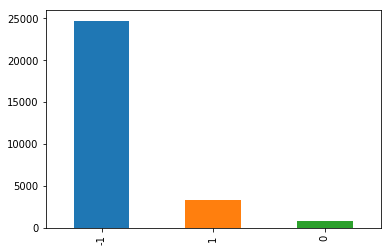

'2013 - IN_COM_PEDAGOGICA_1'

-1    25857
 1     3181
 0      962
Name: IN_COM_PEDAGOGICA_1, dtype: int64

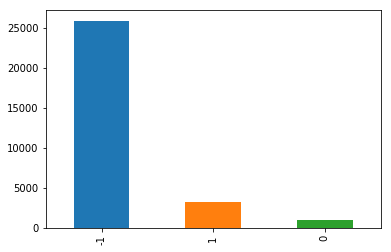

'2015 - IN_COM_PEDAGOGICA_1'

-1    27468
 1     3068
 0     1330
Name: IN_COM_PEDAGOGICA_1, dtype: int64

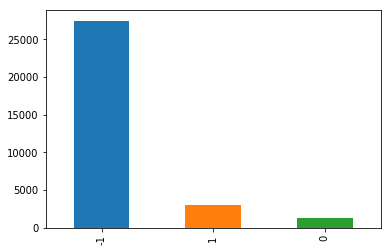

'2017 - IN_COM_PEDAGOGICA_1'

-1    27837
 1     2556
 0     1197
Name: IN_COM_PEDAGOGICA_1, dtype: int64

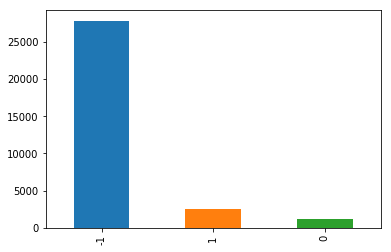

'2011 - IN_COM_PEDAGOGICA_2'

-1    28587
 1      133
 0       77
Name: IN_COM_PEDAGOGICA_2, dtype: int64

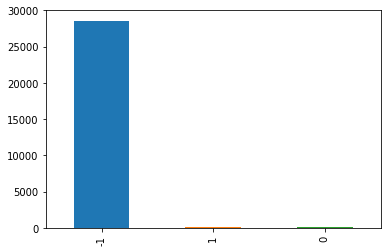

'2013 - IN_COM_PEDAGOGICA_2'

-1    29782
 1      120
 0       98
Name: IN_COM_PEDAGOGICA_2, dtype: int64

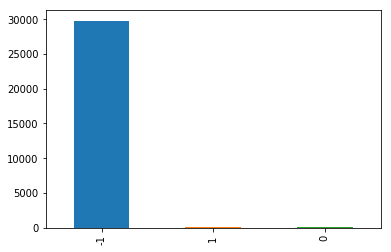

'2015 - IN_COM_PEDAGOGICA_2'

-1    31642
 1      125
 0       99
Name: IN_COM_PEDAGOGICA_2, dtype: int64

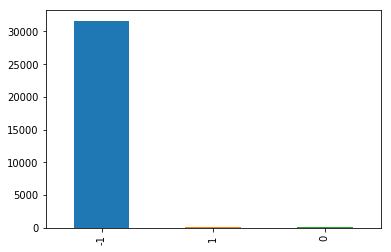

'2017 - IN_COM_PEDAGOGICA_2'

-1    31366
 1      131
 0       93
Name: IN_COM_PEDAGOGICA_2, dtype: int64

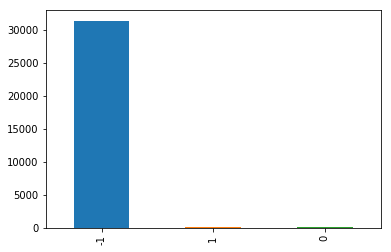

'2011 - IN_COM_PEDAGOGICA_3'

-1    28787
 0        6
 1        4
Name: IN_COM_PEDAGOGICA_3, dtype: int64

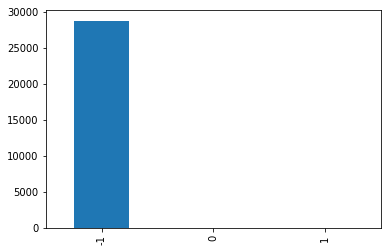

'2013 - IN_COM_PEDAGOGICA_3'

-1    29985
 0       13
 1        2
Name: IN_COM_PEDAGOGICA_3, dtype: int64

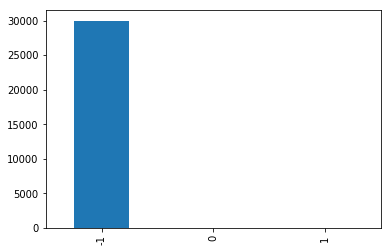

'2015 - IN_COM_PEDAGOGICA_3'

-1    31851
 0        8
 1        7
Name: IN_COM_PEDAGOGICA_3, dtype: int64

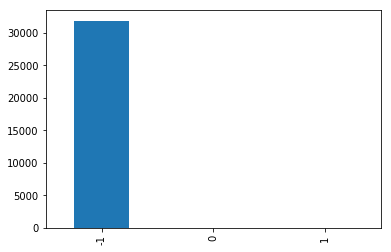

'2017 - IN_COM_PEDAGOGICA_3'

-1    31578
 0        7
 1        5
Name: IN_COM_PEDAGOGICA_3, dtype: int64

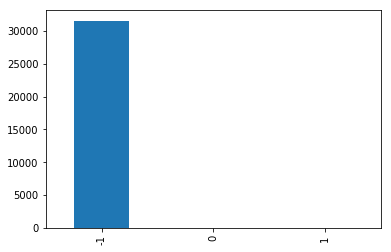

'2011 - IN_DISC_ARTES'

0    20795
1     8002
Name: IN_DISC_ARTES, dtype: int64

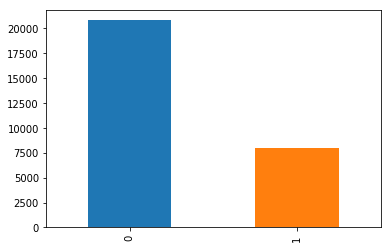

'2013 - IN_DISC_ARTES'

0    21619
1     8381
Name: IN_DISC_ARTES, dtype: int64

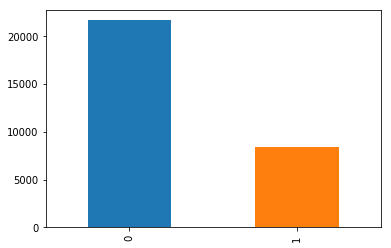

'2015 - IN_DISC_ARTES'

 0    15520
 1     8684
-1     7662
Name: IN_DISC_ARTES, dtype: int64

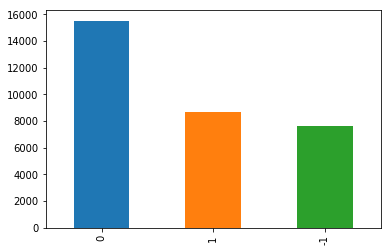

'2017 - IN_DISC_ARTES'

 0    14462
 1     9401
-1     7727
Name: IN_DISC_ARTES, dtype: int64

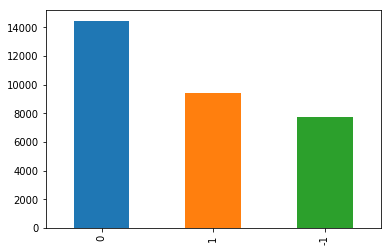

'2011 - IN_DISC_ATENDIMENTO_ESPECIAIS'

0    28797
Name: IN_DISC_ATENDIMENTO_ESPECIAIS, dtype: int64

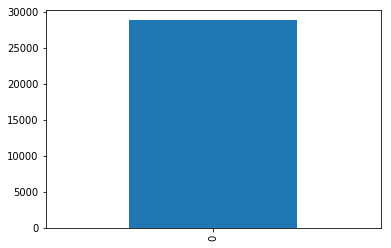

'2013 - IN_DISC_ATENDIMENTO_ESPECIAIS'

0    30000
Name: IN_DISC_ATENDIMENTO_ESPECIAIS, dtype: int64

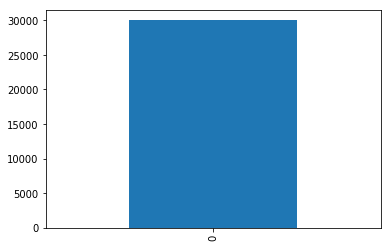

'2015 - IN_DISC_ATENDIMENTO_ESPECIAIS'

-1    31838
 0       28
Name: IN_DISC_ATENDIMENTO_ESPECIAIS, dtype: int64

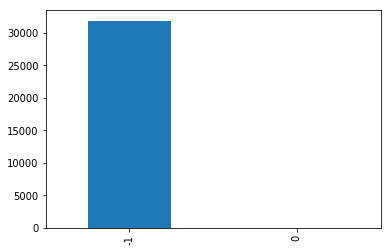

'2017 - IN_DISC_ATENDIMENTO_ESPECIAIS'

-1    31590
Name: IN_DISC_ATENDIMENTO_ESPECIAIS, dtype: int64

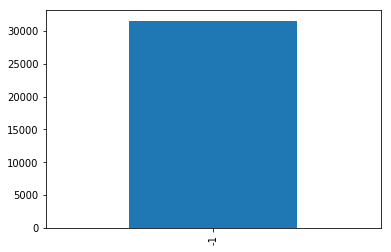

'2011 - IN_DISC_BIOLOGIA'

0    28309
1      488
Name: IN_DISC_BIOLOGIA, dtype: int64

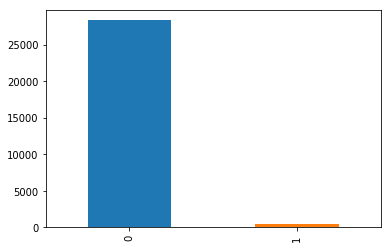

'2013 - IN_DISC_BIOLOGIA'

0    29508
1      492
Name: IN_DISC_BIOLOGIA, dtype: int64

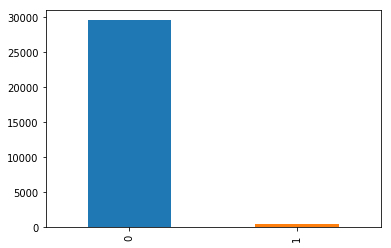

'2015 - IN_DISC_BIOLOGIA'

-1    18570
 0    12767
 1      529
Name: IN_DISC_BIOLOGIA, dtype: int64

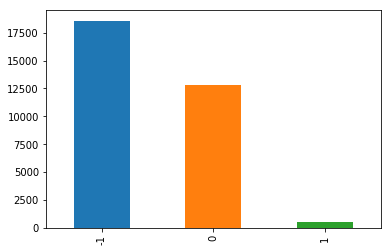

'2017 - IN_DISC_BIOLOGIA'

-1    18491
 0    12565
 1      534
Name: IN_DISC_BIOLOGIA, dtype: int64

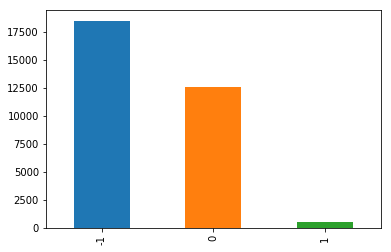

'2011 - IN_DISC_CIENCIAS'

0    18862
1     9935
Name: IN_DISC_CIENCIAS, dtype: int64

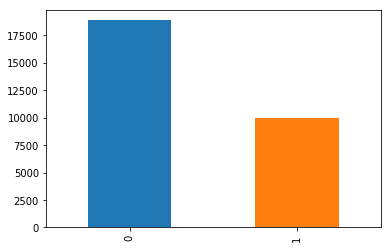

'2013 - IN_DISC_CIENCIAS'

0    19293
1    10707
Name: IN_DISC_CIENCIAS, dtype: int64

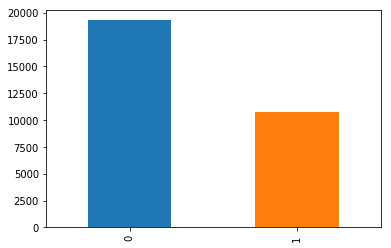

'2015 - IN_DISC_CIENCIAS'

-1    11764
 1    11033
 0     9069
Name: IN_DISC_CIENCIAS, dtype: int64

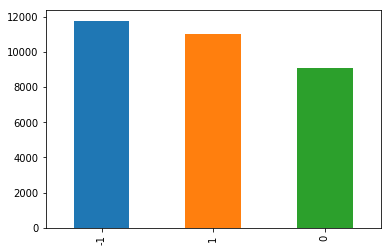

'2017 - IN_DISC_CIENCIAS'

-1    11907
 1    10995
 0     8688
Name: IN_DISC_CIENCIAS, dtype: int64

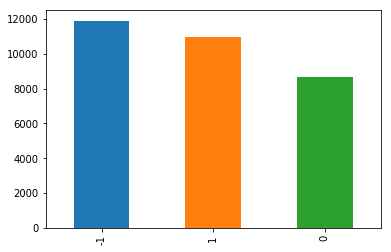

'2011 - IN_DISC_DIVER_SOCIO_CULTURAL'

0    28797
Name: IN_DISC_DIVER_SOCIO_CULTURAL, dtype: int64

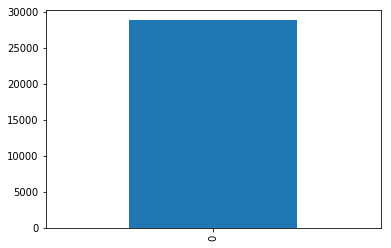

'2013 - IN_DISC_DIVER_SOCIO_CULTURAL'

0    30000
Name: IN_DISC_DIVER_SOCIO_CULTURAL, dtype: int64

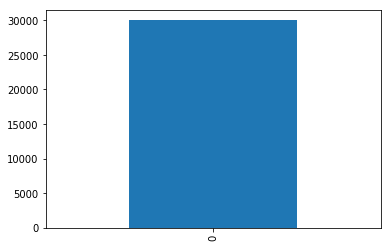

'2015 - IN_DISC_DIVER_SOCIO_CULTURAL'

-1    31838
 0       28
Name: IN_DISC_DIVER_SOCIO_CULTURAL, dtype: int64

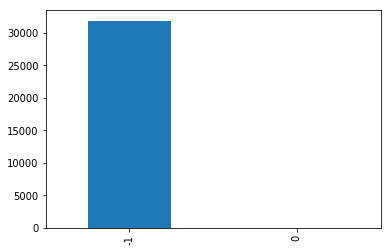

'2017 - IN_DISC_DIVER_SOCIO_CULTURAL'

-1    31590
Name: IN_DISC_DIVER_SOCIO_CULTURAL, dtype: int64

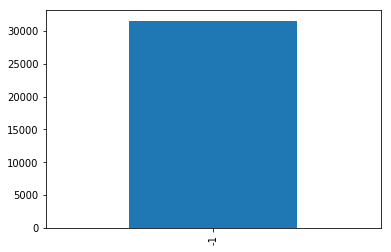

'2011 - IN_DISC_EDUCACAO_FISICA'

0    21817
1     6980
Name: IN_DISC_EDUCACAO_FISICA, dtype: int64

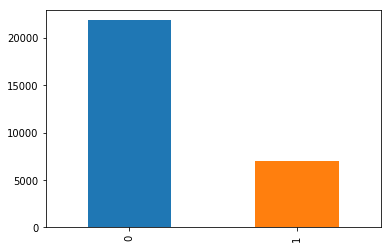

'2013 - IN_DISC_EDUCACAO_FISICA'

0    23141
1     6859
Name: IN_DISC_EDUCACAO_FISICA, dtype: int64

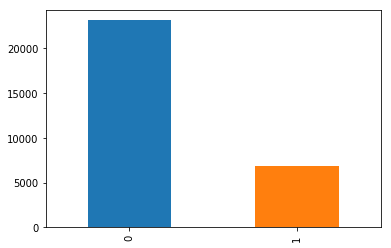

'2015 - IN_DISC_EDUCACAO_FISICA'

 0    17341
-1     7662
 1     6863
Name: IN_DISC_EDUCACAO_FISICA, dtype: int64

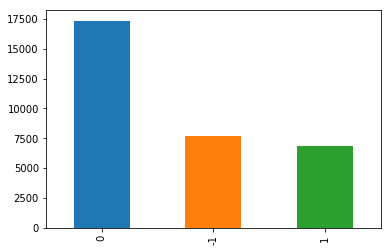

'2017 - IN_DISC_EDUCACAO_FISICA'

 0    16028
 1     7835
-1     7727
Name: IN_DISC_EDUCACAO_FISICA, dtype: int64

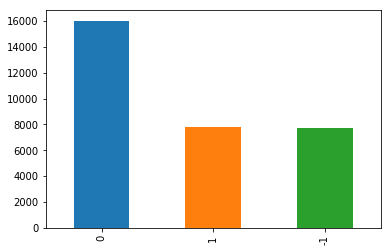

'2011 - IN_DISC_ENSINO_RELIGIOSO'

0    25618
1     3179
Name: IN_DISC_ENSINO_RELIGIOSO, dtype: int64

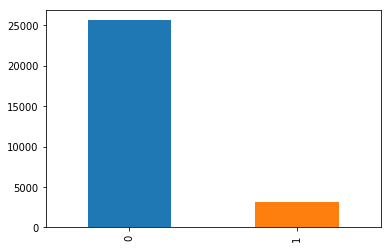

'2013 - IN_DISC_ENSINO_RELIGIOSO'

0    26872
1     3128
Name: IN_DISC_ENSINO_RELIGIOSO, dtype: int64

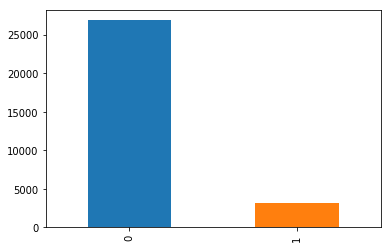

'2015 - IN_DISC_ENSINO_RELIGIOSO'

 0    20857
-1     7662
 1     3347
Name: IN_DISC_ENSINO_RELIGIOSO, dtype: int64

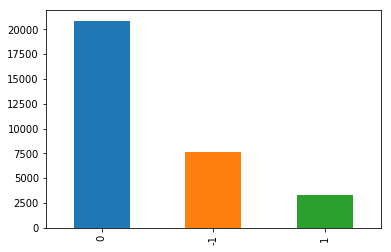

'2017 - IN_DISC_ENSINO_RELIGIOSO'

 0    20975
-1     7727
 1     2888
Name: IN_DISC_ENSINO_RELIGIOSO, dtype: int64

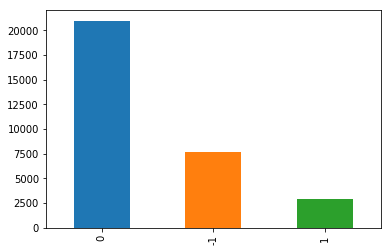

'2011 - IN_DISC_FILOSOFIA'

0    27919
1      878
Name: IN_DISC_FILOSOFIA, dtype: int64

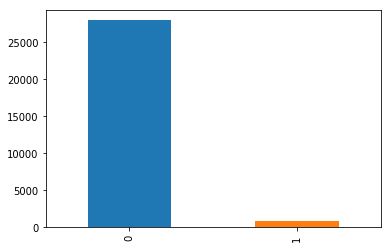

'2013 - IN_DISC_FILOSOFIA'

0    29113
1      887
Name: IN_DISC_FILOSOFIA, dtype: int64

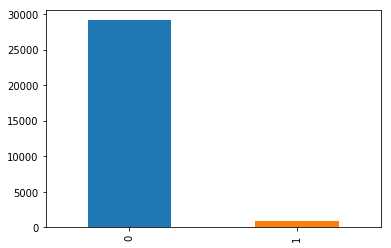

'2015 - IN_DISC_FILOSOFIA'

 0    23368
-1     7662
 1      836
Name: IN_DISC_FILOSOFIA, dtype: int64

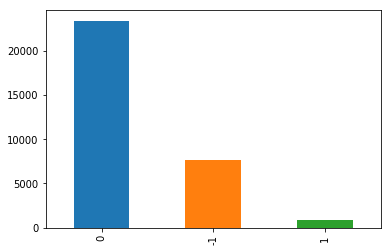

'2017 - IN_DISC_FILOSOFIA'

 0    23139
-1     7727
 1      724
Name: IN_DISC_FILOSOFIA, dtype: int64

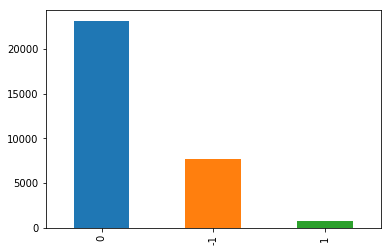

'2011 - IN_DISC_FISICA'

0    28328
1      469
Name: IN_DISC_FISICA, dtype: int64

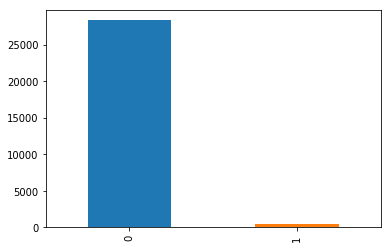

'2013 - IN_DISC_FISICA'

0    29528
1      472
Name: IN_DISC_FISICA, dtype: int64

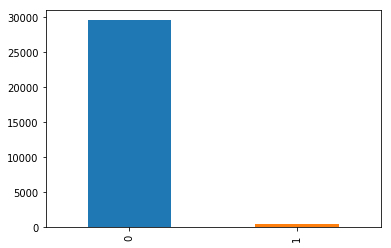

'2015 - IN_DISC_FISICA'

-1    18570
 0    12801
 1      495
Name: IN_DISC_FISICA, dtype: int64

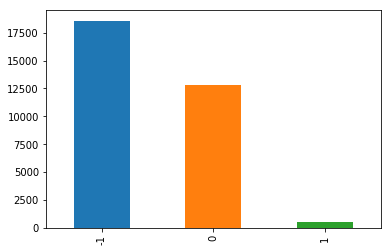

'2017 - IN_DISC_FISICA'

-1    18491
 0    12591
 1      508
Name: IN_DISC_FISICA, dtype: int64

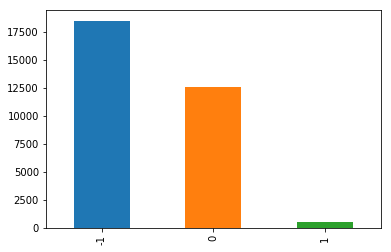

'2011 - IN_DISC_GEOGRAFIA'

0    19141
1     9656
Name: IN_DISC_GEOGRAFIA, dtype: int64

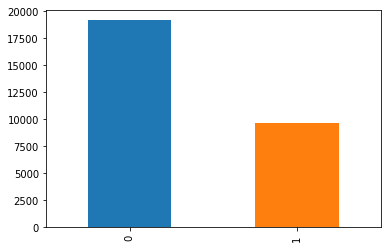

'2013 - IN_DISC_GEOGRAFIA'

0    20156
1     9844
Name: IN_DISC_GEOGRAFIA, dtype: int64

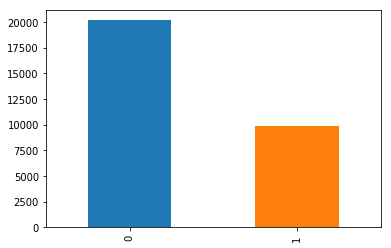

'2015 - IN_DISC_GEOGRAFIA'

 0    13825
 1    10379
-1     7662
Name: IN_DISC_GEOGRAFIA, dtype: int64

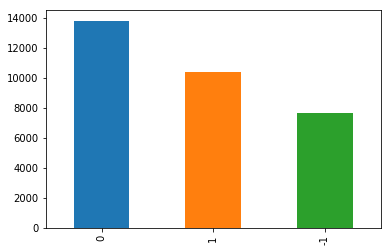

'2017 - IN_DISC_GEOGRAFIA'

 0    13346
 1    10517
-1     7727
Name: IN_DISC_GEOGRAFIA, dtype: int64

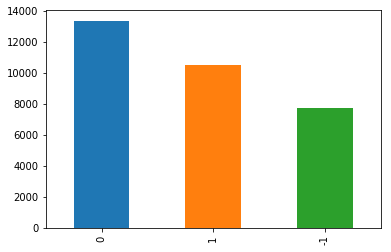

'2011 - IN_DISC_HISTORIA'

0    19159
1     9638
Name: IN_DISC_HISTORIA, dtype: int64

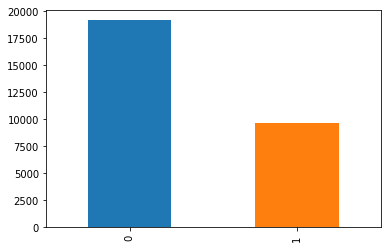

'2013 - IN_DISC_HISTORIA'

0    20100
1     9900
Name: IN_DISC_HISTORIA, dtype: int64

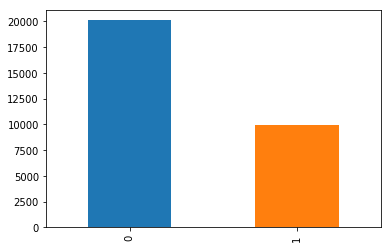

'2015 - IN_DISC_HISTORIA'

 0    13810
 1    10394
-1     7662
Name: IN_DISC_HISTORIA, dtype: int64

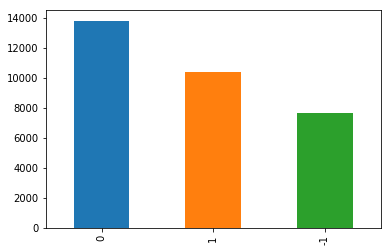

'2017 - IN_DISC_HISTORIA'

 0    13274
 1    10589
-1     7727
Name: IN_DISC_HISTORIA, dtype: int64

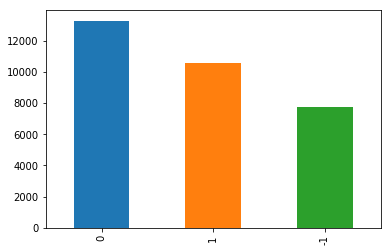

'2011 - IN_DISC_INFORMATICA_COMPUTACAO'

0    27999
1      798
Name: IN_DISC_INFORMATICA_COMPUTACAO, dtype: int64

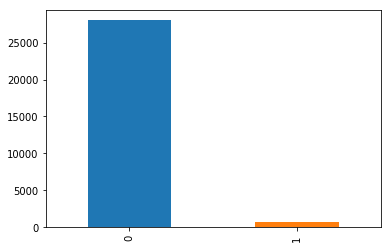

'2013 - IN_DISC_INFORMATICA_COMPUTACAO'

0    28834
1     1166
Name: IN_DISC_INFORMATICA_COMPUTACAO, dtype: int64

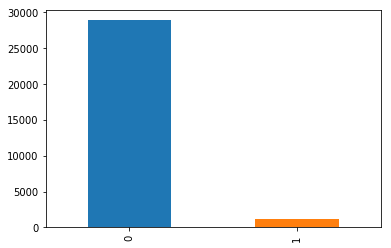

'2015 - IN_DISC_INFORMATICA_COMPUTACAO'

 0    23206
-1     7662
 1      998
Name: IN_DISC_INFORMATICA_COMPUTACAO, dtype: int64

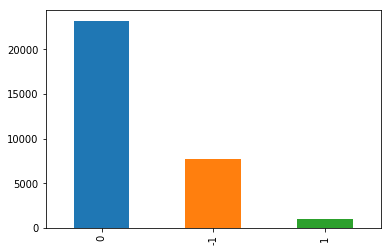

'2017 - IN_DISC_INFORMATICA_COMPUTACAO'

 0    23234
-1     7727
 1      629
Name: IN_DISC_INFORMATICA_COMPUTACAO, dtype: int64

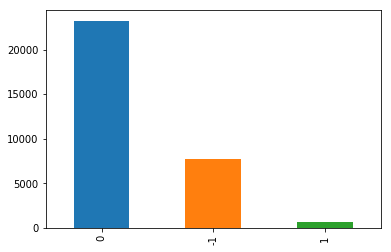

'2011 - IN_DISC_LIBRAS'

0    28738
1       59
Name: IN_DISC_LIBRAS, dtype: int64

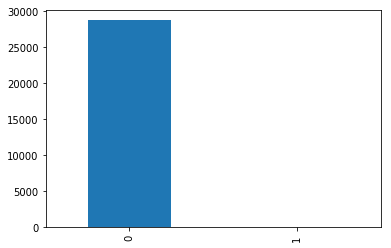

'2013 - IN_DISC_LIBRAS'

0    29973
1       27
Name: IN_DISC_LIBRAS, dtype: int64

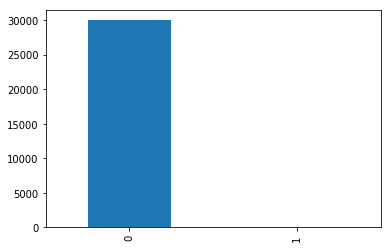

'2015 - IN_DISC_LIBRAS'

 0    24160
-1     7662
 1       44
Name: IN_DISC_LIBRAS, dtype: int64

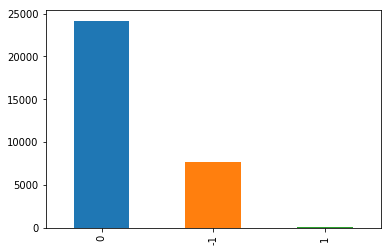

'2017 - IN_DISC_LIBRAS'

 0    23841
-1     7727
 1       22
Name: IN_DISC_LIBRAS, dtype: int64

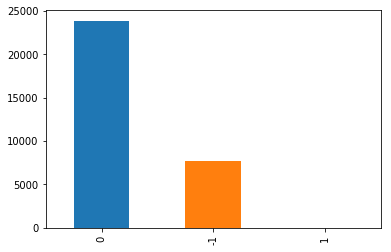

'2011 - IN_DISC_LINGUA_ESPANHOL'

0    28475
1      322
Name: IN_DISC_LINGUA_ESPANHOL, dtype: int64

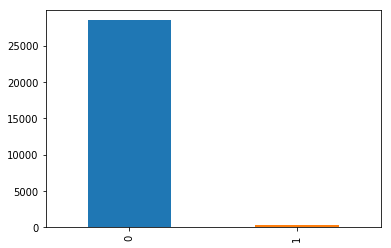

'2013 - IN_DISC_LINGUA_ESPANHOL'

0    29678
1      322
Name: IN_DISC_LINGUA_ESPANHOL, dtype: int64

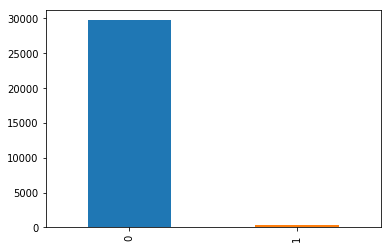

'2015 - IN_DISC_LINGUA_ESPANHOL'

 0    23856
-1     7662
 1      348
Name: IN_DISC_LINGUA_ESPANHOL, dtype: int64

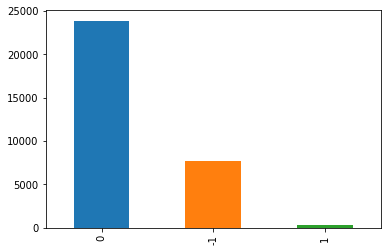

'2017 - IN_DISC_LINGUA_ESPANHOL'

 0    23529
-1     7727
 1      334
Name: IN_DISC_LINGUA_ESPANHOL, dtype: int64

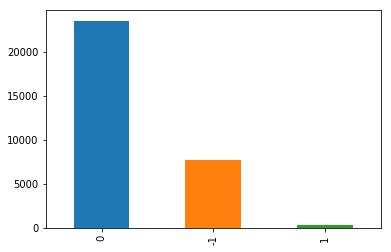

'2011 - IN_DISC_LINGUA_INDIGENA'

0    28797
Name: IN_DISC_LINGUA_INDIGENA, dtype: int64

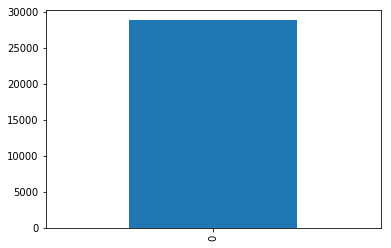

'2013 - IN_DISC_LINGUA_INDIGENA'

0    30000
Name: IN_DISC_LINGUA_INDIGENA, dtype: int64

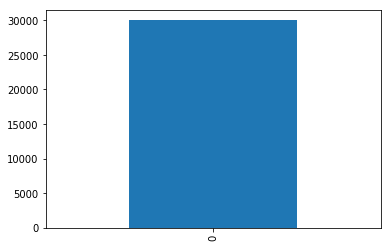

'2015 - IN_DISC_LINGUA_INDIGENA'

 0    24201
-1     7662
 1        3
Name: IN_DISC_LINGUA_INDIGENA, dtype: int64

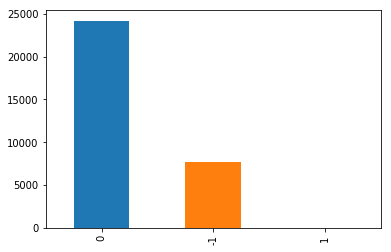

'2017 - IN_DISC_LINGUA_INDIGENA'

 0    23858
-1     7727
 1        5
Name: IN_DISC_LINGUA_INDIGENA, dtype: int64

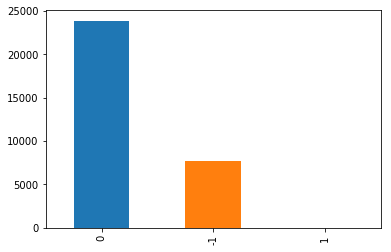

'2011 - IN_DISC_LINGUA_INGLES'

0    27307
1     1490
Name: IN_DISC_LINGUA_INGLES, dtype: int64

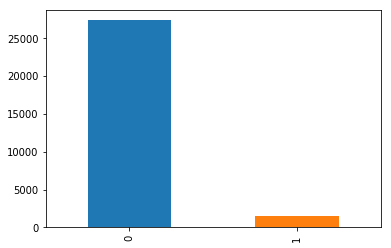

'2013 - IN_DISC_LINGUA_INGLES'

0    28425
1     1575
Name: IN_DISC_LINGUA_INGLES, dtype: int64

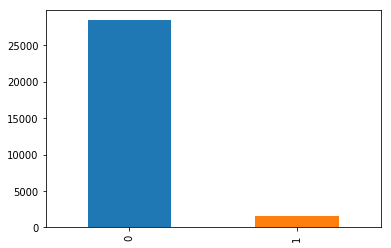

'2015 - IN_DISC_LINGUA_INGLES'

 0    22661
-1     7662
 1     1543
Name: IN_DISC_LINGUA_INGLES, dtype: int64

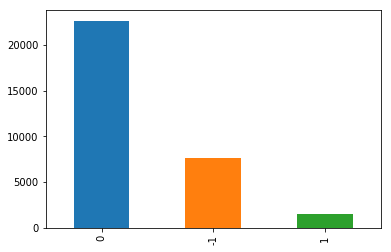

'2017 - IN_DISC_LINGUA_INGLES'

 0    22333
-1     7727
 1     1530
Name: IN_DISC_LINGUA_INGLES, dtype: int64

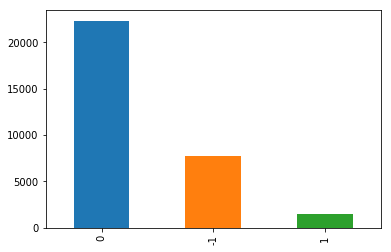

'2011 - IN_DISC_LINGUA_OUTRA'

0    28788
1        9
Name: IN_DISC_LINGUA_OUTRA, dtype: int64

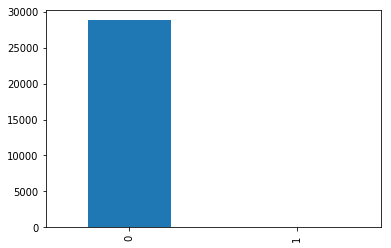

'2013 - IN_DISC_LINGUA_OUTRA'

0    29993
1        7
Name: IN_DISC_LINGUA_OUTRA, dtype: int64

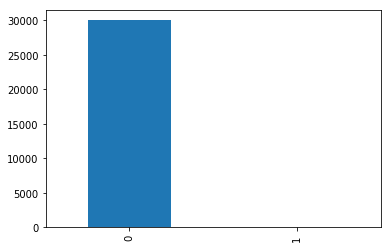

'2015 - IN_DISC_LINGUA_OUTRA'

 0    24196
-1     7662
 1        8
Name: IN_DISC_LINGUA_OUTRA, dtype: int64

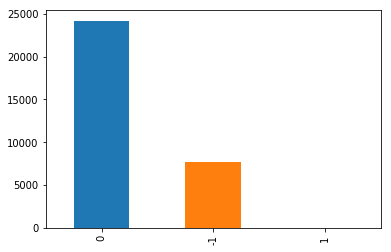

'2017 - IN_DISC_LINGUA_OUTRA'

 0    23851
-1     7727
 1       12
Name: IN_DISC_LINGUA_OUTRA, dtype: int64

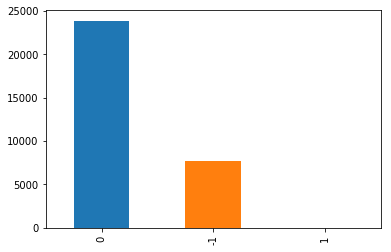

'2011 - IN_DISC_LINGUA_PORTUGUESA'

0    17951
1    10846
Name: IN_DISC_LINGUA_PORTUGUESA, dtype: int64

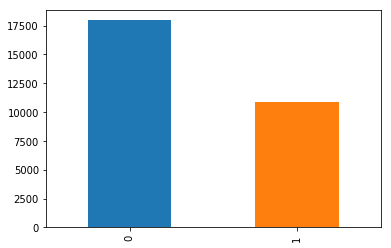

'2013 - IN_DISC_LINGUA_PORTUGUESA'

0    18272
1    11728
Name: IN_DISC_LINGUA_PORTUGUESA, dtype: int64

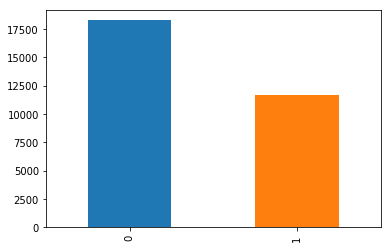

'2015 - IN_DISC_LINGUA_PORTUGUESA'

 0    12184
 1    12020
-1     7662
Name: IN_DISC_LINGUA_PORTUGUESA, dtype: int64

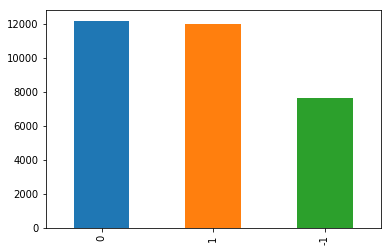

'2017 - IN_DISC_LINGUA_PORTUGUESA'

 1    11986
 0    11877
-1     7727
Name: IN_DISC_LINGUA_PORTUGUESA, dtype: int64

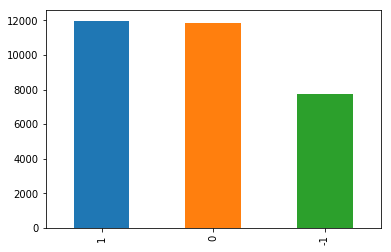

'2011 - IN_DISC_MATEMATICA'

0    18059
1    10738
Name: IN_DISC_MATEMATICA, dtype: int64

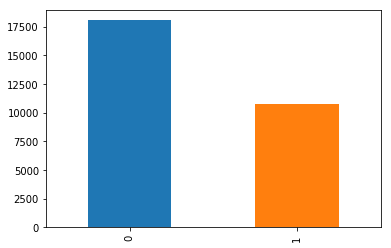

'2013 - IN_DISC_MATEMATICA'

0    18423
1    11577
Name: IN_DISC_MATEMATICA, dtype: int64

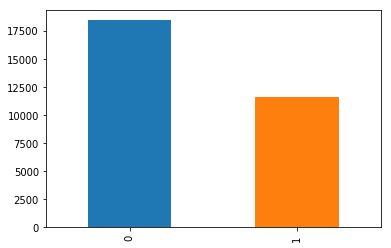

'2015 - IN_DISC_MATEMATICA'

 0    12403
 1    11801
-1     7662
Name: IN_DISC_MATEMATICA, dtype: int64

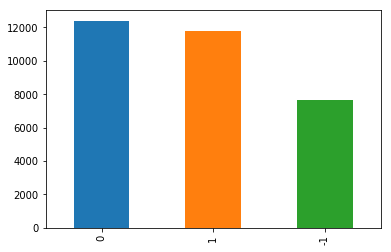

'2017 - IN_DISC_MATEMATICA'

 0    12093
 1    11770
-1     7727
Name: IN_DISC_MATEMATICA, dtype: int64

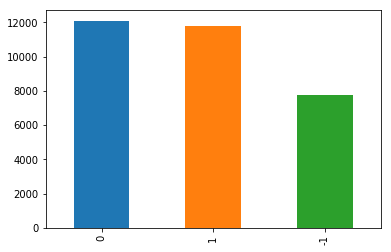

'2011 - IN_DISC_OUTRAS'

0    25962
1     2835
Name: IN_DISC_OUTRAS, dtype: int64

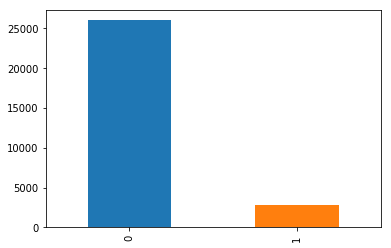

'2013 - IN_DISC_OUTRAS'

0    27224
1     2776
Name: IN_DISC_OUTRAS, dtype: int64

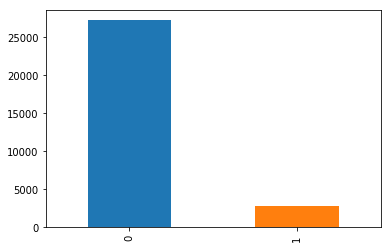

'2015 - IN_DISC_OUTRAS'

 0    21131
-1     7662
 1     3073
Name: IN_DISC_OUTRAS, dtype: int64

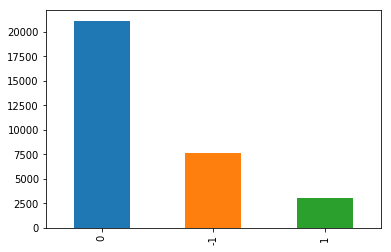

'2017 - IN_DISC_OUTRAS'

 0    21885
-1     7727
 1     1978
Name: IN_DISC_OUTRAS, dtype: int64

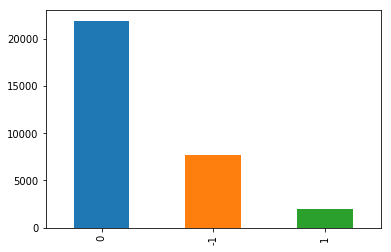

'2011 - IN_DISC_PEDAGOGICAS'

0    28797
Name: IN_DISC_PEDAGOGICAS, dtype: int64

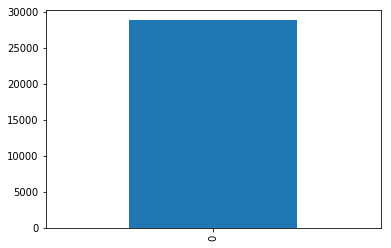

'2013 - IN_DISC_PEDAGOGICAS'

0    30000
Name: IN_DISC_PEDAGOGICAS, dtype: int64

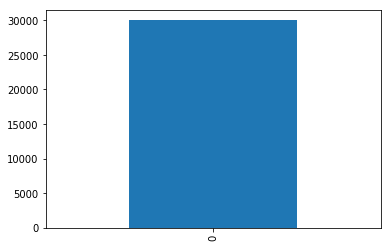

'2015 - IN_DISC_PEDAGOGICAS'

-1    31838
 0       28
Name: IN_DISC_PEDAGOGICAS, dtype: int64

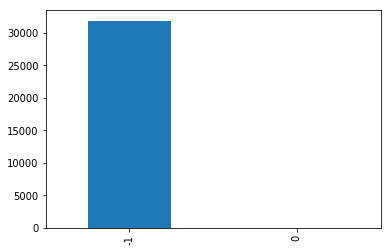

'2017 - IN_DISC_PEDAGOGICAS'

-1    31590
Name: IN_DISC_PEDAGOGICAS, dtype: int64

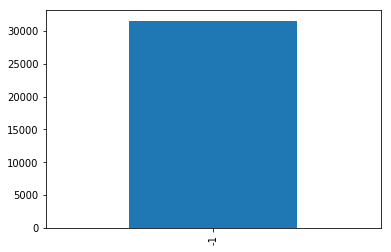

'2011 - IN_DISC_PROFISSIONALIZANTE'

0    28045
1      752
Name: IN_DISC_PROFISSIONALIZANTE, dtype: int64

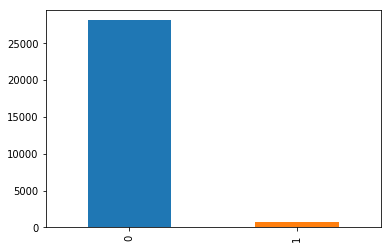

'2013 - IN_DISC_PROFISSIONALIZANTE'

0    29231
1      769
Name: IN_DISC_PROFISSIONALIZANTE, dtype: int64

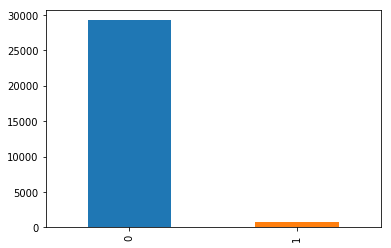

'2015 - IN_DISC_PROFISSIONALIZANTE'

-1    30581
 1     1211
 0       74
Name: IN_DISC_PROFISSIONALIZANTE, dtype: int64

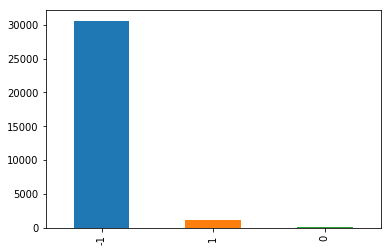

'2017 - IN_DISC_PROFISSIONALIZANTE'

-1    30401
 1     1033
 0      156
Name: IN_DISC_PROFISSIONALIZANTE, dtype: int64

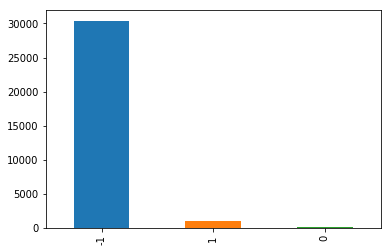

'2011 - IN_DISC_QUIMICA'

0    28355
1      442
Name: IN_DISC_QUIMICA, dtype: int64

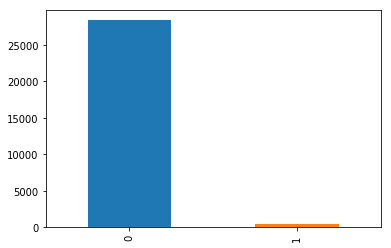

'2013 - IN_DISC_QUIMICA'

0    29540
1      460
Name: IN_DISC_QUIMICA, dtype: int64

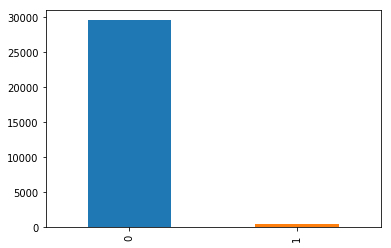

'2015 - IN_DISC_QUIMICA'

-1    18570
 0    12805
 1      491
Name: IN_DISC_QUIMICA, dtype: int64

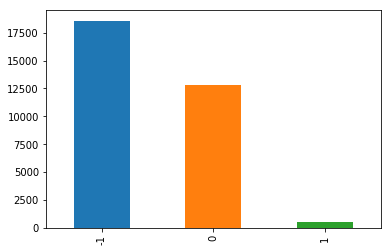

'2017 - IN_DISC_QUIMICA'

-1    18491
 0    12611
 1      488
Name: IN_DISC_QUIMICA, dtype: int64

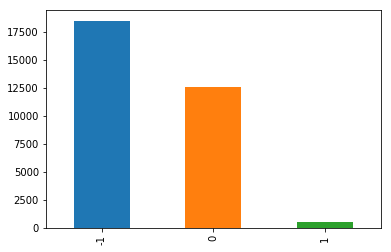

'2011 - IN_DOUTORADO'

0    28735
1       62
Name: IN_DOUTORADO, dtype: int64

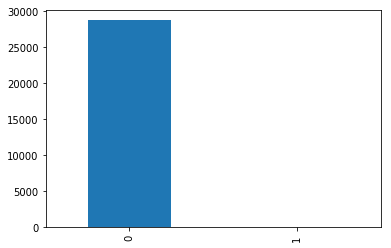

'2013 - IN_DOUTORADO'

0    29902
1       98
Name: IN_DOUTORADO, dtype: int64

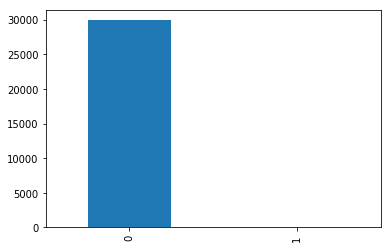

'2015 - IN_DOUTORADO'

 0    28777
-1     2965
 1      124
Name: IN_DOUTORADO, dtype: int64

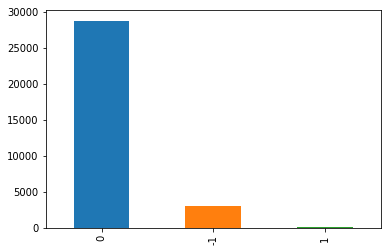

'2017 - IN_DOUTORADO'

 0    28948
-1     2470
 1      172
Name: IN_DOUTORADO, dtype: int64

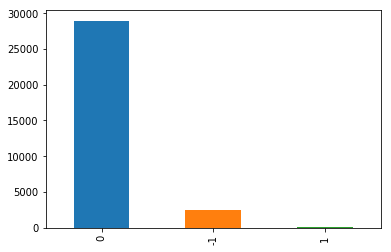

'2011 - IN_ESPECIALIZACAO'

0    19351
1     9446
Name: IN_ESPECIALIZACAO, dtype: int64

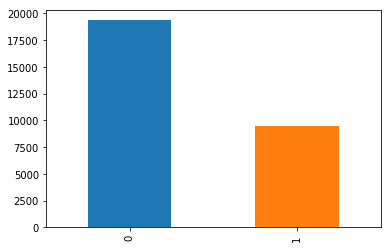

'2013 - IN_ESPECIALIZACAO'

0    18768
1    11232
Name: IN_ESPECIALIZACAO, dtype: int64

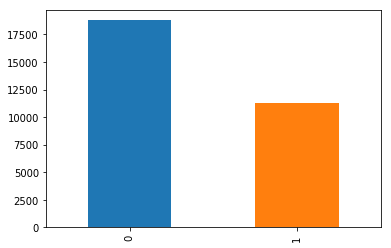

'2015 - IN_ESPECIALIZACAO'

 0    16647
 1    12254
-1     2965
Name: IN_ESPECIALIZACAO, dtype: int64

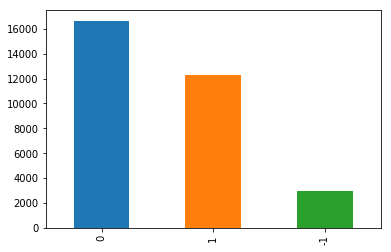

'2017 - IN_ESPECIALIZACAO'

 0    16555
 1    12565
-1     2470
Name: IN_ESPECIALIZACAO, dtype: int64

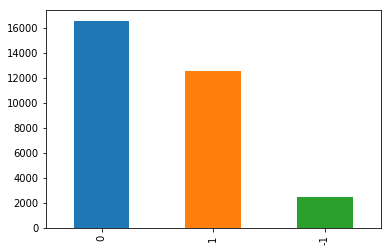

'2011 - IN_ESPECIFICO_ANOS_FINAIS'

0    28169
1      628
Name: IN_ESPECIFICO_ANOS_FINAIS, dtype: int64

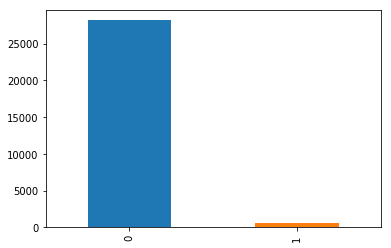

'2013 - IN_ESPECIFICO_ANOS_FINAIS'

0    29021
1      979
Name: IN_ESPECIFICO_ANOS_FINAIS, dtype: int64

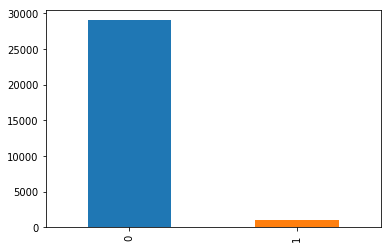

'2015 - IN_ESPECIFICO_ANOS_FINAIS'

0    30660
1     1206
Name: IN_ESPECIFICO_ANOS_FINAIS, dtype: int64

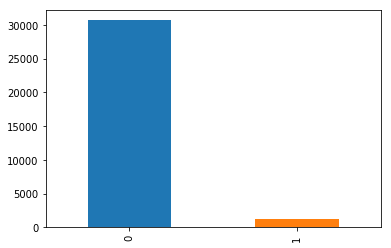

'2017 - IN_ESPECIFICO_ANOS_FINAIS'

0    30207
1     1383
Name: IN_ESPECIFICO_ANOS_FINAIS, dtype: int64

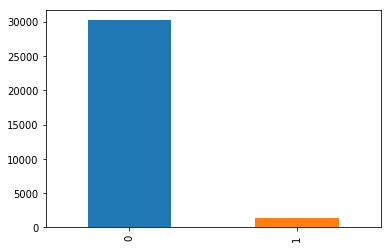

'2011 - IN_ESPECIFICO_ANOS_INICIAIS'

0    26894
1     1903
Name: IN_ESPECIFICO_ANOS_INICIAIS, dtype: int64

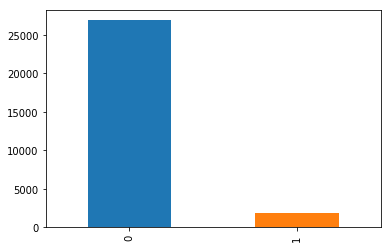

'2013 - IN_ESPECIFICO_ANOS_INICIAIS'

0    26713
1     3287
Name: IN_ESPECIFICO_ANOS_INICIAIS, dtype: int64

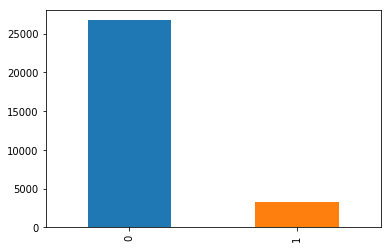

'2015 - IN_ESPECIFICO_ANOS_INICIAIS'

0    27982
1     3884
Name: IN_ESPECIFICO_ANOS_INICIAIS, dtype: int64

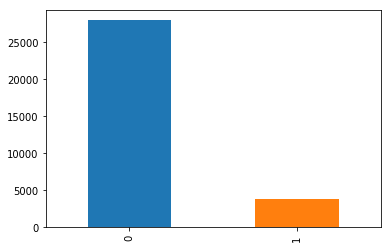

'2017 - IN_ESPECIFICO_ANOS_INICIAIS'

0    27532
1     4058
Name: IN_ESPECIFICO_ANOS_INICIAIS, dtype: int64

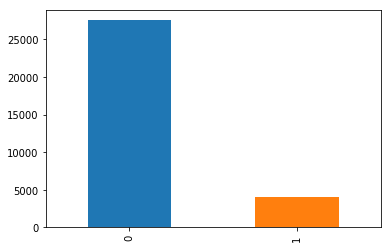

'2011 - IN_ESPECIFICO_CRECHE'

0    28076
1      721
Name: IN_ESPECIFICO_CRECHE, dtype: int64

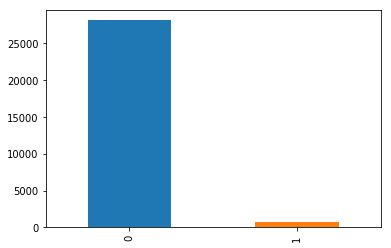

'2013 - IN_ESPECIFICO_CRECHE'

0    29264
1      736
Name: IN_ESPECIFICO_CRECHE, dtype: int64

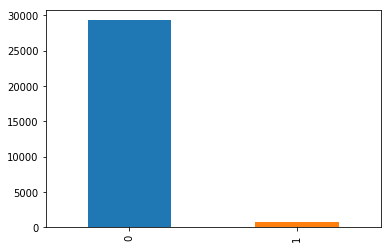

'2015 - IN_ESPECIFICO_CRECHE'

0    31043
1      823
Name: IN_ESPECIFICO_CRECHE, dtype: int64

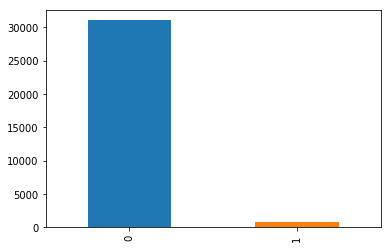

'2017 - IN_ESPECIFICO_CRECHE'

0    30700
1      890
Name: IN_ESPECIFICO_CRECHE, dtype: int64

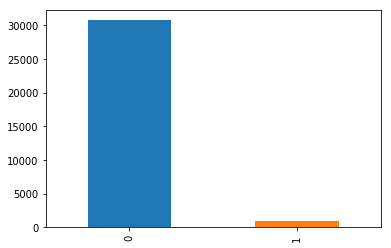

'2011 - IN_ESPECIFICO_ED_ESPECIAL'

0    24342
1     4455
Name: IN_ESPECIFICO_ED_ESPECIAL, dtype: int64

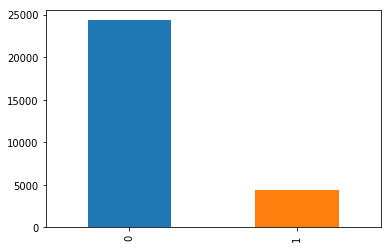

'2013 - IN_ESPECIFICO_ED_ESPECIAL'

0    25248
1     4752
Name: IN_ESPECIFICO_ED_ESPECIAL, dtype: int64

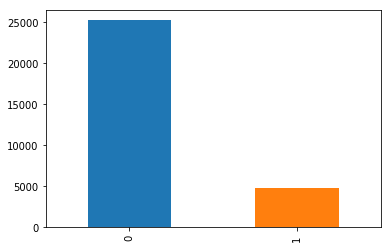

'2015 - IN_ESPECIFICO_ED_ESPECIAL'

0    27026
1     4840
Name: IN_ESPECIFICO_ED_ESPECIAL, dtype: int64

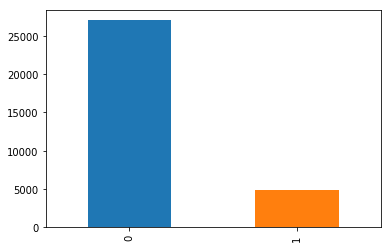

'2017 - IN_ESPECIFICO_ED_ESPECIAL'

0    27067
1     4523
Name: IN_ESPECIFICO_ED_ESPECIAL, dtype: int64

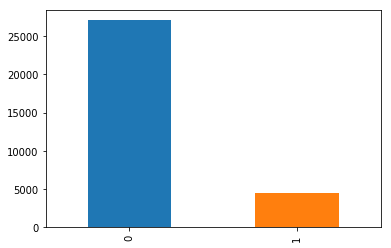

'2011 - IN_ESPECIFICO_ED_INDIGENA'

0    28729
1       68
Name: IN_ESPECIFICO_ED_INDIGENA, dtype: int64

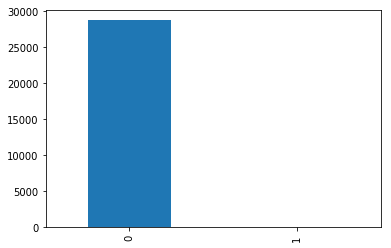

'2013 - IN_ESPECIFICO_ED_INDIGENA'

0    29940
1       60
Name: IN_ESPECIFICO_ED_INDIGENA, dtype: int64

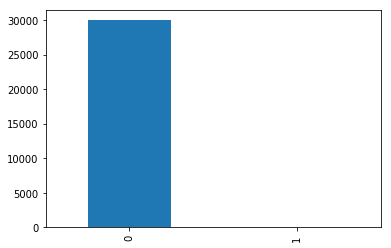

'2015 - IN_ESPECIFICO_ED_INDIGENA'

0    31803
1       63
Name: IN_ESPECIFICO_ED_INDIGENA, dtype: int64

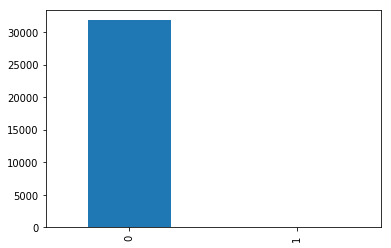

'2017 - IN_ESPECIFICO_ED_INDIGENA'

0    31524
1       66
Name: IN_ESPECIFICO_ED_INDIGENA, dtype: int64

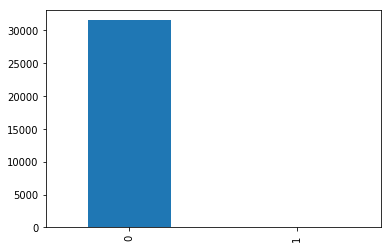

'2011 - IN_ESPECIFICO_EJA'

0    28334
1      463
Name: IN_ESPECIFICO_EJA, dtype: int64

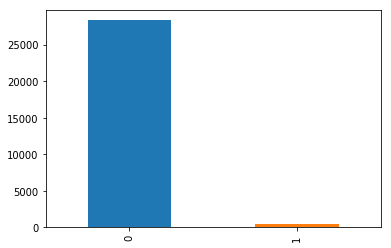

'2013 - IN_ESPECIFICO_EJA'

0    29162
1      838
Name: IN_ESPECIFICO_EJA, dtype: int64

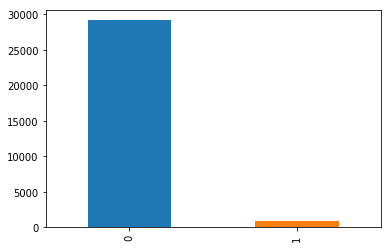

'2015 - IN_ESPECIFICO_EJA'

0    30836
1     1030
Name: IN_ESPECIFICO_EJA, dtype: int64

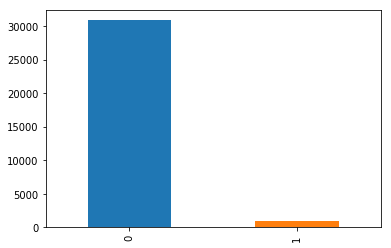

'2017 - IN_ESPECIFICO_EJA'

0    30458
1     1132
Name: IN_ESPECIFICO_EJA, dtype: int64

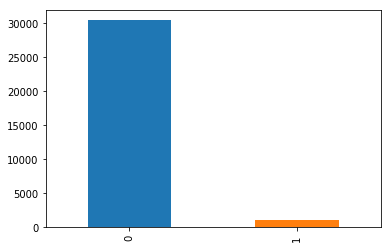

'2011 - IN_ESPECIFICO_ENS_MEDIO'

0    28329
1      468
Name: IN_ESPECIFICO_ENS_MEDIO, dtype: int64

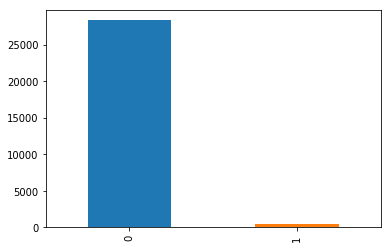

'2013 - IN_ESPECIFICO_ENS_MEDIO'

0    29338
1      662
Name: IN_ESPECIFICO_ENS_MEDIO, dtype: int64

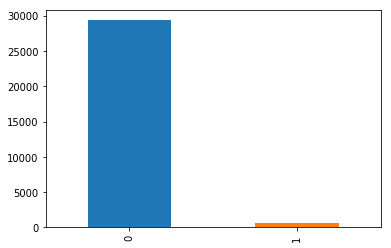

'2015 - IN_ESPECIFICO_ENS_MEDIO'

0    30986
1      880
Name: IN_ESPECIFICO_ENS_MEDIO, dtype: int64

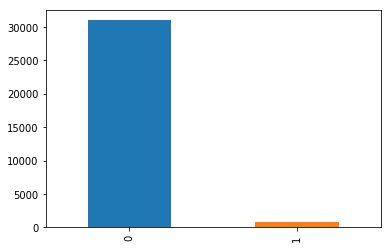

'2017 - IN_ESPECIFICO_ENS_MEDIO'

0    30590
1     1000
Name: IN_ESPECIFICO_ENS_MEDIO, dtype: int64

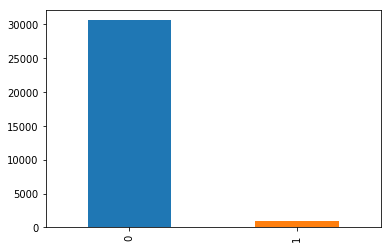

'2011 - IN_ESPECIFICO_NENHUM'

1    16596
0    12201
Name: IN_ESPECIFICO_NENHUM, dtype: int64

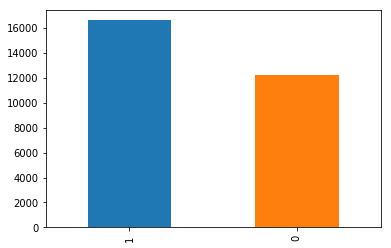

'2013 - IN_ESPECIFICO_NENHUM'

1    16053
0    13947
Name: IN_ESPECIFICO_NENHUM, dtype: int64

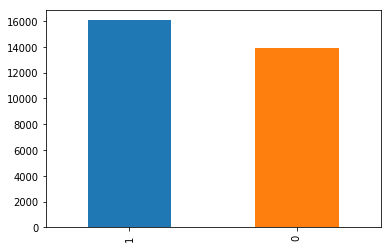

'2015 - IN_ESPECIFICO_NENHUM'

1    16802
0    15064
Name: IN_ESPECIFICO_NENHUM, dtype: int64

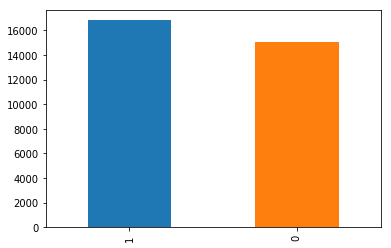

'2017 - IN_ESPECIFICO_NENHUM'

1    16023
0    15567
Name: IN_ESPECIFICO_NENHUM, dtype: int64

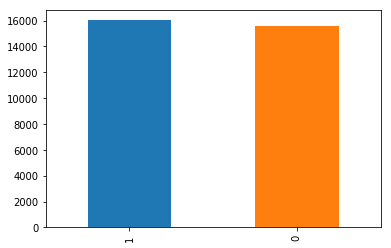

'2011 - IN_ESPECIFICO_OUTROS'

0    26831
1     1966
Name: IN_ESPECIFICO_OUTROS, dtype: int64

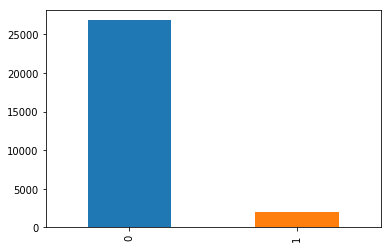

'2013 - IN_ESPECIFICO_OUTROS'

0    21742
1     8258
Name: IN_ESPECIFICO_OUTROS, dtype: int64

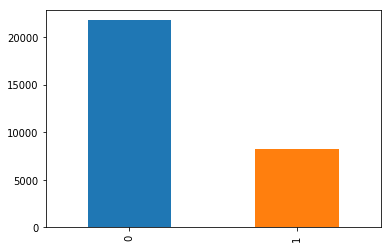

'2015 - IN_ESPECIFICO_OUTROS'

0    22768
1     9098
Name: IN_ESPECIFICO_OUTROS, dtype: int64

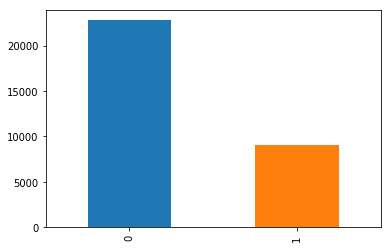

'2017 - IN_ESPECIFICO_OUTROS'

0    22059
1     9531
Name: IN_ESPECIFICO_OUTROS, dtype: int64

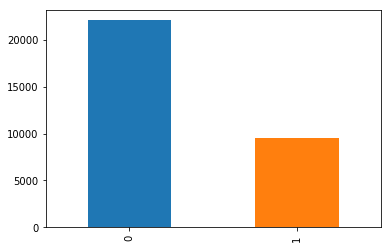

'2011 - IN_ESPECIFICO_PRE_ESCOLA'

0    25602
1     3195
Name: IN_ESPECIFICO_PRE_ESCOLA, dtype: int64

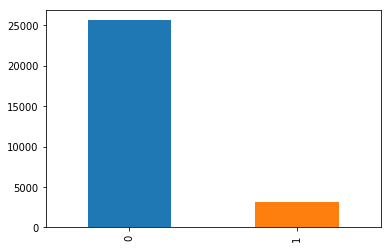

'2013 - IN_ESPECIFICO_PRE_ESCOLA'

0    26802
1     3198
Name: IN_ESPECIFICO_PRE_ESCOLA, dtype: int64

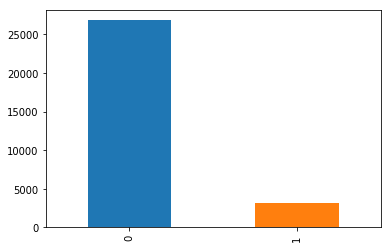

'2015 - IN_ESPECIFICO_PRE_ESCOLA'

0    28678
1     3188
Name: IN_ESPECIFICO_PRE_ESCOLA, dtype: int64

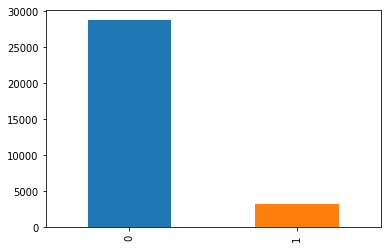

'2017 - IN_ESPECIFICO_PRE_ESCOLA'

0    28638
1     2952
Name: IN_ESPECIFICO_PRE_ESCOLA, dtype: int64

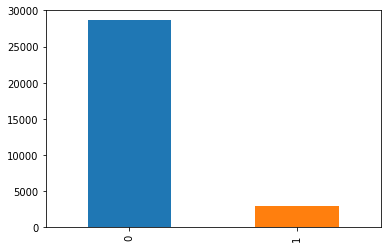

'2011 - IN_LICENCIATURA_1'

 1    20937
 0     4076
-1     3784
Name: IN_LICENCIATURA_1, dtype: int64

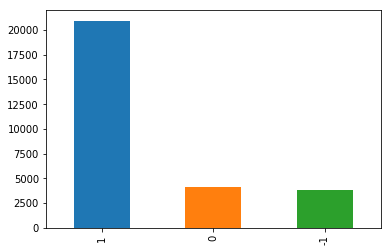

'2013 - IN_LICENCIATURA_1'

 1    24085
 0     4170
-1     1745
Name: IN_LICENCIATURA_1, dtype: int64

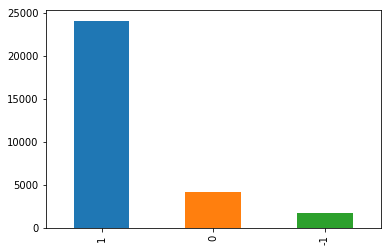

'2015 - IN_LICENCIATURA_1'

 1    25401
 0     4470
-1     1995
Name: IN_LICENCIATURA_1, dtype: int64

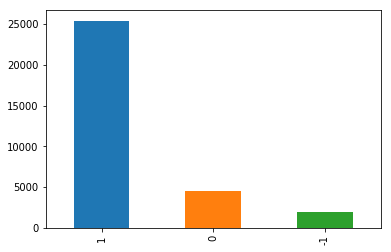

'2017 - IN_LICENCIATURA_1'

 1    26293
 0     3838
-1     1459
Name: IN_LICENCIATURA_1, dtype: int64

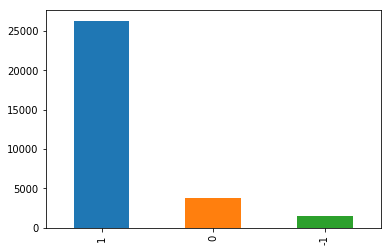

'2011 - IN_LICENCIATURA_2'

-1    28053
 1      534
 0      210
Name: IN_LICENCIATURA_2, dtype: int64

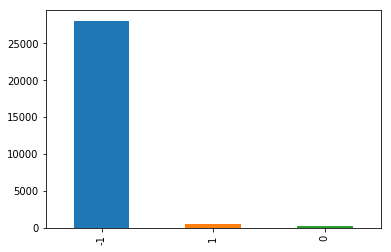

'2013 - IN_LICENCIATURA_2'

-1    29292
 1      485
 0      223
Name: IN_LICENCIATURA_2, dtype: int64

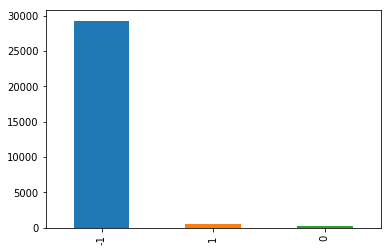

'2015 - IN_LICENCIATURA_2'

-1    31096
 1      535
 0      235
Name: IN_LICENCIATURA_2, dtype: int64

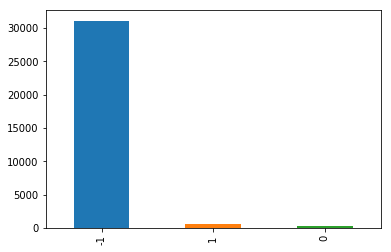

'2017 - IN_LICENCIATURA_2'

-1    30716
 1      640
 0      234
Name: IN_LICENCIATURA_2, dtype: int64

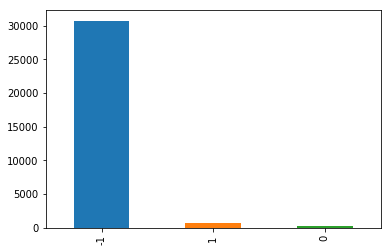

'2011 - IN_LICENCIATURA_3'

-1    28773
 1       14
 0       10
Name: IN_LICENCIATURA_3, dtype: int64

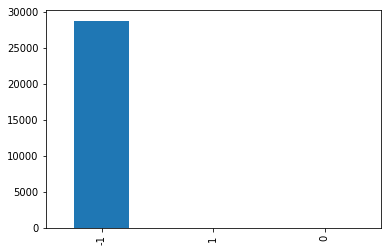

'2013 - IN_LICENCIATURA_3'

-1    29972
 0       15
 1       13
Name: IN_LICENCIATURA_3, dtype: int64

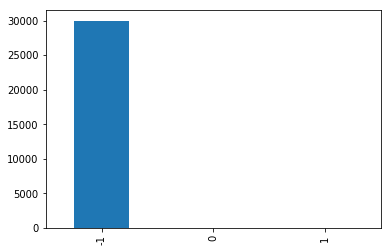

'2015 - IN_LICENCIATURA_3'

-1    31831
 1       19
 0       16
Name: IN_LICENCIATURA_3, dtype: int64

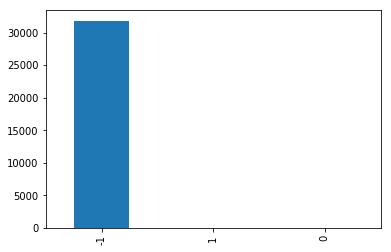

'2017 - IN_LICENCIATURA_3'

-1    31555
 1       23
 0       12
Name: IN_LICENCIATURA_3, dtype: int64

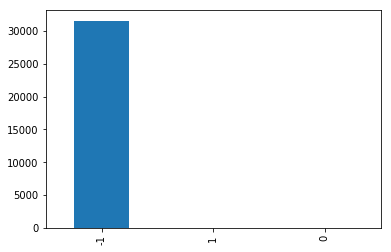

'2011 - IN_MESTRADO'

0    28101
1      696
Name: IN_MESTRADO, dtype: int64

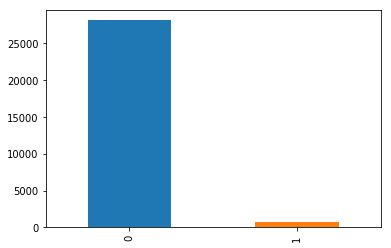

'2013 - IN_MESTRADO'

0    29133
1      867
Name: IN_MESTRADO, dtype: int64

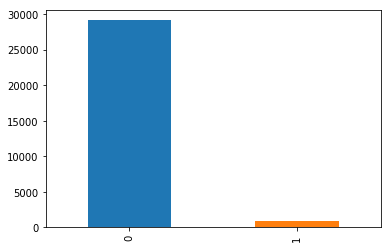

'2015 - IN_MESTRADO'

 0    27907
-1     2965
 1      994
Name: IN_MESTRADO, dtype: int64

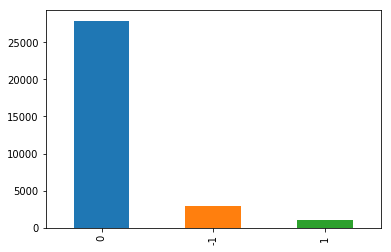

'2017 - IN_MESTRADO'

 0    27994
-1     2470
 1     1126
Name: IN_MESTRADO, dtype: int64

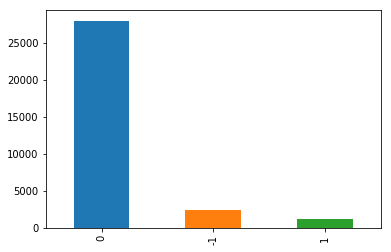

'2011 - IN_POS_NENHUM'

1    18768
0    10029
Name: IN_POS_NENHUM, dtype: int64

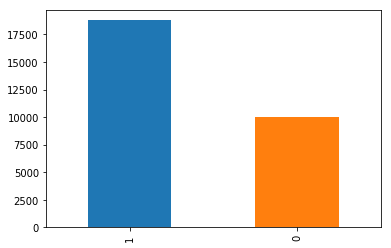

'2013 - IN_POS_NENHUM'

1    15462
0    14538
Name: IN_POS_NENHUM, dtype: int64

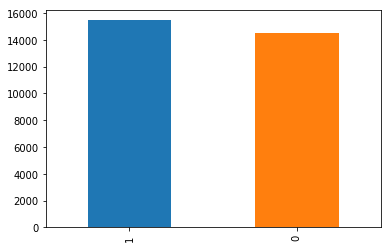

'2015 - IN_POS_NENHUM'

 1    15877
 0    13024
-1     2965
Name: IN_POS_NENHUM, dtype: int64

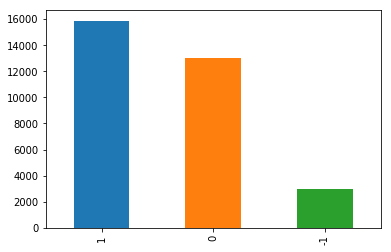

'2017 - IN_POS_NENHUM'

 1    15688
 0    13432
-1     2470
Name: IN_POS_NENHUM, dtype: int64

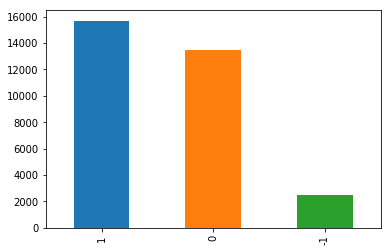

'2011 - NU_ANO'

count    28797.000000
mean      1972.485745
std          8.882436
min       1934.000000
25%       1966.000000
50%       1973.000000
75%       1979.000000
max       1995.000000
Name: NU_ANO, dtype: float64

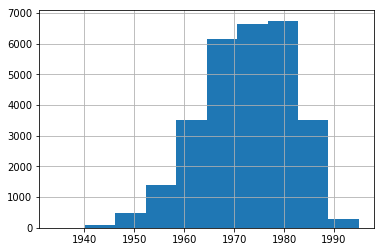

'2013 - NU_ANO'

count    30000.000000
mean      1973.908033
std          8.972052
min       1934.000000
25%       1968.000000
50%       1975.000000
75%       1981.000000
max       1998.000000
Name: NU_ANO, dtype: float64

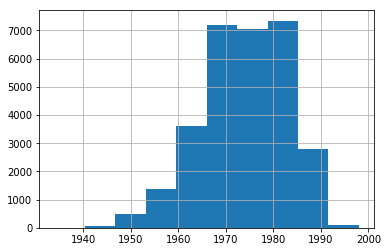

'2015 - NU_ANO'

count    31866.000000
mean      1975.311963
std          9.077185
min       1934.000000
25%       1969.000000
50%       1976.000000
75%       1982.000000
max       1998.000000
Name: NU_ANO, dtype: float64

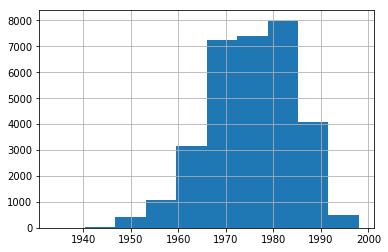

'2017 - NU_ANO'

count    31590.000000
mean      1976.893890
std          9.103734
min       1938.000000
25%       1970.000000
50%       1977.000000
75%       1984.000000
max       1998.000000
Name: NU_ANO, dtype: float64

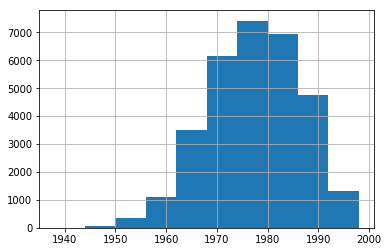

'2011 - NU_ANO_CONCLUSAO_1'

count    28797.000000
mean      1708.501788
std        706.252657
min         -1.000000
25%       1990.000000
50%       2000.000000
75%       2005.000000
max       2010.000000
Name: NU_ANO_CONCLUSAO_1, dtype: float64

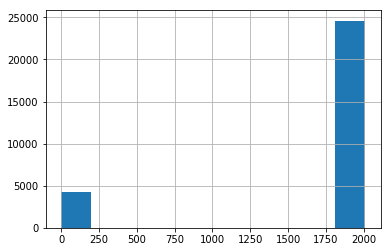

'2013 - NU_ANO_CONCLUSAO_1'

count    30000.000000
mean      1826.962100
std        565.868118
min         -1.000000
25%       1995.000000
50%       2003.000000
75%       2007.000000
max       2013.000000
Name: NU_ANO_CONCLUSAO_1, dtype: float64

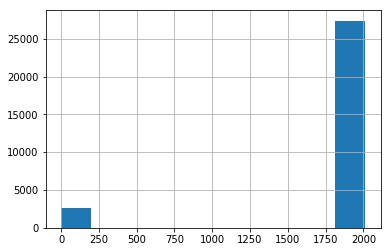

'2015 - NU_ANO_CONCLUSAO_1'

count    31866.000000
mean      1815.944800
std        583.425006
min         -1.000000
25%       1996.000000
50%       2004.000000
75%       2009.000000
max       2015.000000
Name: NU_ANO_CONCLUSAO_1, dtype: float64

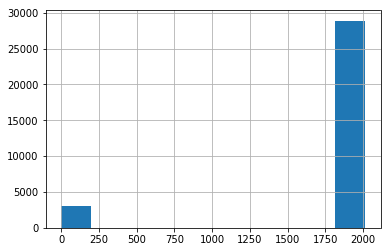

'2017 - NU_ANO_CONCLUSAO_1'

count    31590.000000
mean      1846.377208
std        541.038479
min         -1.000000
25%       1998.000000
50%       2005.000000
75%       2010.000000
max       2017.000000
Name: NU_ANO_CONCLUSAO_1, dtype: float64

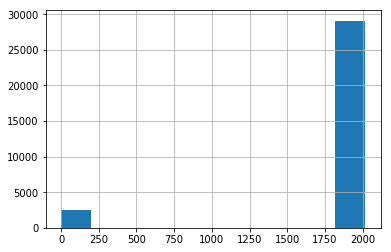

'2011 - NU_ANO_CONCLUSAO_2'

count    28797.000000
mean        49.904747
std        314.986595
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2010.000000
Name: NU_ANO_CONCLUSAO_2, dtype: float64

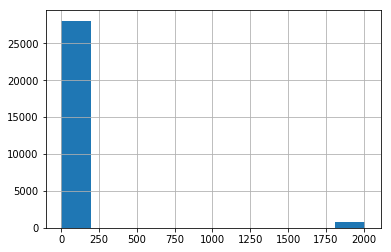

'2013 - NU_ANO_CONCLUSAO_2'

count    30000.000000
mean        45.025633
std        299.980901
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2012.000000
Name: NU_ANO_CONCLUSAO_2, dtype: float64

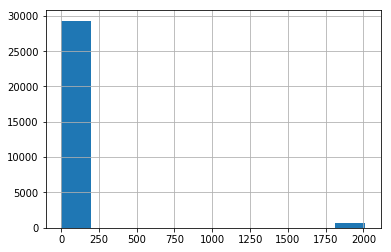

'2015 - NU_ANO_CONCLUSAO_2'

count    31866.000000
mean        45.563171
std        301.785550
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2015.000000
Name: NU_ANO_CONCLUSAO_2, dtype: float64

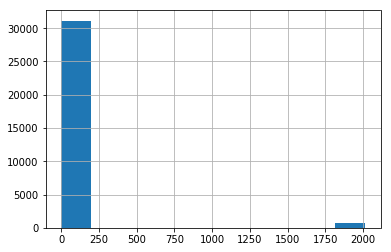

'2017 - NU_ANO_CONCLUSAO_2'

count    31590.000000
mean        52.814182
std        324.022532
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2017.000000
Name: NU_ANO_CONCLUSAO_2, dtype: float64

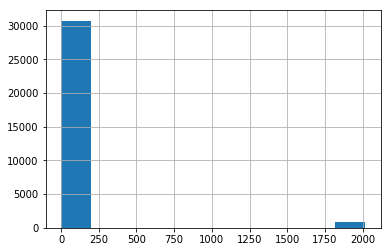

'2011 - NU_ANO_CONCLUSAO_3'

count    28797.000000
mean         0.526722
std         55.216348
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2009.000000
Name: NU_ANO_CONCLUSAO_3, dtype: float64

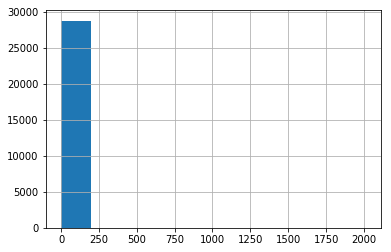

'2013 - NU_ANO_CONCLUSAO_3'

count    30000.000000
mean         0.732567
std         58.828528
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2012.000000
Name: NU_ANO_CONCLUSAO_3, dtype: float64

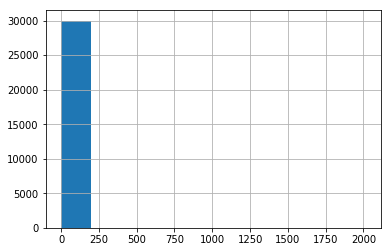

'2015 - NU_ANO_CONCLUSAO_3'

count    31866.000000
mean         1.071989
std         64.354866
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2015.000000
Name: NU_ANO_CONCLUSAO_3, dtype: float64

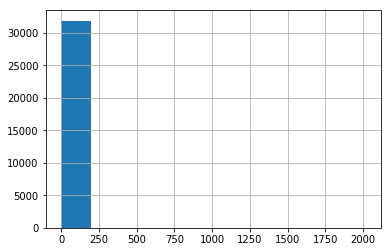

'2017 - NU_ANO_CONCLUSAO_3'

count    31590.000000
mean         1.157613
std         65.733518
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2016.000000
Name: NU_ANO_CONCLUSAO_3, dtype: float64

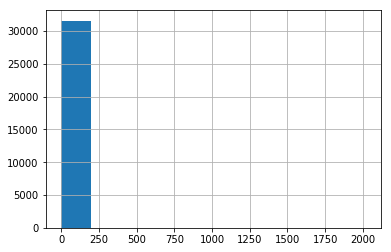

'2011 - NU_ANO_INICIO_1'

count    28797.000000
mean        27.894364
std        239.248804
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2011.000000
Name: NU_ANO_INICIO_1, dtype: float64

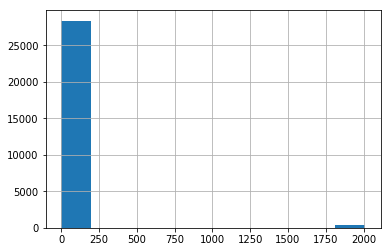

'2013 - NU_ANO_INICIO_1'

count    30000.000000
mean        57.846467
std        338.915278
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2013.000000
Name: NU_ANO_INICIO_1, dtype: float64

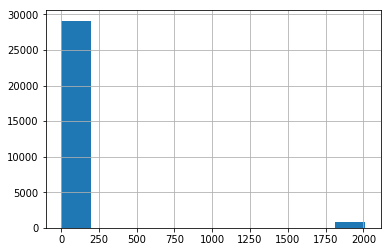

'2015 - NU_ANO_INICIO_1'

count    31866.000000
mean        61.042114
std        347.757577
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2015.000000
Name: NU_ANO_INICIO_1, dtype: float64

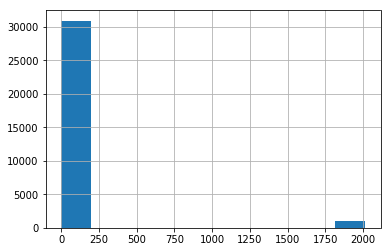

'2017 - NU_ANO_INICIO_1'

count    31590.000000
mean        64.976607
std        358.303715
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2017.000000
Name: NU_ANO_INICIO_1, dtype: float64

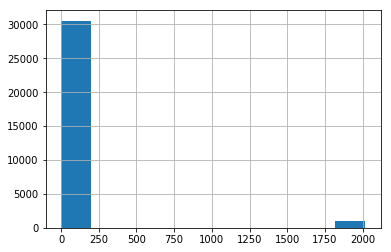

'2011 - NU_ANO_INICIO_2'

count    28797.000000
mean        -0.232559
std         39.259713
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2011.000000
Name: NU_ANO_INICIO_2, dtype: float64

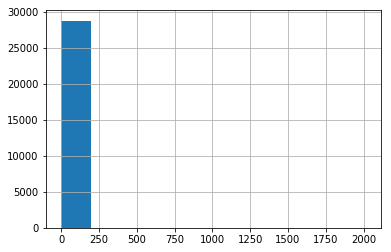

'2013 - NU_ANO_INICIO_2'

count    30000.000000
mean         0.206300
std         49.233057
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2013.000000
Name: NU_ANO_INICIO_2, dtype: float64

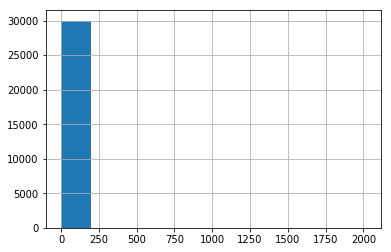

'2015 - NU_ANO_INICIO_2'

count    31866.000000
mean         0.831199
std         60.674996
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2015.000000
Name: NU_ANO_INICIO_2, dtype: float64

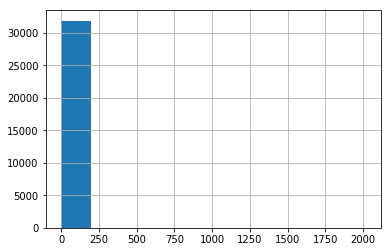

'2017 - NU_ANO_INICIO_2'

count    31590.000000
mean         0.656125
std         57.704537
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2017.000000
Name: NU_ANO_INICIO_2, dtype: float64

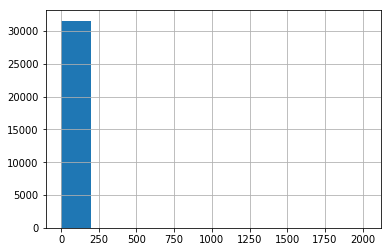

'2011 - NU_ANO_INICIO_3'

count    28797.000000
mean        -0.860541
std         16.733948
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2011.000000
Name: NU_ANO_INICIO_3, dtype: float64

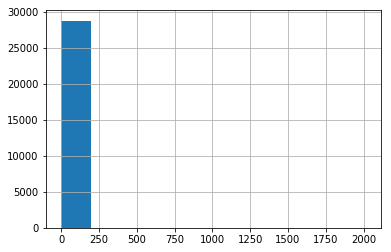

'2013 - NU_ANO_INICIO_3'

count    30000.000000
mean        -0.866133
std         16.395011
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2011.000000
Name: NU_ANO_INICIO_3, dtype: float64

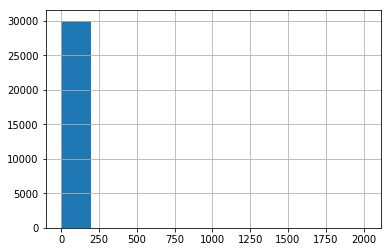

'2015 - NU_ANO_INICIO_3'

count    31866.000000
mean        -0.873596
std         15.955260
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2013.000000
Name: NU_ANO_INICIO_3, dtype: float64

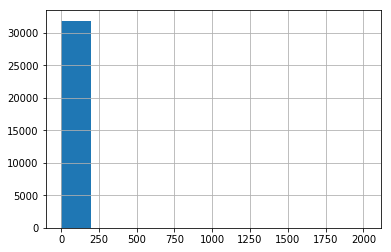

'2017 - NU_ANO_INICIO_3'

count    31590.000000
mean        -0.936119
std         11.353934
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max       2017.000000
Name: NU_ANO_INICIO_3, dtype: float64

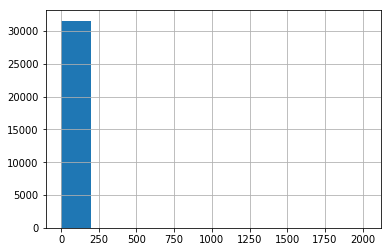

'2011 - NU_DIA'

count    28797.000000
mean        15.541723
std          8.778646
min          1.000000
25%          8.000000
50%         15.000000
75%         23.000000
max         31.000000
Name: NU_DIA, dtype: float64

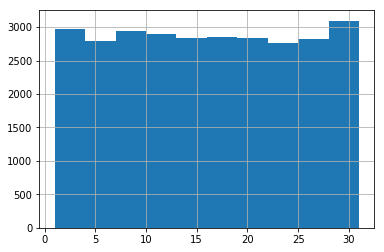

'2013 - NU_DIA'

count    30000.000000
mean        15.552033
std          8.800088
min          1.000000
25%          8.000000
50%         15.000000
75%         23.000000
max         31.000000
Name: NU_DIA, dtype: float64

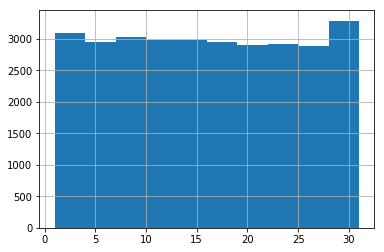

'2015 - NU_DIA'

count    31866.000000
mean        15.538379
std          8.805576
min          1.000000
25%          8.000000
50%         15.000000
75%         23.000000
max         31.000000
Name: NU_DIA, dtype: float64

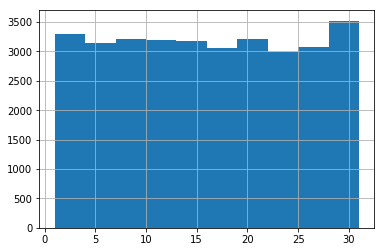

'2017 - NU_DIA'

count    31590.000000
mean        15.614910
std          8.756737
min          1.000000
25%          8.000000
50%         16.000000
75%         23.000000
max         31.000000
Name: NU_DIA, dtype: float64

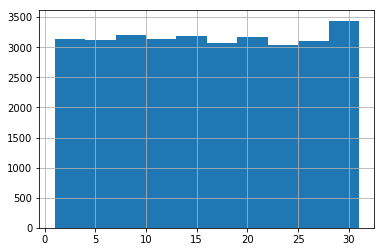

'2011 - NU_IDADE'

count    28797.000000
mean        38.514255
std          8.882436
min         16.000000
25%         32.000000
50%         38.000000
75%         45.000000
max         77.000000
Name: NU_IDADE, dtype: float64

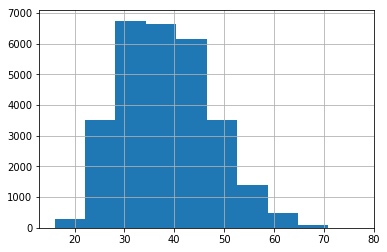

'2013 - NU_IDADE'

count    30000.000000
mean        39.091967
std          8.972052
min         15.000000
25%         32.000000
50%         38.000000
75%         45.000000
max         79.000000
Name: NU_IDADE, dtype: float64

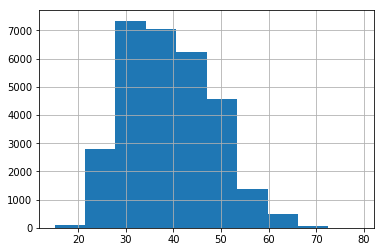

'2015 - NU_IDADE'

count    31866.000000
mean        39.688037
std          9.077185
min         17.000000
25%         33.000000
50%         39.000000
75%         46.000000
max         81.000000
Name: NU_IDADE, dtype: float64

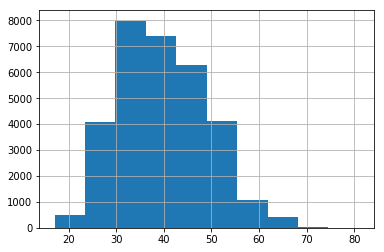

'2017 - NU_IDADE'

count    31590.000000
mean        40.106110
std          9.103734
min         19.000000
25%         33.000000
50%         40.000000
75%         47.000000
max         79.000000
Name: NU_IDADE, dtype: float64

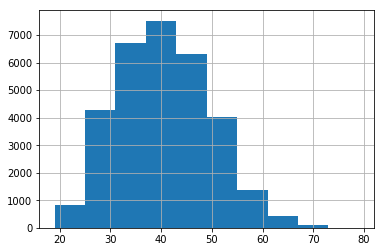

'2011 - NU_MES'

count    28797.000000
mean         6.481821
std          3.431517
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         12.000000
Name: NU_MES, dtype: float64

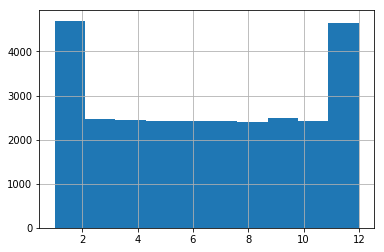

'2013 - NU_MES'

count    30000.000000
mean         6.496467
std          3.435527
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         12.000000
Name: NU_MES, dtype: float64

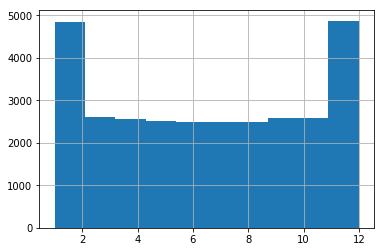

'2015 - NU_MES'

count    31866.000000
mean         6.496517
std          3.441115
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         12.000000
Name: NU_MES, dtype: float64

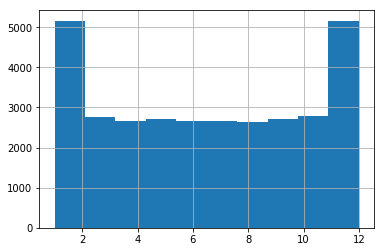

'2017 - NU_MES'

count    31590.000000
mean         6.497373
std          3.427479
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         12.000000
Name: NU_MES, dtype: float64

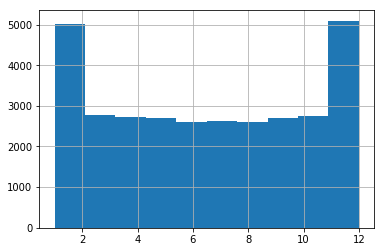

'2011 - TP_COR_RACA'

0    11593
1     8726
3     7187
2     1085
4      164
5       42
Name: TP_COR_RACA, dtype: int64

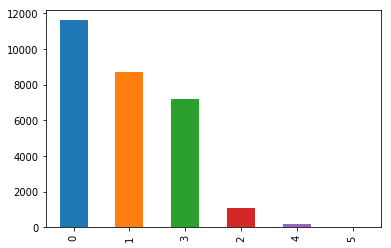

'2013 - TP_COR_RACA'

0    10785
1     9400
3     8363
2     1234
4      186
5       32
Name: TP_COR_RACA, dtype: int64

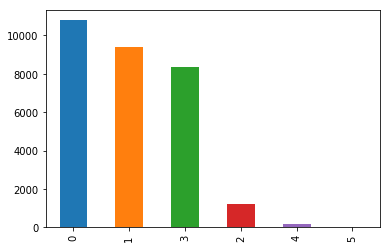

'2015 - TP_COR_RACA'

0    11158
1     9884
3     9224
2     1383
4      185
5       32
Name: TP_COR_RACA, dtype: int64

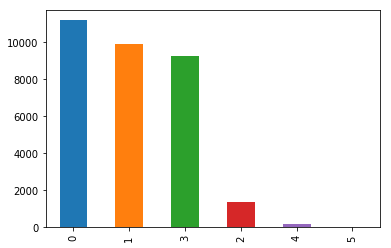

'2017 - TP_COR_RACA'

0    11030
1     9522
3     9309
2     1478
4      209
5       42
Name: TP_COR_RACA, dtype: int64

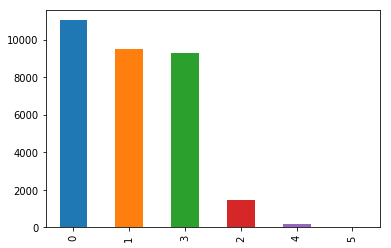

'2011 - TP_ESCOLARIDADE'

6    25013
3     2701
5     1044
4       17
2       16
1        6
Name: TP_ESCOLARIDADE, dtype: int64

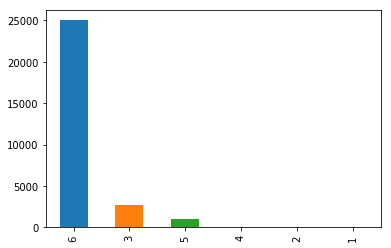

'2013 - TP_ESCOLARIDADE'

6    28255
3     1248
5      485
4        7
2        5
Name: TP_ESCOLARIDADE, dtype: int64

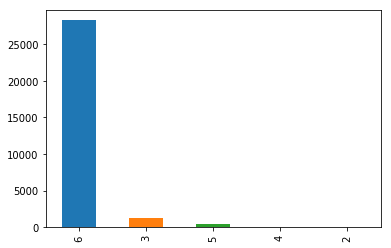

'2015 - TP_ESCOLARIDADE'

4    28901
3     2950
2       14
1        1
Name: TP_ESCOLARIDADE, dtype: int64

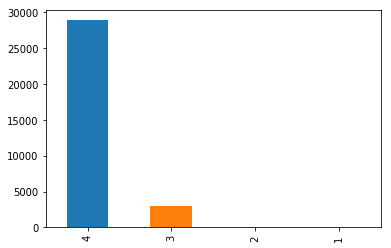

'2017 - TP_ESCOLARIDADE'

4    29120
3     2438
2       29
1        3
Name: TP_ESCOLARIDADE, dtype: int64

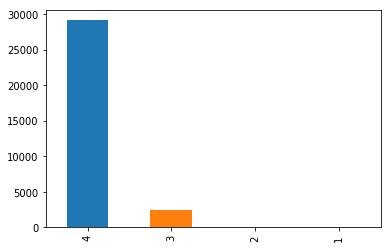

'2011 - TP_NACIONALIDADE'

1    28708
3       68
2       21
Name: TP_NACIONALIDADE, dtype: int64

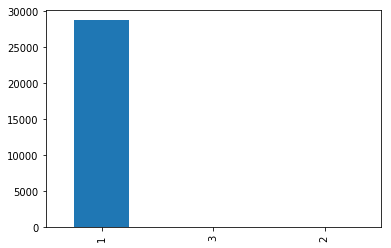

'2013 - TP_NACIONALIDADE'

1    29902
3       70
2       28
Name: TP_NACIONALIDADE, dtype: int64

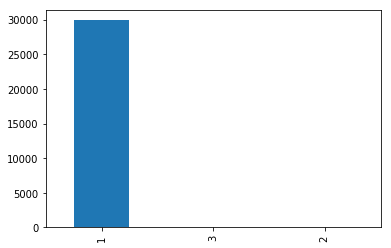

'2015 - TP_NACIONALIDADE'

1    31775
3       60
2       31
Name: TP_NACIONALIDADE, dtype: int64

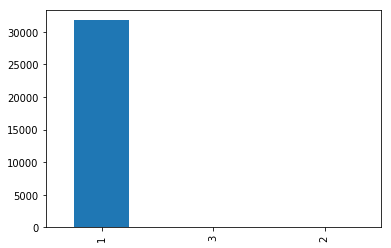

'2017 - TP_NACIONALIDADE'

1    31452
3      105
2       33
Name: TP_NACIONALIDADE, dtype: int64

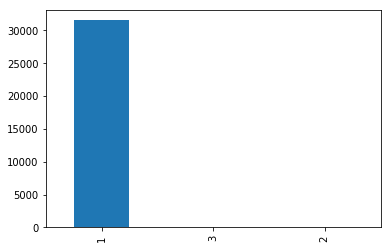

'2011 - TP_SEXO'

F    22555
M     6242
Name: TP_SEXO, dtype: int64

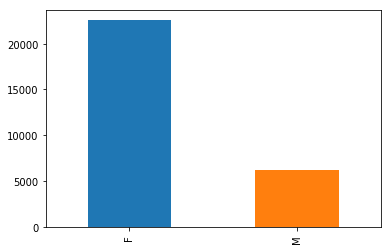

'2013 - TP_SEXO'

F    23166
M     6834
Name: TP_SEXO, dtype: int64

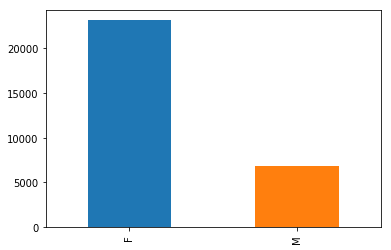

'2015 - TP_SEXO'

2    24306
1     7560
Name: TP_SEXO, dtype: int64

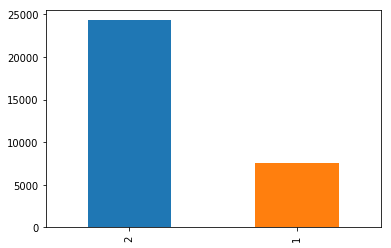

'2017 - TP_SEXO'

2    23726
1     7864
Name: TP_SEXO, dtype: int64

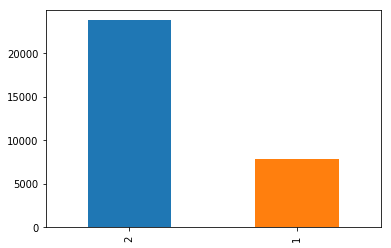

'2011 - TP_SITUACAO_CURSO_1'

 1    24599
-1     3784
 2      414
Name: TP_SITUACAO_CURSO_1, dtype: int64

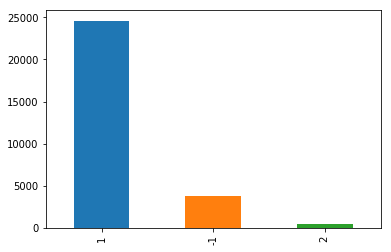

'2013 - TP_SITUACAO_CURSO_1'

 1    27377
-1     1745
 2      878
Name: TP_SITUACAO_CURSO_1, dtype: int64

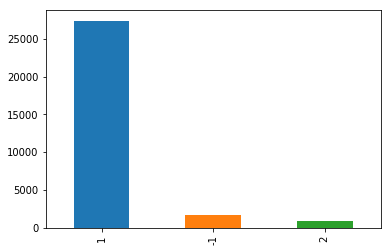

'2015 - TP_SITUACAO_CURSO_1'

 1    28888
-1     1995
 2      983
Name: TP_SITUACAO_CURSO_1, dtype: int64

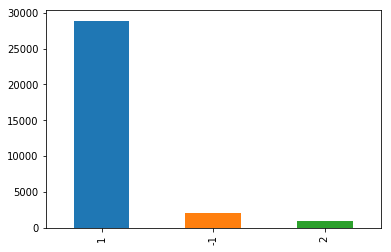

'2017 - TP_SITUACAO_CURSO_1'

 1    29095
-1     1459
 2     1036
Name: TP_SITUACAO_CURSO_1, dtype: int64

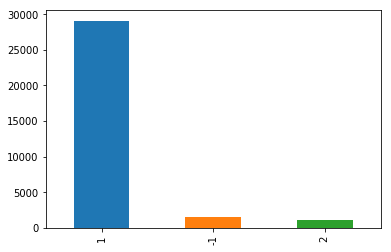

'2011 - TP_SITUACAO_CURSO_2'

-1    28053
 1      733
 2       11
Name: TP_SITUACAO_CURSO_2, dtype: int64

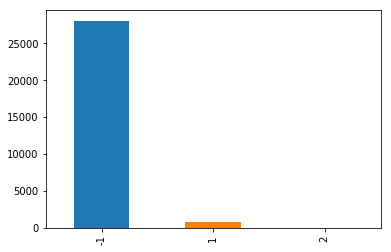

'2013 - TP_SITUACAO_CURSO_2'

-1    29292
 1      690
 2       18
Name: TP_SITUACAO_CURSO_2, dtype: int64

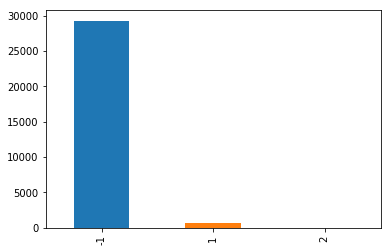

'2015 - TP_SITUACAO_CURSO_2'

-1    31096
 1      741
 2       29
Name: TP_SITUACAO_CURSO_2, dtype: int64

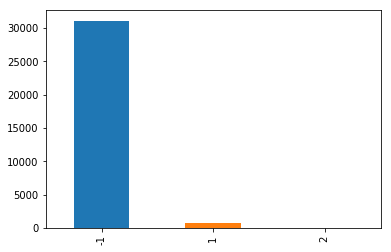

'2017 - TP_SITUACAO_CURSO_2'

-1    30716
 1      848
 2       26
Name: TP_SITUACAO_CURSO_2, dtype: int64

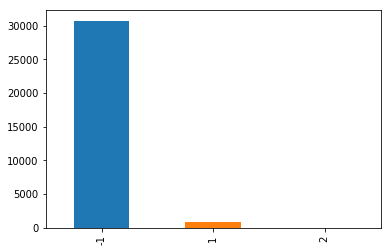

'2011 - TP_SITUACAO_CURSO_3'

-1    28773
 1       22
 2        2
Name: TP_SITUACAO_CURSO_3, dtype: int64

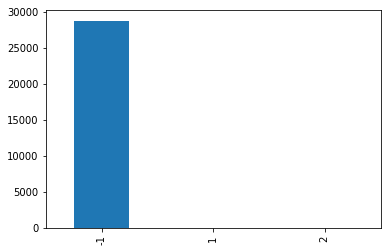

'2013 - TP_SITUACAO_CURSO_3'

-1    29972
 1       26
 2        2
Name: TP_SITUACAO_CURSO_3, dtype: int64

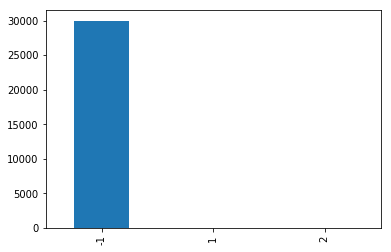

'2015 - TP_SITUACAO_CURSO_3'

-1    31831
 1       33
 2        2
Name: TP_SITUACAO_CURSO_3, dtype: int64

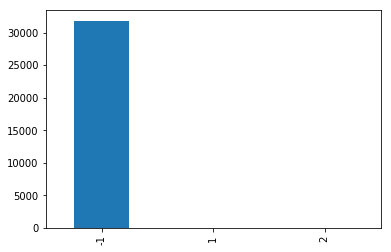

'2017 - TP_SITUACAO_CURSO_3'

-1    31555
 1       34
 2        1
Name: TP_SITUACAO_CURSO_3, dtype: int64

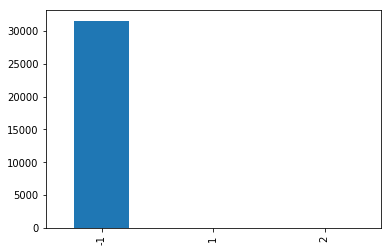

'2011 - TP_TIPO_IES_1'

 2    17539
 1     7474
-1     3784
Name: TP_TIPO_IES_1, dtype: int64

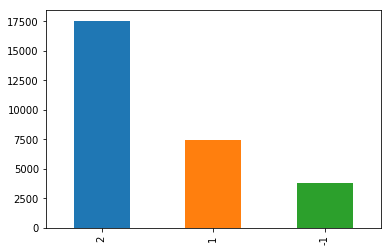

'2013 - TP_TIPO_IES_1'

 2    19958
 1     8297
-1     1745
Name: TP_TIPO_IES_1, dtype: int64

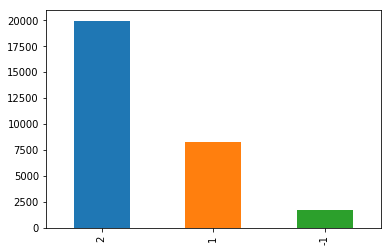

'2015 - TP_TIPO_IES_1'

 2    15113
 1    14758
-1     1995
Name: TP_TIPO_IES_1, dtype: int64

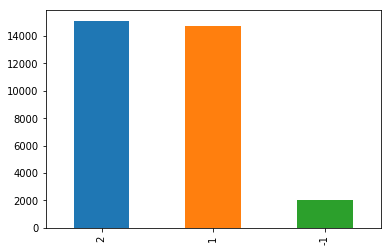

'2017 - TP_TIPO_IES_1'

 2    16240
-1     7903
 1     7447
Name: TP_TIPO_IES_1, dtype: int64

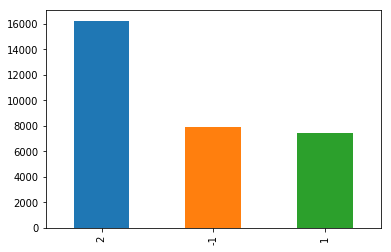

'2011 - TP_TIPO_IES_2'

-1    28053
 2      561
 1      183
Name: TP_TIPO_IES_2, dtype: int64

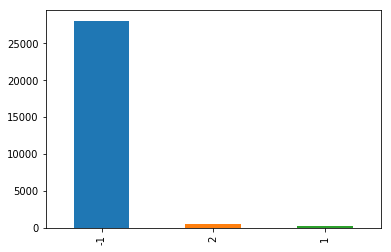

'2013 - TP_TIPO_IES_2'

-1    29292
 2      519
 1      189
Name: TP_TIPO_IES_2, dtype: int64

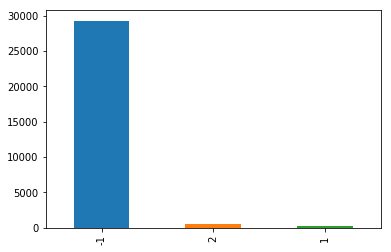

'2015 - TP_TIPO_IES_2'

-1    31096
 1      422
 2      348
Name: TP_TIPO_IES_2, dtype: int64

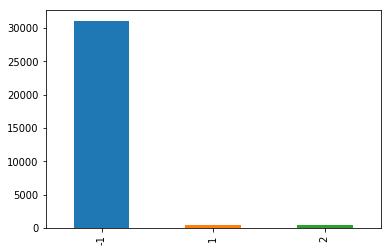

'2017 - TP_TIPO_IES_2'

-1    30926
 2      484
 1      180
Name: TP_TIPO_IES_2, dtype: int64

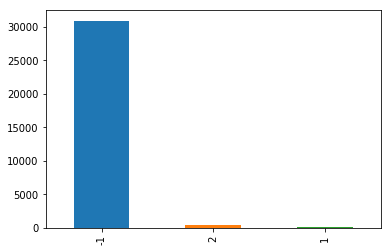

'2011 - TP_TIPO_IES_3'

-1    28773
 2       14
 1       10
Name: TP_TIPO_IES_3, dtype: int64

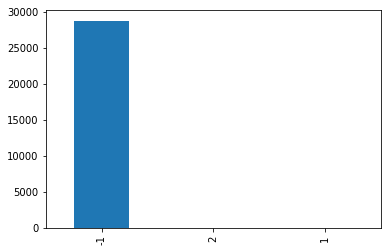

'2013 - TP_TIPO_IES_3'

-1    29972
 2       18
 1       10
Name: TP_TIPO_IES_3, dtype: int64

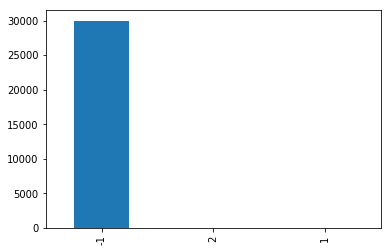

'2015 - TP_TIPO_IES_3'

-1    31831
 1       21
 2       14
Name: TP_TIPO_IES_3, dtype: int64

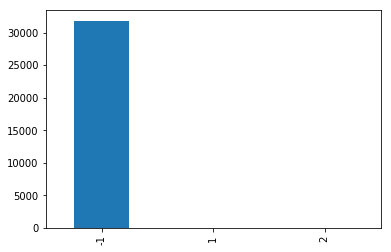

'2017 - TP_TIPO_IES_3'

-1    31562
 2       21
 1        7
Name: TP_TIPO_IES_3, dtype: int64

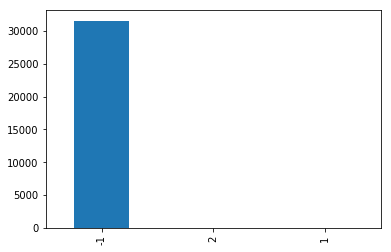

'2011 - IN_CIDADE_NATAL'

0    14553
1    14244
Name: IN_CIDADE_NATAL, dtype: int64

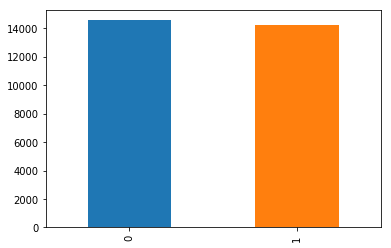

'2013 - IN_CIDADE_NATAL'

1    15319
0    14681
Name: IN_CIDADE_NATAL, dtype: int64

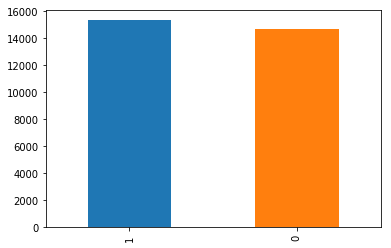

'2015 - IN_CIDADE_NATAL'

0    19129
1    12737
Name: IN_CIDADE_NATAL, dtype: int64

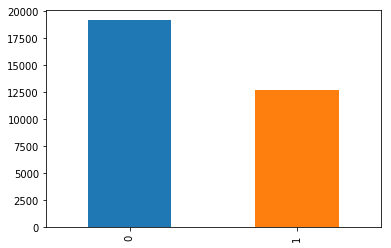

'2017 - IN_CIDADE_NATAL'

1    16028
0    15562
Name: IN_CIDADE_NATAL, dtype: int64

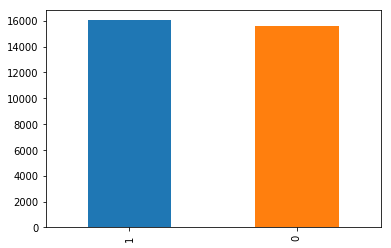

'2011 - NUM_TTL_GRAD'

count    28797.000000
mean         0.880439
std          0.398259
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: NUM_TTL_GRAD, dtype: float64

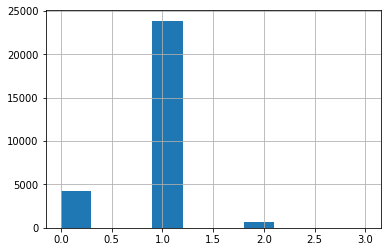

'2013 - NUM_TTL_GRAD'

count    30000.000000
mean         0.936433
std          0.328425
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: NUM_TTL_GRAD, dtype: float64

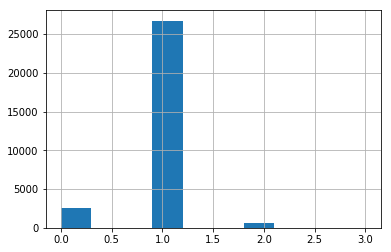

'2015 - NUM_TTL_GRAD'

count    31866.000000
mean         0.930835
std          0.337962
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: NUM_TTL_GRAD, dtype: float64

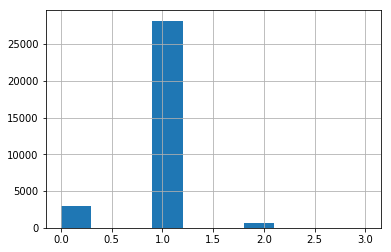

'2017 - NUM_TTL_GRAD'

count    31590.000000
mean         0.948940
std          0.323734
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: NUM_TTL_GRAD, dtype: float64

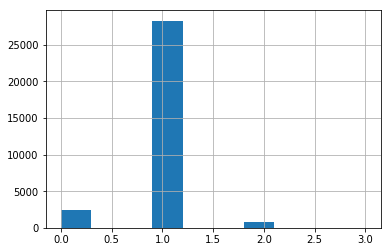

'2011 - NUM_QTD_ESCOLAS'

count    28797.000000
mean         1.102129
std          0.339582
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          7.000000
Name: NUM_QTD_ESCOLAS, dtype: float64

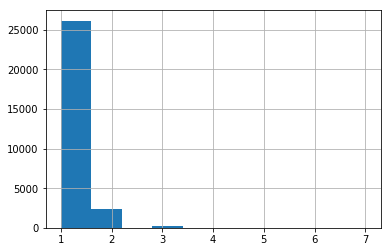

'2013 - NUM_QTD_ESCOLAS'

count    30000.000000
mean         1.102833
std          0.350708
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: NUM_QTD_ESCOLAS, dtype: float64

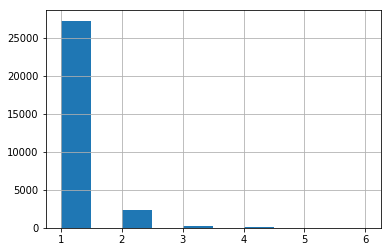

'2015 - NUM_QTD_ESCOLAS'

count    31866.000000
mean         1.097408
std          0.347940
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: NUM_QTD_ESCOLAS, dtype: float64

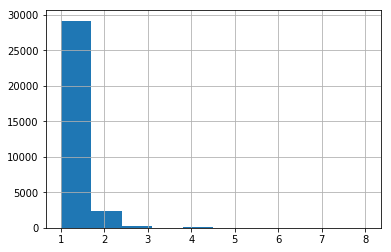

'2017 - NUM_QTD_ESCOLAS'

count    31590.000000
mean         1.106046
std          0.368723
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          7.000000
Name: NUM_QTD_ESCOLAS, dtype: float64

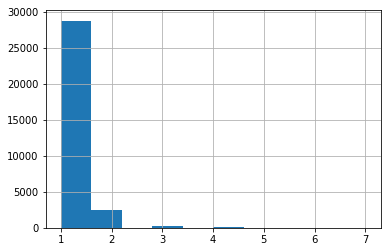

'2011 - NUM_QTD_TURMAS'

count    28797.000000
mean         5.037921
std          5.705981
min          1.000000
25%          1.000000
50%          2.000000
75%          8.000000
max         61.000000
Name: NUM_QTD_TURMAS, dtype: float64

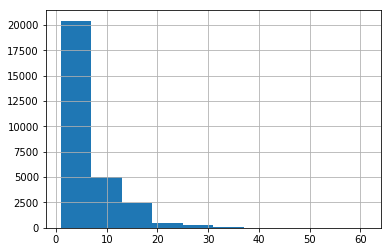

'2013 - NUM_QTD_TURMAS'

count    30000.000000
mean         4.954500
std          5.545303
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max         67.000000
Name: NUM_QTD_TURMAS, dtype: float64

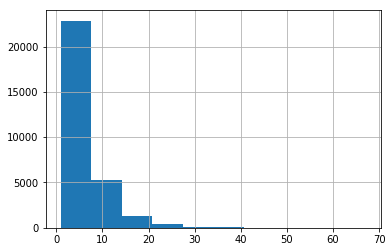

'2015 - NUM_QTD_TURMAS'

count    31866.000000
mean         4.937425
std          5.395459
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max         67.000000
Name: NUM_QTD_TURMAS, dtype: float64

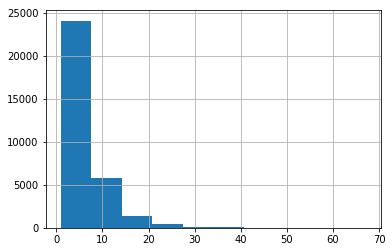

'2017 - NUM_QTD_TURMAS'

count    31590.000000
mean         4.834600
std          5.289997
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max         70.000000
Name: NUM_QTD_TURMAS, dtype: float64

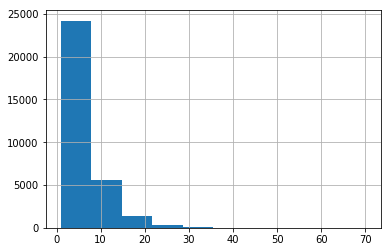

'2011 - IN_LECIONA_PUBLICA'

1    28797
Name: IN_LECIONA_PUBLICA, dtype: int64

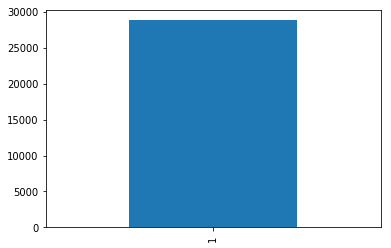

'2013 - IN_LECIONA_PUBLICA'

1    30000
Name: IN_LECIONA_PUBLICA, dtype: int64

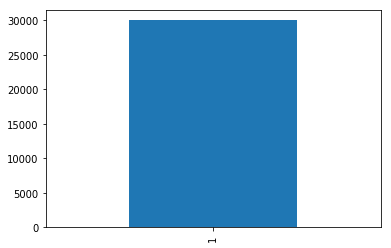

'2015 - IN_LECIONA_PUBLICA'

1    31866
Name: IN_LECIONA_PUBLICA, dtype: int64

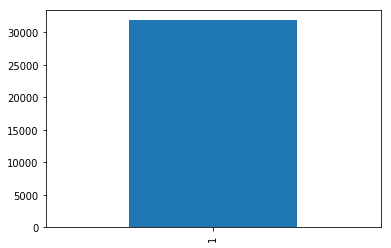

'2017 - IN_LECIONA_PUBLICA'

1    31590
Name: IN_LECIONA_PUBLICA, dtype: int64

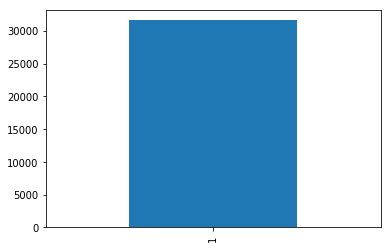

'2011 - IN_LECIONA_PRIVADA'

0    28797
Name: IN_LECIONA_PRIVADA, dtype: int64

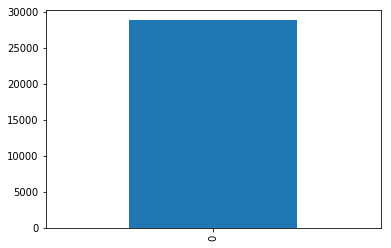

'2013 - IN_LECIONA_PRIVADA'

0    30000
Name: IN_LECIONA_PRIVADA, dtype: int64

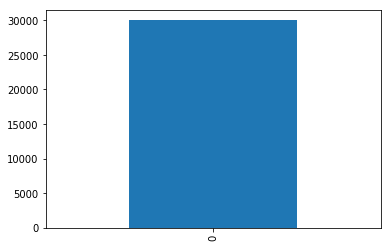

'2015 - IN_LECIONA_PRIVADA'

0    21943
1     9923
Name: IN_LECIONA_PRIVADA, dtype: int64

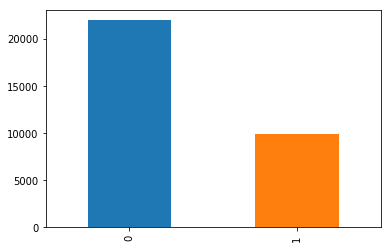

'2017 - IN_LECIONA_PRIVADA'

0    21702
1     9888
Name: IN_LECIONA_PRIVADA, dtype: int64

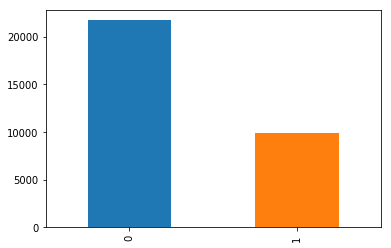

In [114]:
for c in pss_ano.columns[2:]:
    if not c.startswith('CO'):
        for a in anos_pesquisa:
            display(a + ' - ' + c)
            if c.startswith('NU'):
                display(pss_ano.loc[pss_ano.ANO == int(a)][c].describe())
                pss_ano.loc[pss_ano.ANO == int(a)][c].hist()
            else:
                display(pss_ano.loc[pss_ano.ANO == int(a)][c].value_counts())
                pss_ano.loc[pss_ano.ANO == int(a)][c].value_counts().plot.bar()
            plt.show()
            #sns.barplot()
    


### Taxa de rotatividade de professores entre 2 anos .  




In [201]:
def monta_saidas(pt, ano,turmas=[]):
    pe_ano = pt.loc[(pt.TP_DEPENDENCIA < 4) & (pt.ANO == int(ano)) & ((len(turmas)==0) | (pt.CO_ENTIDADE.isin(turmas)))][['CO_PESSOA_FISICA','CO_ENTIDADE']].drop_duplicates()
    pe_fut = pt.loc[(pt.TP_DEPENDENCIA < 4) & ((len(turmas)==0) | (pt.CO_ENTIDADE.isin(turmas))) & (pt.ANO == int(anos_pesquisa[anos_pesquisa.index(str(ano))+1])) & pt.CO_PESSOA_FISICA.isin(pe_ano.CO_PESSOA_FISICA.unique())][['CO_PESSOA_FISICA','CO_ENTIDADE']].drop_duplicates()
    pe_ano = pe_ano.loc[pe_ano.CO_PESSOA_FISICA.isin(pe_fut.CO_PESSOA_FISICA.unique())]
    to = pe_ano.merge(pe_fut,indicator=True,on=['CO_PESSOA_FISICA','CO_ENTIDADE'],how='outer')
    #vamos manter somente as escolas que estavam abertas nos 2 periodos
    to = to.loc[to._merge =='left_only']
    return to[['CO_PESSOA_FISICA','CO_ENTIDADE']],pe_ano,pe_fut

for ano in anos_pesquisa[:-1]:
    t,a,f = monta_saidas(prof_df,ano)
    p = t.shape[0]/a.shape[0] * 100
    display(f'{ano}/{int(ano)+2} havia {a.shape[0]} professores/escola, houve {t.shape[0]} saidas ({p}%)');


'2011/2013 havia 22023 professores/escola, houve 7350 saidas (33.374199700313305%)'

'2013/2015 havia 16649 professores/escola, houve 6493 saidas (38.999339299657635%)'

'2015/2017 havia 15525 professores/escola, houve 5460 saidas (35.169082125603865%)'

### Como  o turnover total foi estável no período iremos modelar somente com o biênio 2015/2017

##### Importando dados de escolas e turmas de escolas publicas em funcionamento do DF

In [180]:
def imp_esc_dist_atv_df(ano):
    d_esc = pd.read_csv(f'{ARQ_PATH}{ano}/ESCOLAS.CSV',sep='|',encoding='latin1',low_memory=False)
    d_esc.fillna(-1,inplace=True)
    d_esc = ajusta_colunas_int_docentes(d_esc,vai_printar_cols=False)
    d_esc['ANO'] = ano
    return d_esc.loc[(d_esc.CO_UF == 53) & (d_esc.TP_SITUACAO_FUNCIONAMENTO == 1) & (d_esc.TP_DEPENDENCIA == 2)]

escolas = imp_esc_dist_atv_df(2017).append(imp_esc_dist_atv_df(2015))

escolas.head()

Coluna com erro  NO_ENTIDADE
Coluna com erro  CO_ORGAO_REGIONAL
Coluna com erro  DT_ANO_LETIVO_INICIO
Coluna com erro  DT_ANO_LETIVO_TERMINO
Coluna com erro  NO_ENTIDADE
Coluna com erro  CO_ORGAO_REGIONAL
Coluna com erro  DT_ANO_LETIVO_INICIO
Coluna com erro  DT_ANO_LETIVO_TERMINO


,NU_ANO_CENSO,CO_ENTIDADE,NO_ENTIDADE,CO_ORGAO_REGIONAL,TP_SITUACAO_FUNCIONAMENTO,DT_ANO_LETIVO_INICIO,DT_ANO_LETIVO_TERMINO,CO_REGIAO,CO_MESORREGIAO,CO_MICRORREGIAO,...,IN_ESP_EXCLUSIVA_MEDIO_NORMAL,IN_COMUM_EJA_FUND,IN_COMUM_EJA_MEDIO,IN_COMUM_EJA_PROF,IN_ESP_EXCLUSIVA_EJA_FUND,IN_ESP_EXCLUSIVA_EJA_MEDIO,IN_ESP_EXCLUSIVA_EJA_PROF,IN_COMUM_PROF,IN_ESP_EXCLUSIVA_PROF,ANO
525,2017,53003055,EC PONTE ALTA DE CIMA,00002,1,10/02/2017,21/12/2017,5,5301,53001,...,0,0,0,0,0,0,0,0,0,2017
541,2017,53004310,EC 50 DE TAGUATINGA,00003,1,10/02/2017,21/12/2017,5,5301,53001,...,0,0,0,0,0,0,0,0,0,2017
790,2017,53009100,CEI 307 DE SAMAMBAIA,00010,1,10/02/2017,21/12/2017,5,5301,53001,...,0,0,0,0,0,0,0,0,0,2017
795,2017,53007077,CEM 01 DO NUCLEO BANDEIRANTE,00007,1,10/02/2017,21/12/2017,5,5301,53001,...,0,1,1,0,0,0,0,0,0,2017
1093,2017,53009118,EC 317 DE SAMAMBAIA,00010,1,10/02/2017,21/12/2017,5,5301,53001,...,0,0,0,0,0,0,0,0,0,2017


In [183]:
def imp_turma_esc_atv_df(ano,escolas):
    d_tur = pd.read_csv(f'{ARQ_PATH}{ano}/TURMAS.CSV',sep='|',encoding='latin1',low_memory=False)
    d_tur.fillna(-1,inplace=True)
    d_tur = ajusta_colunas_int_docentes(d_tur,vai_printar_cols=False)
    d_tur['ANO'] = ano
    return d_tur.loc[(d_tur.CO_ENTIDADE.isin(escolas))]


In [186]:
turmas = imp_turma_esc_atv_df(2015,escolas.loc[escolas.ANO == 2015].CO_ENTIDADE.unique())\
        .append(imp_turma_esc_atv_df(2017,escolas.loc[escolas.ANO == 2017].CO_ENTIDADE.unique()))

Coluna com erro  NO_TURMA
Coluna com erro  NO_TURMA


/home/itsbarreto/.local/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [198]:
display(turmas.dtypes)
turmas.head()

ANO                               int64
CO_CURSO_EDUC_PROFISSIONAL        int16
CO_DISTRITO                       int32
CO_ENTIDADE                       int32
CO_MESORREGIAO                    int16
CO_MICRORREGIAO                   int32
CO_MUNICIPIO                      int32
CO_REGIAO                          int8
CO_TIPO_ATIVIDADE_1               int32
CO_TIPO_ATIVIDADE_2               int32
CO_TIPO_ATIVIDADE_3               int32
CO_TIPO_ATIVIDADE_4               int32
CO_TIPO_ATIVIDADE_5               int32
CO_TIPO_ATIVIDADE_6               int32
CO_UF                              int8
ID_TURMA                          int32
IN_AUTONOMIA_ESCOLAR               int8
IN_BRAILLE                         int8
IN_COMUNICACAO_ALT_AUMENT          int8
IN_CONVENIADA_PP                   int8
IN_DIA_SEMANA_DOMINGO              int8
IN_DIA_SEMANA_QUARTA               int8
IN_DIA_SEMANA_QUINTA               int8
IN_DIA_SEMANA_SABADO               int8
IN_DIA_SEMANA_SEGUNDA              int8


,ANO,CO_CURSO_EDUC_PROFISSIONAL,CO_DISTRITO,CO_ENTIDADE,CO_MESORREGIAO,CO_MICRORREGIAO,CO_MUNICIPIO,CO_REGIAO,CO_TIPO_ATIVIDADE_1,CO_TIPO_ATIVIDADE_2,...,TP_CONVENIO_PODER_PUBLICO,TP_DEPENDENCIA,TP_ETAPA_ENSINO,TP_LOCALIZACAO,TP_LOCALIZACAO_DIFERENCIADA,TP_MEDIACAO_DIDATICO_PEDAGO,TP_REGULAMENTACAO,TP_TIPO_TURMA,TX_HR_INICIAL,TX_MI_INICIAL
2,2015,-1,530010805,53005953,5301,53001,5300108,5,-1,-1,...,-1,2,2,1,0,1,1,0,7,30
9,2015,-1,530010805,53005015,5301,53001,5300108,5,-1,-1,...,-1,2,26,1,0,1,1,0,13,0
29,2015,-1,530010805,53009649,5301,53001,5300108,5,-1,-1,...,-1,2,15,1,0,1,1,0,12,45
30,2015,-1,530010805,53009649,5301,53001,5300108,5,-1,-1,...,-1,2,15,1,0,1,1,0,12,45
31,2015,-1,530010805,53009649,5301,53001,5300108,5,-1,-1,...,-1,2,16,1,0,1,1,0,12,45


In [228]:
escolas.to_csv(f'{ARQ_PATH}escolas_distritais_15_17_func_df.csv',index=False)
turmas.to_csv(f'{ARQ_PATH}turmas_df.csv',index=False)

In [6]:
escolas = pd.read_csv(f'{ARQ_PATH}escolas_distritais_15_17_func_df.csv',low_memory=False)
turmas = pd.read_csv(f'{ARQ_PATH}turmas_df.csv',low_memory=False)

In [203]:
#escolas distritais que estavam funcionamento em 2015 e 2017
e17 = escolas.loc[(escolas.ANO == 2017)]['CO_ENTIDADE'].unique()
co_e15_17 = escolas.loc[(escolas.ANO == 2015) & (escolas.CO_ENTIDADE.isin(e17))]['CO_ENTIDADE'].unique()
display(len(e17))
display(len(co_e15_17))

676

660

In [235]:
#turnover 2015 em escolas em funcionamento
ano = 2015
t,a,f = monta_saidas(prof_df,ano,turmas=co_e15_17)
p = t.shape[0]/a.shape[0] * 100
display(f'{ano}/{int(ano)+2} havia {a.shape[0]} professores/escola, houve {t.shape[0]} saidas ({p}%)');


'2015/2017 havia 15034 professores/escola, houve 5293 saidas (35.20686444060131%)'

### Temos a target!



In [236]:
a = a.merge(t,on=['CO_ENTIDADE','CO_PESSOA_FISICA'],indicator=True,how='left')
a['target'] = a._merge == 'both'
a.drop('_merge',axis=1,inplace=True)
a['ano'] = 2015
display(a.target.value_counts())


False    9741
True     5293
Name: target, dtype: int64

In [237]:
a.to_csv(f'{ARQ_PATH}prof_escola_target.csv',index=False)

<table columns=2 style='width:100%'><tr><td>
<img src='img/cp_icon.png'/></td><td> <h2>Check-point, importando os DataFrames para criação de features.</h2></td></tr></table>

In [105]:
escolas = ajusta_colunas_int_docentes(pd.read_csv(f'{ARQ_PATH}escolas_distritais_15_17_func_df.csv',low_memory=False),vai_printar_cols=False)
turmas = ajusta_colunas_int_docentes(pd.read_csv(f'{ARQ_PATH}turmas_df.csv',low_memory=False),vai_printar_cols=False)
prof_df = ajusta_colunas_int_docentes(pd.read_csv(f'{ARQ_PATH}prof_df.csv',low_memory=False),vai_printar_cols=False)
pss_ano= ajusta_colunas_int_docentes(pd.read_csv(f'{ARQ_PATH}pessoas_prof_df.csv',low_memory=False),vai_printar_cols=False)
pet = ajusta_colunas_int_docentes(pd.read_csv(f'{ARQ_PATH}prof_escola_target.csv',low_memory=False),vai_printar_cols=False)

Coluna com erro  NO_ENTIDADE
Coluna com erro  DT_ANO_LETIVO_INICIO
Coluna com erro  DT_ANO_LETIVO_TERMINO
Coluna com erro  NO_TURMA
Coluna com erro  TP_SEXO
Coluna com erro  CO_CURSO_1
Coluna com erro  CO_CURSO_2
Coluna com erro  CO_CURSO_3
Coluna com erro  CO_CURSO_1
Coluna com erro  CO_CURSO_2
Coluna com erro  CO_CURSO_3
Coluna com erro  TP_SEXO


## Criação de features para o estudo

- Localizacao:
    * criminalidade
    * linhas de onibus
    * contexto social (setor censitario)
- Infra da escola
    * situacao da escola
- Turma
    * alunos
    * disciplina da turma x displina de formacao




#### Iremos começar com os dados que já temos (escolas e turmas).

- Selecionando features das escolas, professores e turmas.

In [106]:
list(map(print,prof_df.columns));


CO_PESSOA_FISICA
NU_DIA
NU_MES
NU_ANO
NU_IDADE
TP_SEXO
TP_COR_RACA
TP_NACIONALIDADE
CO_PAIS_ORIGEM
CO_UF_NASC
CO_MUNICIPIO_NASC
CO_UF_END
CO_MUNICIPIO_END
TP_ESCOLARIDADE
TP_SITUACAO_CURSO_1
CO_AREA_CURSO_1
CO_CURSO_1
IN_LICENCIATURA_1
IN_COM_PEDAGOGICA_1
NU_ANO_INICIO_1
NU_ANO_CONCLUSAO_1
TP_TIPO_IES_1
CO_IES_1
TP_SITUACAO_CURSO_2
CO_AREA_CURSO_2
CO_CURSO_2
IN_LICENCIATURA_2
IN_COM_PEDAGOGICA_2
NU_ANO_INICIO_2
NU_ANO_CONCLUSAO_2
TP_TIPO_IES_2
CO_IES_2
TP_SITUACAO_CURSO_3
CO_AREA_CURSO_3
CO_CURSO_3
IN_LICENCIATURA_3
IN_COM_PEDAGOGICA_3
NU_ANO_INICIO_3
NU_ANO_CONCLUSAO_3
TP_TIPO_IES_3
CO_IES_3
IN_DISC_QUIMICA
IN_DISC_FISICA
IN_DISC_MATEMATICA
IN_DISC_BIOLOGIA
IN_DISC_CIENCIAS
IN_DISC_LINGUA_PORTUGUESA
IN_DISC_LINGUA_INGLES
IN_DISC_LINGUA_ESPANHOL
IN_DISC_LINGUA_OUTRA
IN_DISC_LINGUA_INDIGENA
IN_DISC_ARTES
IN_DISC_EDUCACAO_FISICA
IN_DISC_HISTORIA
IN_DISC_GEOGRAFIA
IN_DISC_FILOSOFIA
IN_DISC_ENSINO_RELIGIOSO
IN_DISC_INFORMATICA_COMPUTACAO
IN_DISC_PROFISSIONALIZANTE
IN_DISC_ATENDIMENTO_ESPEC

In [107]:
list(map(print,turmas.columns))
cols_sel = [
    'CO_TIPO_ATIVIDADE_1',    'CO_TIPO_ATIVIDADE_2',    'CO_TIPO_ATIVIDADE_3',
'CO_TIPO_ATIVIDADE_4','CO_TIPO_ATIVIDADE_5','CO_TIPO_ATIVIDADE_6',
'ID_TURMA','IN_AUTONOMIA_ESCOLAR','IN_BRAILLE',
'IN_COMUNICACAO_ALT_AUMENT','IN_CONVENIADA_PP',
'IN_DIA_SEMANA_DOMINGO','IN_DIA_SEMANA_QUARTA',
'IN_DIA_SEMANA_QUINTA','IN_DIA_SEMANA_SABADO',
'IN_DIA_SEMANA_SEGUNDA','IN_DIA_SEMANA_SEXTA',
'IN_DIA_SEMANA_TERCA','IN_DISC_ARTES',
'IN_DISC_ATENDIMENTO_ESPECIAIS','IN_DISC_BIOLOGIA',
'IN_DISC_CIENCIAS','IN_DISC_DIVER_SOCIO_CULTURAL',
'IN_DISC_EDUCACAO_FISICA','IN_DISC_ENSINO_RELIGIOSO',
'IN_DISC_ESTUDOS_SOCIAIS','IN_DISC_EST_SOCIAIS_SOCIOLOGIA',
'IN_DISC_FILOSOFIA','IN_DISC_FISICA',
'IN_DISC_GEOGRAFIA','IN_DISC_HISTORIA',
'IN_DISC_INFORMATICA_COMPUTACAO','IN_DISC_LIBRAS',
'IN_DISC_LINGUA_ESPANHOL','IN_DISC_LINGUA_FRANCES',
'IN_DISC_LINGUA_INDIGENA','IN_DISC_LINGUA_INGLES',
'IN_DISC_LINGUA_OUTRA','IN_DISC_LINGUA_PORTUGUESA',
'IN_DISC_MATEMATICA','IN_DISC_OUTRAS',
'IN_DISC_PEDAGOGICAS','IN_DISC_PROFISSIONALIZANTE',
'IN_DISC_QUIMICA','IN_DISC_SOCIOLOGIA',
'IN_EDUCACAO_INDIGENA','IN_EJA',
'IN_ENRIQ_CURRICULAR','IN_ESPECIAL_EXCLUSIVA',
'IN_INFORMATICA_ACESSIVEL','IN_MAIS_EDUCACAO',
'IN_ORIENTACAO_MOBILIDADE',
'IN_PORT_ESCRITA','IN_PROCESSOS_MENTAIS',
'IN_PROFISSIONALIZANTE','IN_RECURSOS_BAIXA_VISAO',
'IN_REGULAR','IN_SINAIS','IN_SOROBAN','NU_DIAS_ATIVIDADE',
'NU_DURACAO_TURMA','NU_MATRICULAS','TX_HR_INICIAL'
]
ft_turmas = turmas.loc[turmas.ANO == 2015][cols_sel].set_index('ID_TURMA')

qtd_turmas = ft_turmas.shape[0]
dc = []
ft_turmas['IN_MANHA'] = (ft_turmas.TX_HR_INICIAL < 12).astype(np.int8)
ft_turmas['IN_TARDE'] = ((ft_turmas.TX_HR_INICIAL >= 12) & (ft_turmas.TX_HR_INICIAL < 18)).astype(np.int8)
ft_turmas['IN_NOITE'] = (ft_turmas.TX_HR_INICIAL >= 18).astype(np.int8)
dc.append('TX_HR_INICIAL')
display(ft_turmas.shape)
for c in ft_turmas.columns:
    if stats.mode(ft_turmas[c])[1] / qtd_turmas > 0.9:
        dc.append(c)
ft_turmas.drop(dc,axis=1,inplace=True)
display(ft_turmas.head())
display(ft_turmas.shape)

ANO
CO_CURSO_EDUC_PROFISSIONAL
CO_DISTRITO
CO_ENTIDADE
CO_MESORREGIAO
CO_MICRORREGIAO
CO_MUNICIPIO
CO_REGIAO
CO_TIPO_ATIVIDADE_1
CO_TIPO_ATIVIDADE_2
CO_TIPO_ATIVIDADE_3
CO_TIPO_ATIVIDADE_4
CO_TIPO_ATIVIDADE_5
CO_TIPO_ATIVIDADE_6
CO_UF
ID_TURMA
IN_AUTONOMIA_ESCOLAR
IN_BRAILLE
IN_COMUNICACAO_ALT_AUMENT
IN_CONVENIADA_PP
IN_DIA_SEMANA_DOMINGO
IN_DIA_SEMANA_QUARTA
IN_DIA_SEMANA_QUINTA
IN_DIA_SEMANA_SABADO
IN_DIA_SEMANA_SEGUNDA
IN_DIA_SEMANA_SEXTA
IN_DIA_SEMANA_TERCA
IN_DISC_ARTES
IN_DISC_ATENDIMENTO_ESPECIAIS
IN_DISC_BIOLOGIA
IN_DISC_CIENCIAS
IN_DISC_DIVER_SOCIO_CULTURAL
IN_DISC_EDUCACAO_FISICA
IN_DISC_ENSINO_RELIGIOSO
IN_DISC_ESTUDOS_SOCIAIS
IN_DISC_EST_SOCIAIS_SOCIOLOGIA
IN_DISC_FILOSOFIA
IN_DISC_FISICA
IN_DISC_GEOGRAFIA
IN_DISC_HISTORIA
IN_DISC_INFORMATICA_COMPUTACAO
IN_DISC_LIBRAS
IN_DISC_LINGUA_ESPANHOL
IN_DISC_LINGUA_FRANCES
IN_DISC_LINGUA_INDIGENA
IN_DISC_LINGUA_INGLES
IN_DISC_LINGUA_OUTRA
IN_DISC_LINGUA_PORTUGUESA
IN_DISC_MATEMATICA
IN_DISC_OUTRAS
IN_DISC_PEDAGOGICAS
IN_DISC_PROFISS

(23865, 65)

,CO_TIPO_ATIVIDADE_1,IN_DIA_SEMANA_QUARTA,IN_DIA_SEMANA_QUINTA,IN_DIA_SEMANA_SEGUNDA,IN_DIA_SEMANA_SEXTA,IN_DIA_SEMANA_TERCA,IN_DISC_ARTES,IN_DISC_BIOLOGIA,IN_DISC_CIENCIAS,IN_DISC_EDUCACAO_FISICA,...,IN_EJA,IN_ESPECIAL_EXCLUSIVA,IN_MAIS_EDUCACAO,IN_PROFISSIONALIZANTE,IN_REGULAR,NU_DIAS_ATIVIDADE,NU_DURACAO_TURMA,NU_MATRICULAS,IN_MANHA,IN_TARDE
ID_TURMA,,,,,,,,,,,,,,,,,,,,,
16482,-1,1,1,1,1,1,-1,-1,-1,-1,...,0,0,-1,0,1,5,300,19,1,0
17261,-1,1,1,1,1,1,1,1,-1,1,...,0,0,1,0,1,5,300,37,0,1
127976,-1,1,1,1,1,1,1,-1,1,1,...,0,0,0,0,1,5,300,19,0,1
128264,-1,1,1,1,1,1,1,-1,1,1,...,0,0,0,0,1,5,300,20,0,1
128649,-1,1,1,1,1,1,1,-1,1,1,...,0,0,0,0,1,5,300,12,0,1


(23865, 39)

In [108]:
profs = prof_df.loc[prof_df.ANO == 2015][['CO_PESSOA_FISICA','ID_TURMA','CO_ENTIDADE']]
display(profs.shape)
a = profs.merge(ft_turmas,on='ID_TURMA')
b = a.groupby(['CO_PESSOA_FISICA','CO_ENTIDADE'])[[c for c in a.columns if c.startswith('IN_') or c.startswith('NU_')]].sum()
b.columns = ['SUM_TURMA_' + c for c in b.columns]

d = a.groupby(['CO_PESSOA_FISICA','CO_ENTIDADE'])[[c for c in a.columns if c.startswith('NU_')]].max()
d.columns = ['MAX_TURMA_' + c for c in d.columns]
e = a.groupby(['CO_PESSOA_FISICA','CO_ENTIDADE'])[[c for c in a.columns if c.startswith('NU_')]].min()
e.columns = ['MIN_TURMA_' + c for c in e.columns]

b = b.merge(d,right_index=True,left_index=True)
prof_escolas = b.merge(e,right_index=True,left_index=True)
del a, b, d, e
display(prof_escolas.shape)
prof_escolas.head()

(157336, 3)

(22979, 44)

,,SUM_TURMA_IN_DIA_SEMANA_QUARTA,SUM_TURMA_IN_DIA_SEMANA_QUINTA,SUM_TURMA_IN_DIA_SEMANA_SEGUNDA,SUM_TURMA_IN_DIA_SEMANA_SEXTA,SUM_TURMA_IN_DIA_SEMANA_TERCA,SUM_TURMA_IN_DISC_ARTES,SUM_TURMA_IN_DISC_BIOLOGIA,SUM_TURMA_IN_DISC_CIENCIAS,SUM_TURMA_IN_DISC_EDUCACAO_FISICA,SUM_TURMA_IN_DISC_ENSINO_RELIGIOSO,...,SUM_TURMA_NU_DURACAO_TURMA,SUM_TURMA_NU_MATRICULAS,SUM_TURMA_IN_MANHA,SUM_TURMA_IN_TARDE,MAX_TURMA_NU_DIAS_ATIVIDADE,MAX_TURMA_NU_DURACAO_TURMA,MAX_TURMA_NU_MATRICULAS,MIN_TURMA_NU_DIAS_ATIVIDADE,MIN_TURMA_NU_DURACAO_TURMA,MIN_TURMA_NU_MATRICULAS
CO_PESSOA_FISICA,CO_ENTIDADE,,,,,,,,,,,,,,,,,,,,,
110039475149,53005651,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,300,19,0.0,1.0,5,300,19,5,300,19
110045177189,53001036,12.0,12.0,12.0,12.0,12.0,12.0,12.0,-12.0,12.0,0.0,...,3600,463,12.0,0.0,5,300,44,5,300,28
110099328967,53005970,3.0,3.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,3.0,...,720,113,0.0,0.0,5,240,43,5,240,33
110108823252,53001877,4.0,4.0,4.0,4.0,0.0,-16.0,-16.0,-16.0,-16.0,-16.0,...,4800,210,16.0,0.0,1,300,19,1,300,6
110208086756,53007875,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,0.0,...,300,21,1.0,0.0,5,300,21,5,300,21


In [109]:
#so interessa a situacao da escola no momento de analise da saida
list(map(print,escolas.columns));


NU_ANO_CENSO
CO_ENTIDADE
NO_ENTIDADE
CO_ORGAO_REGIONAL
TP_SITUACAO_FUNCIONAMENTO
DT_ANO_LETIVO_INICIO
DT_ANO_LETIVO_TERMINO
CO_REGIAO
CO_MESORREGIAO
CO_MICRORREGIAO
CO_UF
CO_MUNICIPIO
CO_DISTRITO
TP_DEPENDENCIA
TP_LOCALIZACAO
TP_CATEGORIA_ESCOLA_PRIVADA
IN_CONVENIADA_PP
TP_CONVENIO_PODER_PUBLICO
IN_MANT_ESCOLA_PRIVADA_EMP
IN_MANT_ESCOLA_PRIVADA_ONG
IN_MANT_ESCOLA_PRIVADA_SIND
IN_MANT_ESCOLA_PRIVADA_SIST_S
IN_MANT_ESCOLA_PRIVADA_S_FINS
CO_ESCOLA_SEDE_VINCULADA
CO_IES_OFERTANTE
TP_REGULAMENTACAO
IN_LOCAL_FUNC_PREDIO_ESCOLAR
TP_OCUPACAO_PREDIO_ESCOLAR
IN_LOCAL_FUNC_SALAS_EMPRESA
IN_LOCAL_FUNC_SOCIOEDUCATIVO
IN_LOCAL_FUNC_UNID_PRISIONAL
IN_LOCAL_FUNC_PRISIONAL_SOCIO
IN_LOCAL_FUNC_TEMPLO_IGREJA
IN_LOCAL_FUNC_CASA_PROFESSOR
IN_LOCAL_FUNC_GALPAO
TP_OCUPACAO_GALPAO
IN_LOCAL_FUNC_SALAS_OUTRA_ESC
IN_LOCAL_FUNC_OUTROS
IN_PREDIO_COMPARTILHADO
IN_AGUA_FILTRADA
IN_AGUA_REDE_PUBLICA
IN_AGUA_POCO_ARTESIANO
IN_AGUA_CACIMBA
IN_AGUA_FONTE_RIO
IN_AGUA_INEXISTENTE
IN_ENERGIA_REDE_PUBLICA
IN_ENERGIA_GERADOR

In [110]:
ft_escolas = escolas.loc[escolas.NU_ANO_CENSO == 2015]
ft_escolas['NUM_DD_AULAS'] = (pd.to_datetime(ft_escolas.DT_ANO_LETIVO_TERMINO) - pd.to_datetime(ft_escolas.DT_ANO_LETIVO_INICIO)).dt.days
ft_escolas['NUM_DD_AULAS'].head()
cols_sel =['CO_ENTIDADE','CO_ORGAO_REGIONAL','TP_LOCALIZACAO',
           'TP_OCUPACAO_PREDIO_ESCOLAR','TP_OCUPACAO_GALPAO',
          'TP_ATIVIDADE_COMPLEMENTAR']
ft_escolas = ft_escolas[cols_sel +[c for c in ft_escolas.columns if c.startswith('IN_') or c.startswith('NU')]]
ft_escolas.set_index('CO_ENTIDADE',inplace=True)
#vamos as os indicadores que estao em mais de 90% das escolas.
print(ft_escolas.shape)
cols = ft_escolas.columns
qtd_esc = ft_escolas.shape[0]
dc = []
for c in cols:
    if stats.mode(ft_escolas[c])[1] / qtd_esc > 0.9:
        dc.append(c)
ft_escolas.drop(dc,axis=1,inplace=True)
display(ft_escolas.head())
print(ft_escolas.shape)


(660, 146)


/home/itsbarreto/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,CO_ORGAO_REGIONAL,TP_LOCALIZACAO,TP_ATIVIDADE_COMPLEMENTAR,IN_ESGOTO_REDE_PUBLICA,IN_ESGOTO_FOSSA,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_SALA_ATENDIMENTO_ESPECIAL,IN_QUADRA_ESPORTES_COBERTA,IN_QUADRA_ESPORTES_DESCOBERTA,...,IN_FINAL_SEMANA,IN_ESPECIAL_EXCLUSIVA,IN_EJA,IN_COMUM_PRE,IN_COMUM_FUND_AI,IN_COMUM_FUND_AF,IN_COMUM_MEDIO_MEDIO,IN_ESP_EXCLUSIVA_FUND_AI,IN_COMUM_EJA_FUND,NUM_DD_AULAS
CO_ENTIDADE,,,,,,,,,,,,,,,,,,,,,
53014294,15,1,1,1,0,1,0,1,1,0,...,0,0,0,0,1,1,0,0,0,308
53004167,3,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,308
53002296,1,1,0,1,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,308
53005759,5,2,1,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,308
53001567,1,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,308


(660, 61)


In [111]:
display(ft_escolas.dtypes)

CO_ORGAO_REGIONAL                 int8
TP_LOCALIZACAO                    int8
TP_ATIVIDADE_COMPLEMENTAR         int8
IN_ESGOTO_REDE_PUBLICA            int8
IN_ESGOTO_FOSSA                   int8
IN_LABORATORIO_INFORMATICA        int8
IN_LABORATORIO_CIENCIAS           int8
IN_SALA_ATENDIMENTO_ESPECIAL      int8
IN_QUADRA_ESPORTES_COBERTA        int8
IN_QUADRA_ESPORTES_DESCOBERTA     int8
IN_QUADRA_ESPORTES                int8
IN_BIBLIOTECA                     int8
IN_SALA_LEITURA                   int8
IN_BIBLIOTECA_SALA_LEITURA        int8
IN_PARQUE_INFANTIL                int8
IN_BANHEIRO_EI                    int8
IN_BANHEIRO_PNE                   int8
IN_DEPENDENCIAS_PNE               int8
IN_BANHEIRO_CHUVEIRO              int8
IN_REFEITORIO                     int8
IN_DESPENSA                       int8
IN_ALMOXARIFADO                   int8
IN_AUDITORIO                      int8
IN_PATIO_COBERTO                  int8
IN_PATIO_DESCOBERTO               int8
IN_AREA_VERDE            

In [112]:
ft_escolas['PC_SALAS_UTILIZADAS'] = (ft_escolas.NU_SALAS_UTILIZADAS/ft_escolas.NU_SALAS_EXISTENTES)\
                                    .astype(np.float16)
ft_escolas['NU_TTL_MATRICLAS'] = turmas.groupby('CO_ENTIDADE').NU_MATRICULAS.sum()
ft_escolas['NU_PROFESSORES'] = prof_df.groupby('CO_ENTIDADE')['CO_PESSOA_FISICA'].count()
cd = []
for c in ft_escolas.columns:
    if c.startswith('NU_') and c!= 'NU_TTL_MATRICLAS':
        ft_escolas[f'{c}_PER_MATRICULA'] = ft_escolas[c]/ft_escolas['NU_TTL_MATRICLAS']
        cd.append(c)
ft_escolas.drop(c,axis=1,inplace=True)
display(ft_escolas.shape)
display(ft_escolas.head())

(660, 82)

,CO_ORGAO_REGIONAL,TP_LOCALIZACAO,TP_ATIVIDADE_COMPLEMENTAR,IN_ESGOTO_REDE_PUBLICA,IN_ESGOTO_FOSSA,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_SALA_ATENDIMENTO_ESPECIAL,IN_QUADRA_ESPORTES_COBERTA,IN_QUADRA_ESPORTES_DESCOBERTA,...,NU_EQUIP_IMPRESSORA_MULT_PER_MATRICULA,NU_EQUIP_SOM_PER_MATRICULA,NU_EQUIP_MULTIMIDIA_PER_MATRICULA,NU_EQUIP_FAX_PER_MATRICULA,NU_EQUIP_FOTO_PER_MATRICULA,NU_COMPUTADOR_PER_MATRICULA,NU_COMP_ADMINISTRATIVO_PER_MATRICULA,NU_COMP_ALUNO_PER_MATRICULA,NU_FUNCIONARIOS_PER_MATRICULA,NU_PROFESSORES_PER_MATRICULA
CO_ENTIDADE,,,,,,,,,,,,,,,,,,,,,
53014294,15,1,1,1,0,1,0,1,1,0,...,0.000000,0.000422,0.000422,0.000422,0.000843,0.017285,0.002951,0.015177,0.041315,0.121838
53004167,3,1,0,1,0,0,0,0,0,0,...,0.000000,0.002778,0.005556,0.000000,0.002778,0.008333,0.005556,0.000000,0.108333,0.116667
53002296,1,1,0,1,0,0,0,0,0,0,...,0.000000,0.013699,0.000000,0.000000,0.000000,0.013699,0.000000,0.000000,0.196347,0.287671
53005759,5,2,1,0,1,1,0,1,0,0,...,0.005435,0.010870,0.002717,0.000000,0.000000,0.021739,0.010870,0.010870,0.100543,0.122283
53001567,1,1,0,1,0,1,0,1,0,0,...,0.004825,0.001206,0.002413,0.000000,0.001206,0.026538,0.012063,0.014475,0.067551,0.588661


In [113]:
prof_escolas = prof_escolas.reset_index().merge(ft_escolas.reset_index(),on='CO_ENTIDADE').set_index(['CO_PESSOA_FISICA','CO_ENTIDADE'])

In [115]:
display(prof_escolas.shape)
display(prof_escolas.head())

(22979, 126)

,,SUM_TURMA_IN_DIA_SEMANA_QUARTA,SUM_TURMA_IN_DIA_SEMANA_QUINTA,SUM_TURMA_IN_DIA_SEMANA_SEGUNDA,SUM_TURMA_IN_DIA_SEMANA_SEXTA,SUM_TURMA_IN_DIA_SEMANA_TERCA,SUM_TURMA_IN_DISC_ARTES,SUM_TURMA_IN_DISC_BIOLOGIA,SUM_TURMA_IN_DISC_CIENCIAS,SUM_TURMA_IN_DISC_EDUCACAO_FISICA,SUM_TURMA_IN_DISC_ENSINO_RELIGIOSO,...,NU_EQUIP_IMPRESSORA_MULT_PER_MATRICULA,NU_EQUIP_SOM_PER_MATRICULA,NU_EQUIP_MULTIMIDIA_PER_MATRICULA,NU_EQUIP_FAX_PER_MATRICULA,NU_EQUIP_FOTO_PER_MATRICULA,NU_COMPUTADOR_PER_MATRICULA,NU_COMP_ADMINISTRATIVO_PER_MATRICULA,NU_COMP_ALUNO_PER_MATRICULA,NU_FUNCIONARIOS_PER_MATRICULA,NU_PROFESSORES_PER_MATRICULA
CO_PESSOA_FISICA,CO_ENTIDADE,,,,,,,,,,,,,,,,,,,,,
110039475149,53005651,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,0.0,0.008163,0.001361,0.001361,0.001361,0.034014,0.005442,0.013605,0.085714,0.104762
115122574943,53005651,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,0.0,0.008163,0.001361,0.001361,0.001361,0.034014,0.005442,0.013605,0.085714,0.104762
115122575249,53005651,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,0.0,0.008163,0.001361,0.001361,0.001361,0.034014,0.005442,0.013605,0.085714,0.104762
115123175430,53005651,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,0.0,0.008163,0.001361,0.001361,0.001361,0.034014,0.005442,0.013605,0.085714,0.104762
115123175511,53005651,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,0.0,0.008163,0.001361,0.001361,0.001361,0.034014,0.005442,0.013605,0.085714,0.104762


In [132]:
model_vars = prof_escolas.reset_index().merge(pet.drop('ano',axis=1),on=['CO_PESSOA_FISICA','CO_ENTIDADE'])

'CO_PESSOA_FISICA'

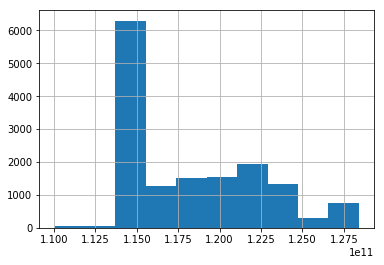

'CO_ENTIDADE'

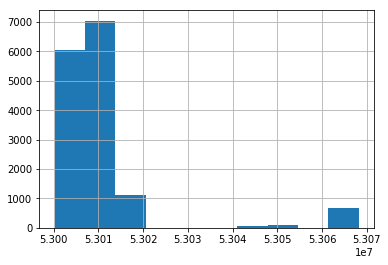

'SUM_TURMA_IN_DIA_SEMANA_QUARTA'

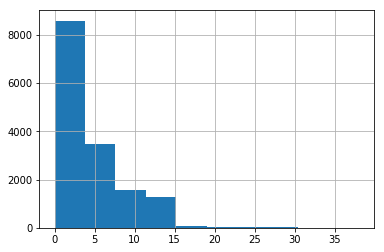

'SUM_TURMA_IN_DIA_SEMANA_QUINTA'

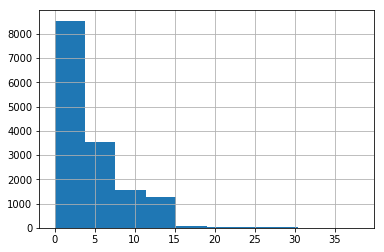

'SUM_TURMA_IN_DIA_SEMANA_SEGUNDA'

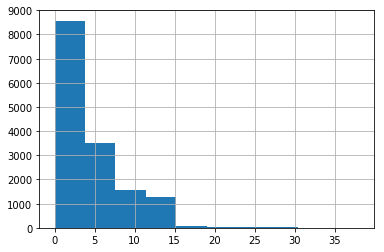

'SUM_TURMA_IN_DIA_SEMANA_SEXTA'

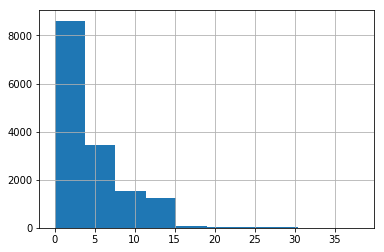

'SUM_TURMA_IN_DIA_SEMANA_TERCA'

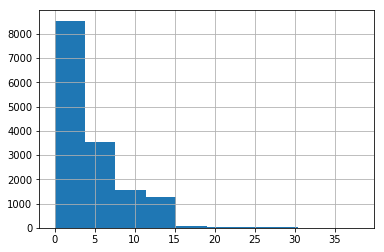

'SUM_TURMA_IN_DISC_ARTES'

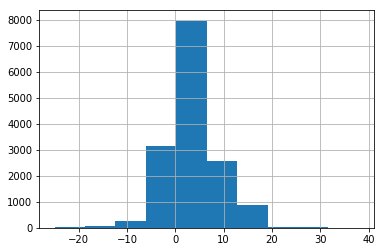

'SUM_TURMA_IN_DISC_BIOLOGIA'

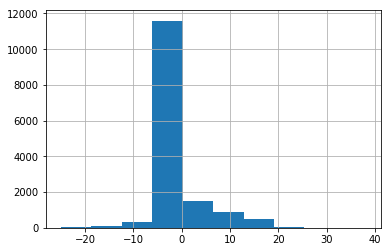

'SUM_TURMA_IN_DISC_CIENCIAS'

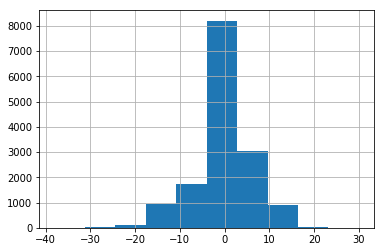

'SUM_TURMA_IN_DISC_EDUCACAO_FISICA'

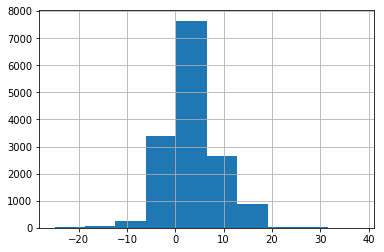

'SUM_TURMA_IN_DISC_ENSINO_RELIGIOSO'

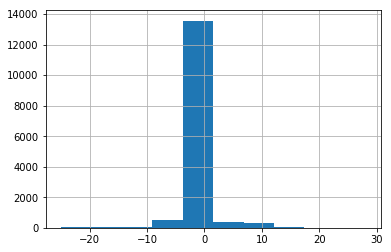

'SUM_TURMA_IN_DISC_ESTUDOS_SOCIAIS'

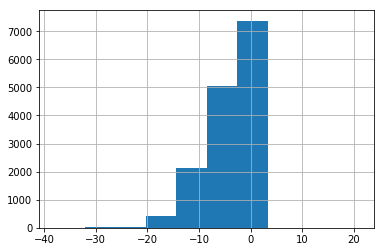

'SUM_TURMA_IN_DISC_EST_SOCIAIS_SOCIOLOGIA'

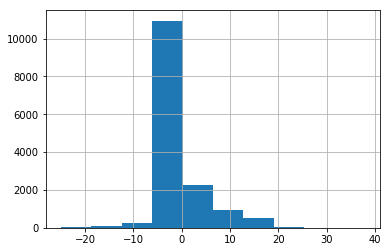

'SUM_TURMA_IN_DISC_FILOSOFIA'

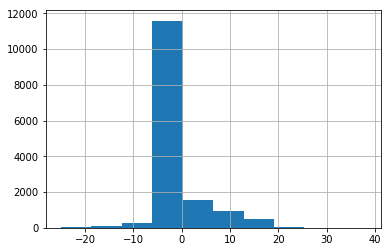

'SUM_TURMA_IN_DISC_FISICA'

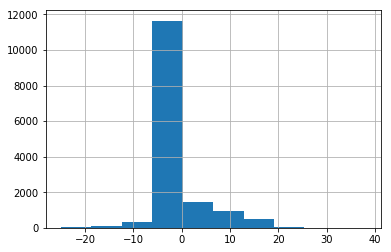

'SUM_TURMA_IN_DISC_GEOGRAFIA'

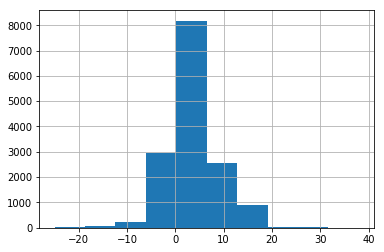

'SUM_TURMA_IN_DISC_HISTORIA'

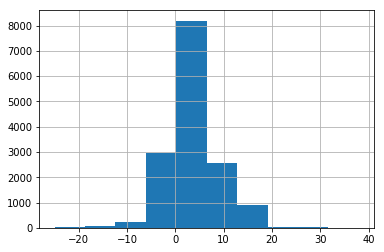

'SUM_TURMA_IN_DISC_INFORMATICA_COMPUTACAO'

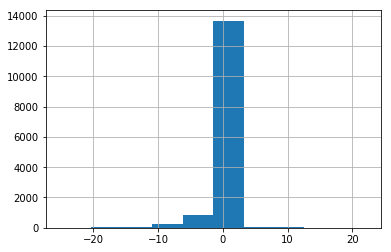

'SUM_TURMA_IN_DISC_LIBRAS'

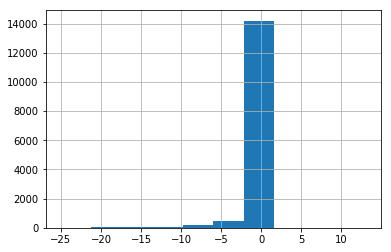

'SUM_TURMA_IN_DISC_LINGUA_ESPANHOL'

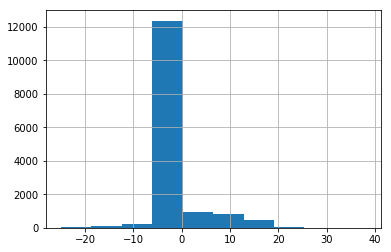

'SUM_TURMA_IN_DISC_LINGUA_FRANCES'

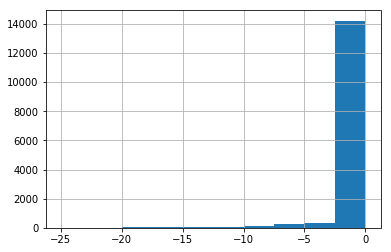

'SUM_TURMA_IN_DISC_LINGUA_INDIGENA'

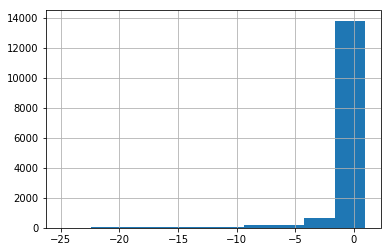

'SUM_TURMA_IN_DISC_LINGUA_INGLES'

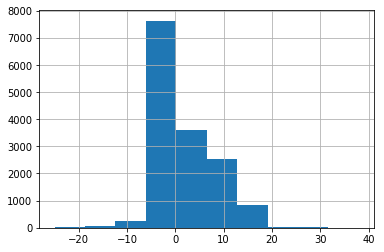

'SUM_TURMA_IN_DISC_LINGUA_OUTRA'

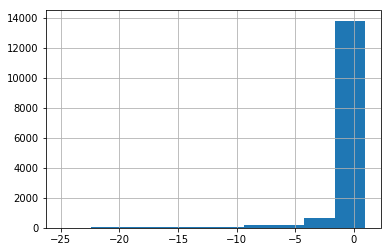

'SUM_TURMA_IN_DISC_LINGUA_PORTUGUESA'

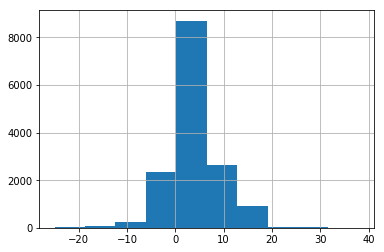

'SUM_TURMA_IN_DISC_MATEMATICA'

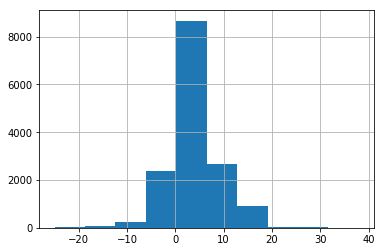

'SUM_TURMA_IN_DISC_OUTRAS'

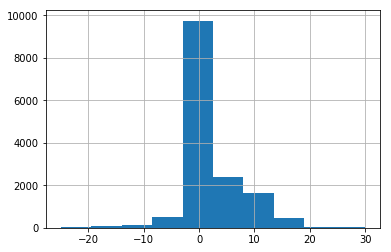

'SUM_TURMA_IN_DISC_QUIMICA'

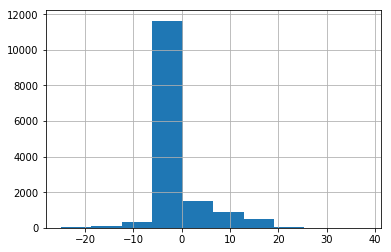

'SUM_TURMA_IN_DISC_SOCIOLOGIA'

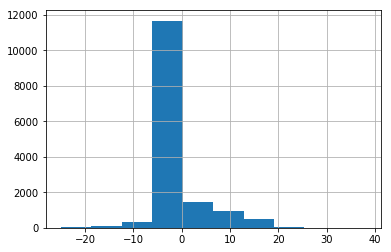

'SUM_TURMA_IN_EJA'

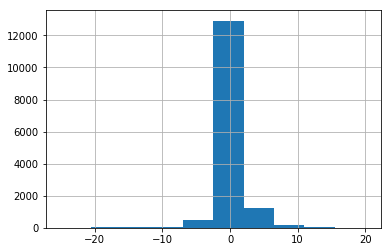

'SUM_TURMA_IN_ESPECIAL_EXCLUSIVA'

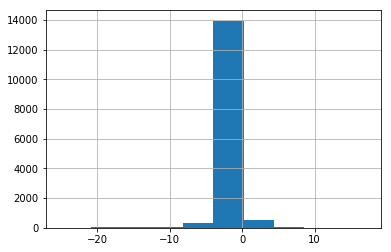

'SUM_TURMA_IN_MAIS_EDUCACAO'

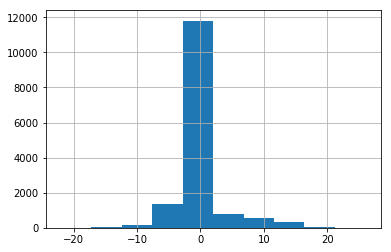

'SUM_TURMA_IN_REGULAR'

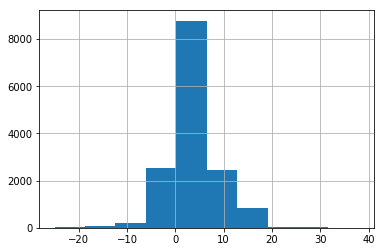

'SUM_TURMA_NU_DIAS_ATIVIDADE'

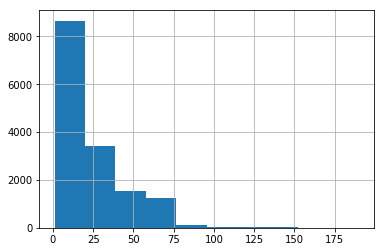

'SUM_TURMA_NU_DURACAO_TURMA'

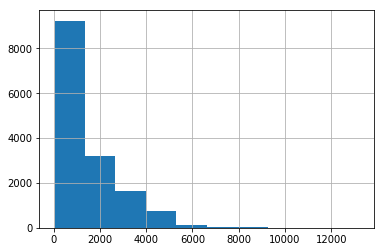

'SUM_TURMA_NU_MATRICULAS'

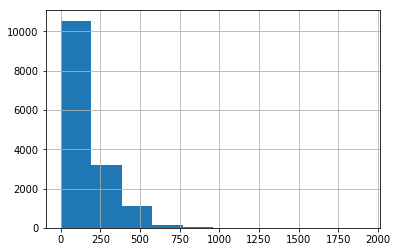

'SUM_TURMA_IN_MANHA'

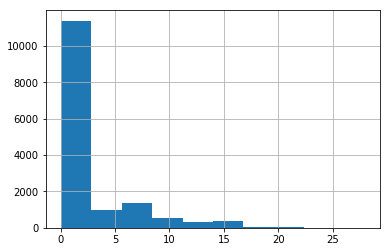

'SUM_TURMA_IN_TARDE'

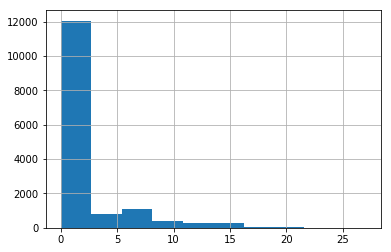

'MAX_TURMA_NU_DURACAO_TURMA'

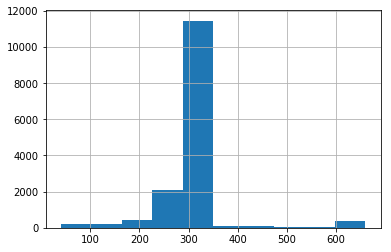

'MAX_TURMA_NU_MATRICULAS'

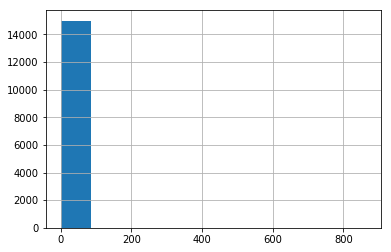

'MIN_TURMA_NU_DURACAO_TURMA'

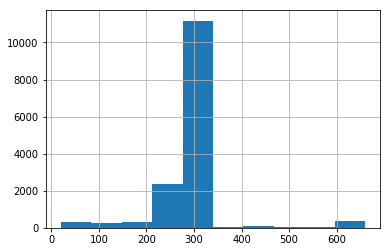

'MIN_TURMA_NU_MATRICULAS'

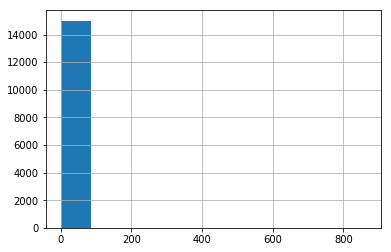

'CO_ORGAO_REGIONAL'

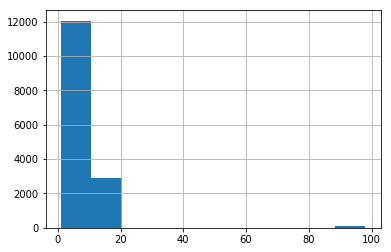

'TP_ATIVIDADE_COMPLEMENTAR'

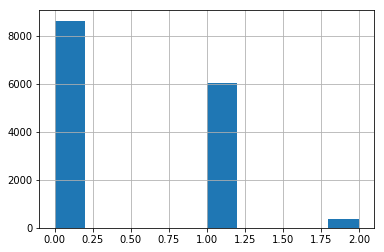

'IN_LABORATORIO_INFORMATICA'

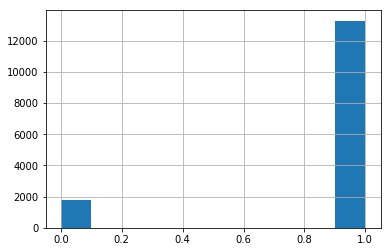

'IN_LABORATORIO_CIENCIAS'

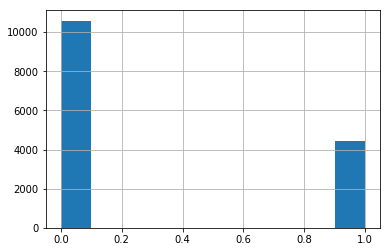

'IN_SALA_ATENDIMENTO_ESPECIAL'

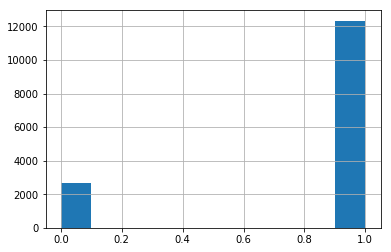

'IN_QUADRA_ESPORTES_COBERTA'

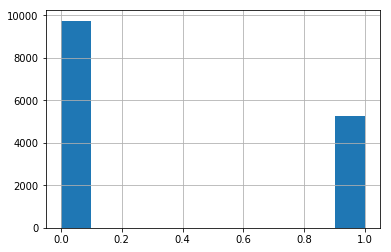

'IN_QUADRA_ESPORTES_DESCOBERTA'

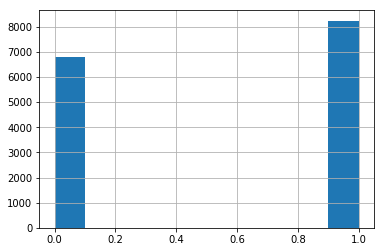

'IN_QUADRA_ESPORTES'

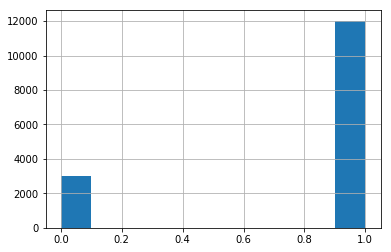

'IN_BIBLIOTECA'

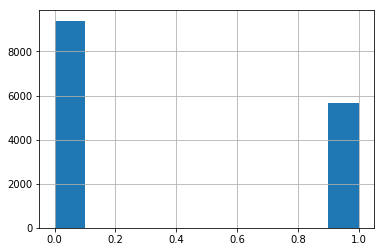

'IN_SALA_LEITURA'

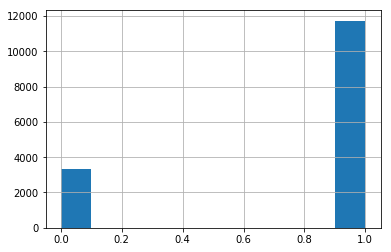

'IN_PARQUE_INFANTIL'

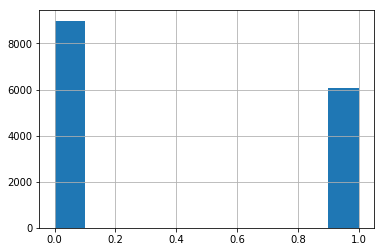

'IN_BANHEIRO_EI'

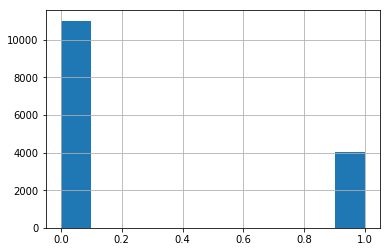

'IN_BANHEIRO_PNE'

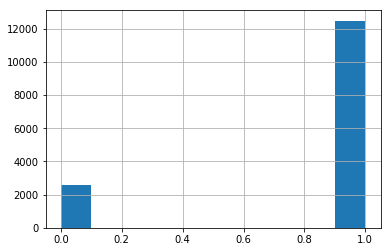

'IN_DEPENDENCIAS_PNE'

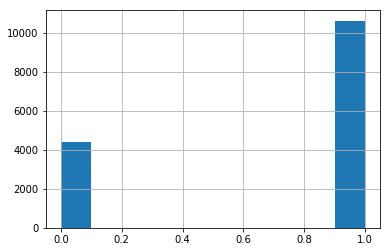

'IN_BANHEIRO_CHUVEIRO'

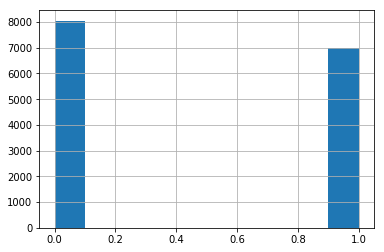

'IN_REFEITORIO'

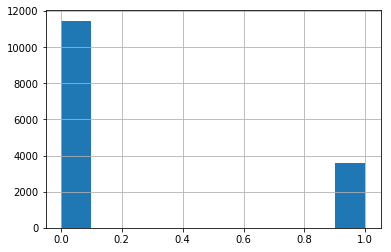

'IN_DESPENSA'

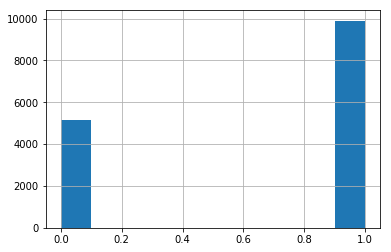

'IN_ALMOXARIFADO'

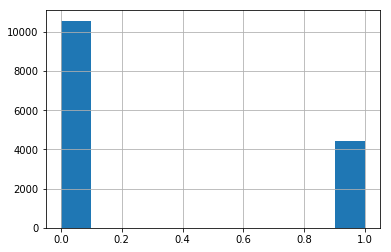

'IN_AUDITORIO'

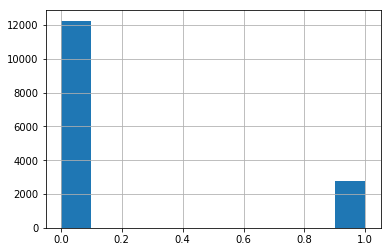

'IN_PATIO_COBERTO'

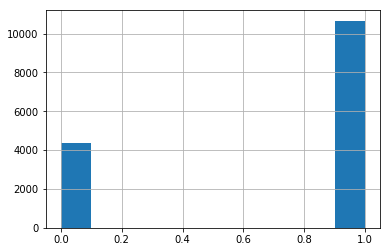

'IN_PATIO_DESCOBERTO'

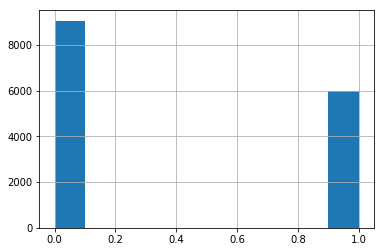

'IN_AREA_VERDE'

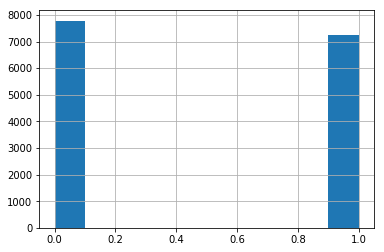

'NU_SALAS_EXISTENTES'

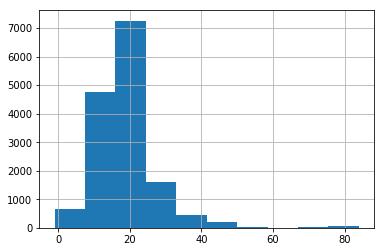

'NU_SALAS_UTILIZADAS'

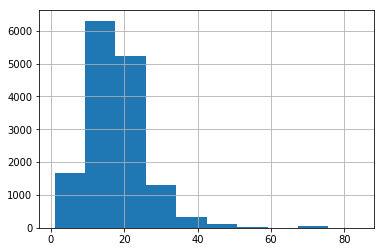

'IN_EQUIP_VIDEOCASSETE'

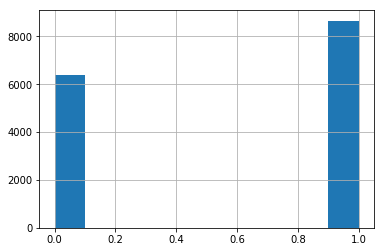

'IN_EQUIP_PARABOLICA'

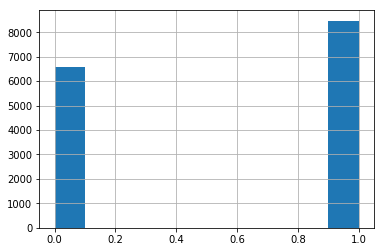

'IN_EQUIP_RETROPROJETOR'

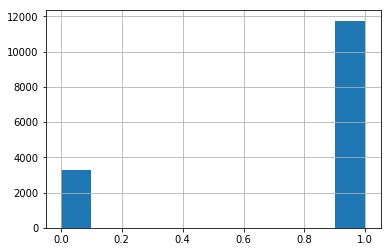

'IN_EQUIP_IMPRESSORA_MULT'

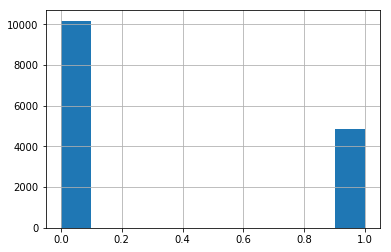

'IN_EQUIP_FAX'

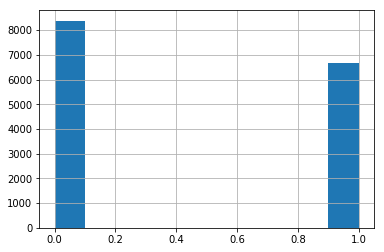

'IN_EQUIP_FOTO'

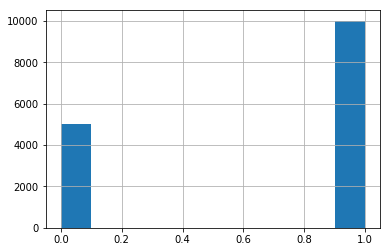

'NU_EQUIP_TV'

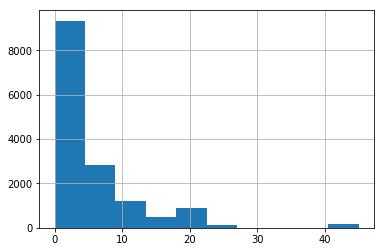

'NU_EQUIP_VIDEOCASSETE'

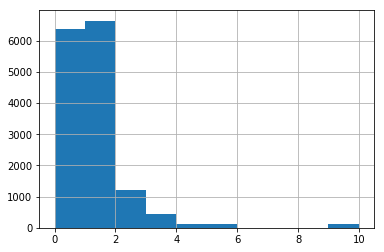

'NU_EQUIP_DVD'

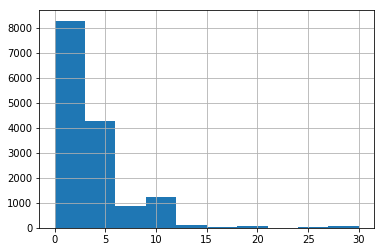

'NU_EQUIP_PARABOLICA'

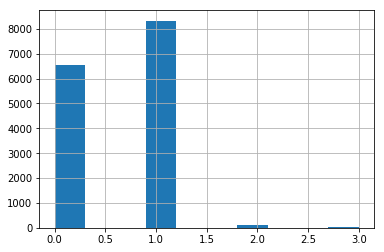

'NU_EQUIP_COPIADORA'

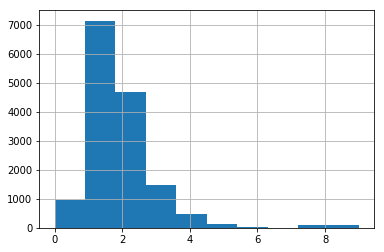

'NU_EQUIP_RETROPROJETOR'

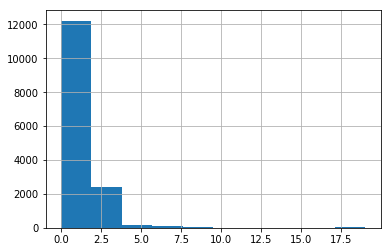

'NU_EQUIP_IMPRESSORA'

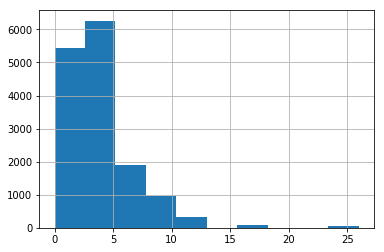

'NU_EQUIP_IMPRESSORA_MULT'

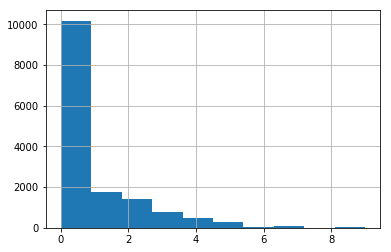

'NU_EQUIP_SOM'

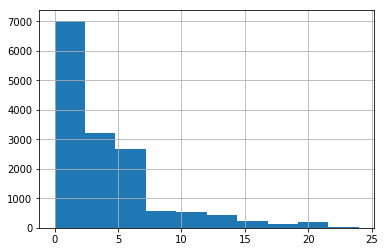

'NU_EQUIP_MULTIMIDIA'

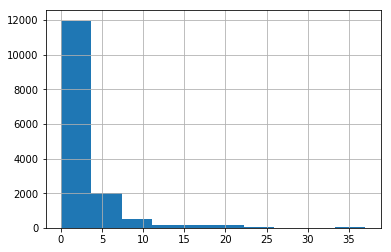

'NU_EQUIP_FAX'

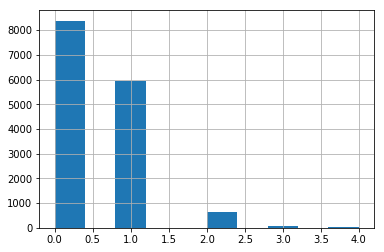

'NU_EQUIP_FOTO'

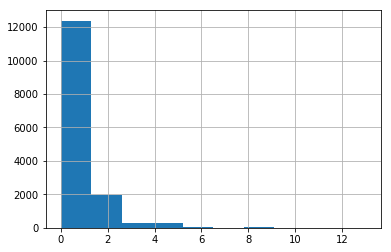

'NU_COMPUTADOR'

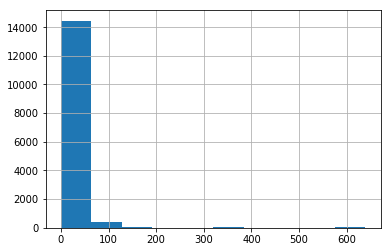

'NU_COMP_ADMINISTRATIVO'

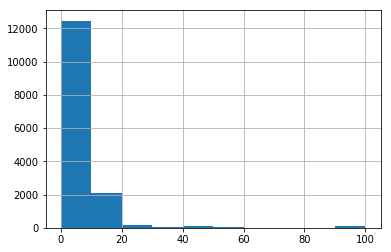

'NU_COMP_ALUNO'

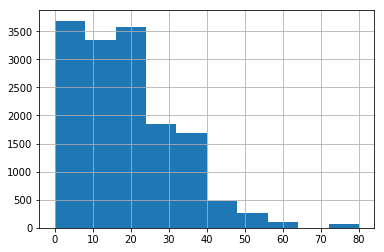

'NU_FUNCIONARIOS'

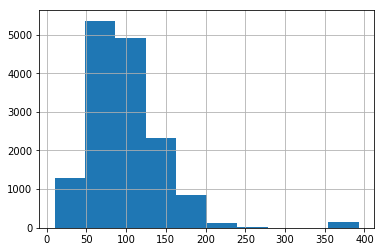

'IN_FUNDAMENTAL_CICLOS'

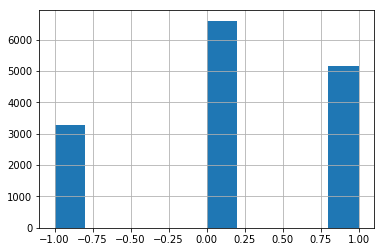

'IN_FINAL_SEMANA'

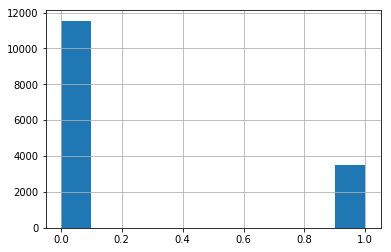

'IN_ESPECIAL_EXCLUSIVA'

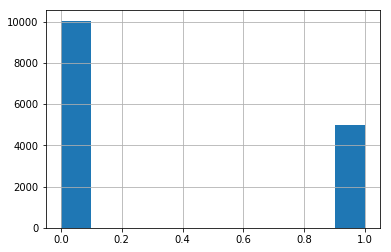

'IN_EJA'

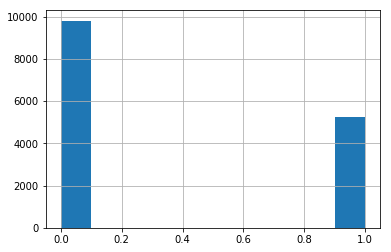

'IN_COMUM_PRE'

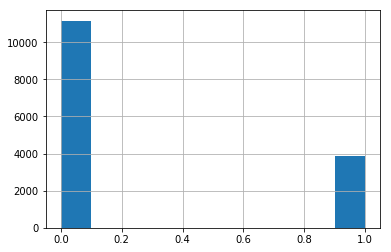

'IN_COMUM_FUND_AI'

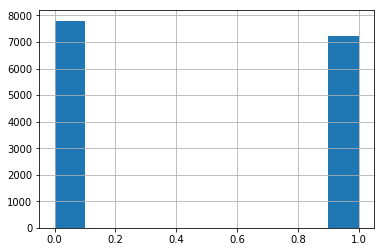

'IN_COMUM_FUND_AF'

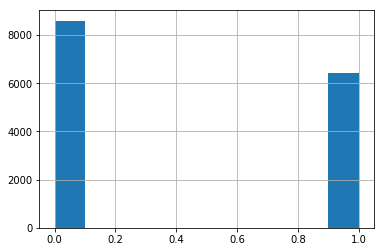

'IN_COMUM_MEDIO_MEDIO'

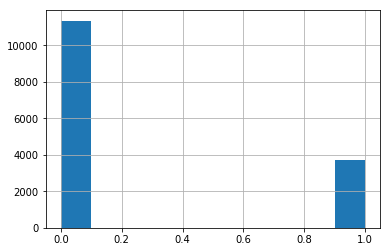

'IN_ESP_EXCLUSIVA_FUND_AI'

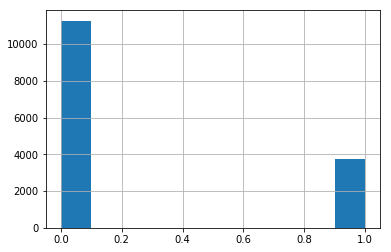

'IN_COMUM_EJA_FUND'

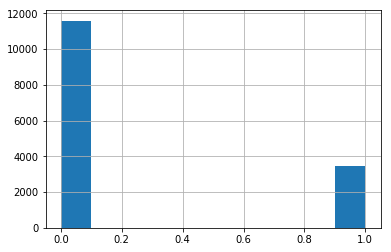

'NUM_DD_AULAS'

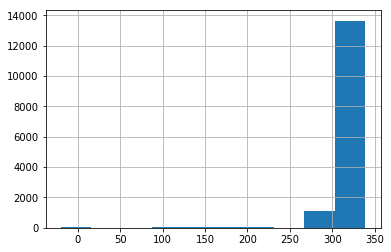

'PC_SALAS_UTILIZADAS'

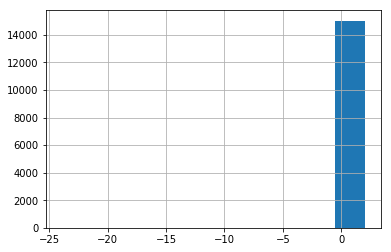

'NU_TTL_MATRICLAS'

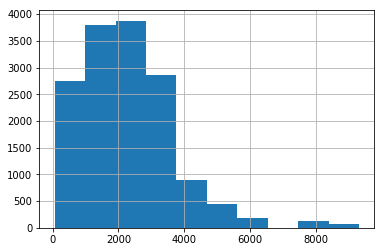

'NU_SALAS_EXISTENTES_PER_MATRICULA'

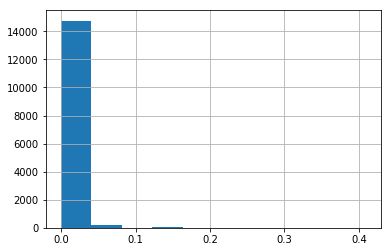

'NU_SALAS_UTILIZADAS_PER_MATRICULA'

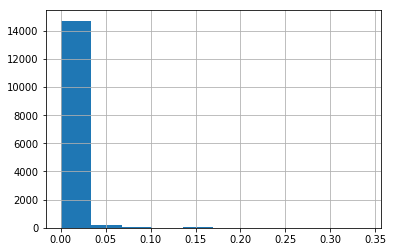

'NU_EQUIP_TV_PER_MATRICULA'

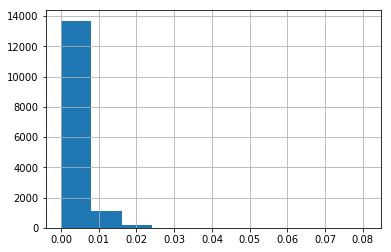

'NU_EQUIP_VIDEOCASSETE_PER_MATRICULA'

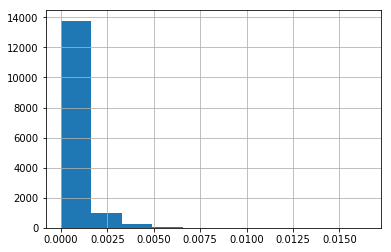

'NU_EQUIP_DVD_PER_MATRICULA'

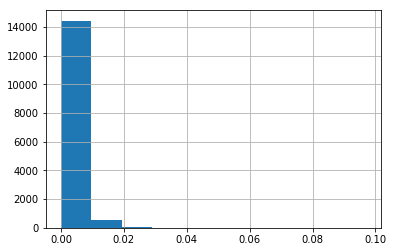

'NU_EQUIP_PARABOLICA_PER_MATRICULA'

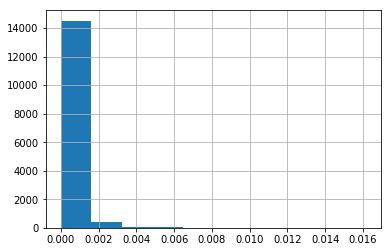

'NU_EQUIP_COPIADORA_PER_MATRICULA'

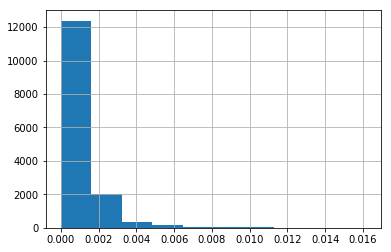

'NU_EQUIP_RETROPROJETOR_PER_MATRICULA'

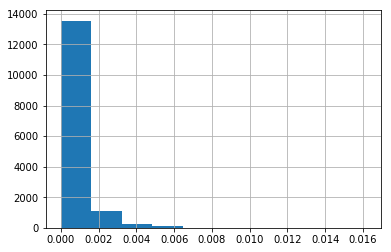

'NU_EQUIP_IMPRESSORA_PER_MATRICULA'

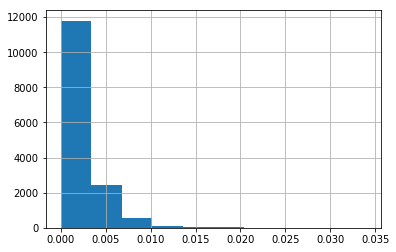

'NU_EQUIP_IMPRESSORA_MULT_PER_MATRICULA'

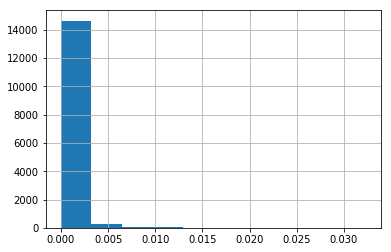

'NU_EQUIP_SOM_PER_MATRICULA'

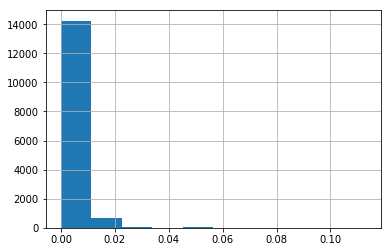

'NU_EQUIP_MULTIMIDIA_PER_MATRICULA'

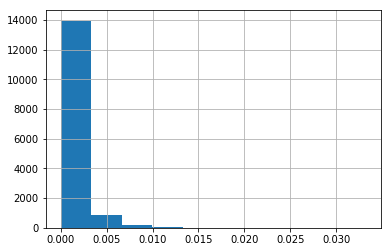

'NU_EQUIP_FAX_PER_MATRICULA'

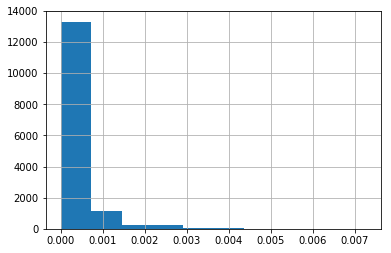

'NU_EQUIP_FOTO_PER_MATRICULA'

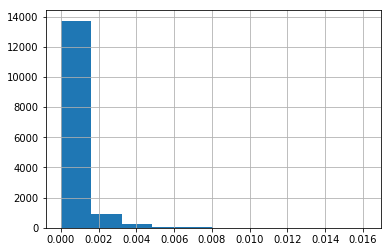

'NU_COMPUTADOR_PER_MATRICULA'

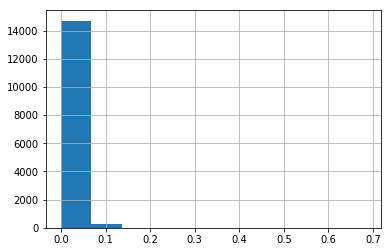

'NU_COMP_ADMINISTRATIVO_PER_MATRICULA'

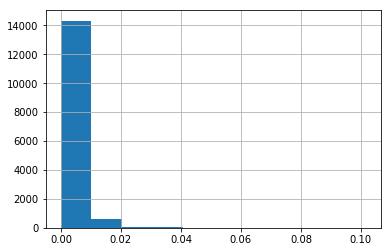

'NU_COMP_ALUNO_PER_MATRICULA'

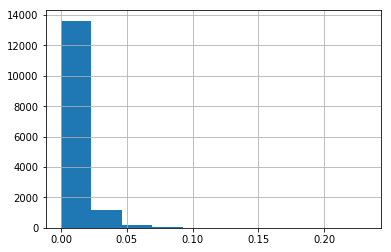

'NU_FUNCIONARIOS_PER_MATRICULA'

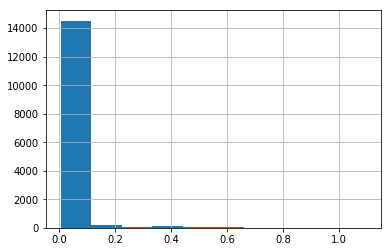

'NU_PROFESSORES_PER_MATRICULA'

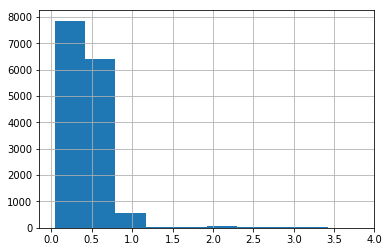

'target'

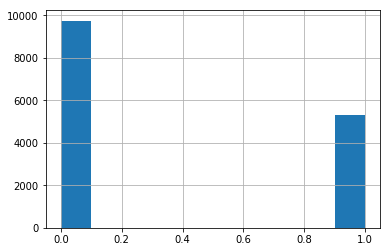

['SUM_TURMA_IN_PROFISSIONALIZANTE', 'MAX_TURMA_NU_DIAS_ATIVIDADE', 'MIN_TURMA_NU_DIAS_ATIVIDADE', 'TP_LOCALIZACAO', 'IN_ESGOTO_REDE_PUBLICA', 'IN_ESGOTO_FOSSA', 'IN_BIBLIOTECA_SALA_LEITURA']


In [135]:
qtd_esc = model_vars.shape[0]
dc = []
for c in model_vars.columns:
    if stats.mode(model_vars[c])[1] / qtd_esc > 0.9:
        dc.append(c)
    else:
        display(c)
        model_vars[c].hist()
        plt.show()
print(dc)

<h1>
<i>TO DO</i>, adicionar dados de:
</h1><br/><br/>
01. Alunos que compoe as turmas que o professor da aula.<br/>
02. Vizinhanca da escola.<br/>
03. Infraestrutura e seguranca do bairro.<br/>

In [129]:
pet.groupby('target')['CO_ENTIDADE'].nunique()

target
0    655
1    638
Name: CO_ENTIDADE, dtype: int64